# DataStream Generator

In [39]:
import pandas as pd
import numpy as np

class DataStream:
    def __init__(self, n_batches=100, batch_size=1000, seed=42):
        self.n_batches = n_batches
        self.batch_size = batch_size
        self.seed = seed
        self.data = self.generate_data()
        self.current_batch = 0

    def generate_data(self):
        raise NotImplementedError("Must be implemented by the subclass")

    def get_feature_names(self):
        if not hasattr(self, 'features'):
            raise NotImplementedError("Must be implemented by the subclass")
        return self.features

    def get_target_names(self):
        if not hasattr(self, 'target_names'):
            raise NotImplementedError("Must be implemented by the subclass")
        return self.target_names

    def __iter__(self):
        return self

    def __next__(self):
        if self.current_batch < self.n_batches:
            batch_data = self.get_window(self.current_batch)
            self.current_batch += 1
            return batch_data
        else:
            self.current_batch = 0
            raise StopIteration

    def get_window(self, window):
        return self.data[self.data['window'] == window]

    @staticmethod
    def plot_window(window_data, title):
      plt.figure(figsize=(8, 6))
      # plot features only, see self.features
      scatter = plt.scatter(window_data['x1'], window_data['x2'], c=window_data['label'], cmap='viridis', alpha=0.5)
      plt.colorbar(scatter, label='Label')
      plt.xlabel('x1')
      plt.ylabel('x2')
      plt.title(title)
      plt.show()

    def plot_windows(self, every = 5):
        for idx, window in enumerate(self):
            if idx % every == 0:
              self.plot_window(window, f'Data Stream {self.type} - Window {window["window"].iloc[0]}')


# Circle (Pesaranghader et al., 2016): This dataset contains two features x1, x2 drawn uniformly from the interval [0, 1].
# We use 100000 points (100 batches, 1000 points per batch) from this dataset. Each data point is labeled as per the
# condition (x1 − c1)2 + (x2 − c2)2 <= r where the center (c1, c2)) and radius r of the circular decision boundary
# changes gradually over a period of time introducing (gradual) concept drift. Specifically we change the center and
# radius at batch 25, 50, and 75. Each time the change happens gradually over the next 5 batches with the center and
# radius changing for 20% of the points each time

class CircleDataStream(DataStream):
    type = 'Circle'
    features = ['x1', 'x2']
    target_names = ['label']

    def generate_data(self):
        data = []
        c1, c2, r = 0.5, 0.5, 0.3
        c1_target, c2_target, r_target = c1, c2, r
        change_step = 0

        for batch in range(self.n_batches):
            x1 = np.random.uniform(0, 1, self.batch_size)
            x2 = np.random.uniform(0, 1, self.batch_size)
            labels = ((x1 - c1)**2 + (x2 - c2)**2 <= r**2).astype(int)
            batch_data = pd.DataFrame({'x1': x1, 'x2': x2, 'label': labels, 'window': batch})
            data.append(batch_data)

            # Gradual drift
            if batch in [25, 50, 75]:
                c1_target = np.random.uniform(0.2, 0.8)
                c2_target = np.random.uniform(0.2, 0.8)
                r_target = np.random.uniform(0.2, 0.3)
                change_step = 1

            if change_step > 0 and change_step <= 5:
                c1 += (c1_target - c1) / (6 - change_step)
                c2 += (c2_target - c2) / (6 - change_step)
                r += (r_target - r) / (6 - change_step)
                change_step += 1

        return pd.concat(data)


# Covcon: We construct this 2-dimensional dataset to have covariate shift and concept drift. The decision boundary at
# each point is given by α ∗ sin(πx1) > x2. We use 10000 points (100 batches, 1000 points per batch). Covariate shift is
# introduced by changing the location of x1 and x2 (for batch t x1 and x2 are drawn from the Gaussian distribution with
# mean ((t + 1)%7)/10 and standard deviation 0.015). Concept drift is introduced by alternating the value of α between
# 0.8 and 1, every 25 batches and also changing the inequality from > to < after 50 batches.

class CovConDataStream(DataStream):
    type = 'CovCon'
    features = ['x1', 'x2']
    target_names = ['label']

    def generate_data(self):
        data = []
        alpha = 0.8
        for batch in range(self.n_batches):
            mean = ((batch + 1) % 7) / 10
            x1 = np.random.normal(mean, 0.15, self.batch_size)
            x2 = np.random.normal(mean, 0.15, self.batch_size)
            if batch < 50:
                labels = (alpha * np.sin(np.pi * x1) > x2).astype(int)
            else:
                labels = (alpha * np.sin(np.pi * x1) < x2).astype(int)
            batch_data = pd.DataFrame({'x1': x1, 'x2': x2, 'label': labels, 'window': batch})
            data.append(batch_data)

            # Concept drift
            if batch % 25 == 0 and batch != 0:
                alpha = 1.0 if alpha == 0.8 else 0.8

        return pd.concat(data)

## This generator is an implementation of the dara stream with abrupt concept drift
## The classification function is y > sin(x), which abruptly changes upon specified indices

class SineDataStream(DataStream):
    type = 'Sine'
    features = ['x1', 'x2']
    target_names = ['label']

    def generate_data(self):
        data = []
        is_positive = True
        np.random.seed(self.seed)

        for batch in range(self.n_batches):
            x = np.random.uniform(0, 1, self.batch_size)
            y = np.random.uniform(0, 1, self.batch_size)

            if is_positive:
                labels = (y < np.sin(x * np.pi)).astype(int)
            else:
                labels = (y >= np.sin(x * np.pi)).astype(int)

            batch_data = pd.DataFrame({'x1': x, 'x2': y, 'label': labels, 'window': batch})
            data.append(batch_data)

            # Abrupt drift at batches 25, 50, and 75
            if batch in [25, 50, 75]:
                is_positive = not is_positive

        return pd.concat(data)

class IOAdmissionStream(DataStream):
    type = 'IOAdmission'
    features = ['size','queue_len','prev_queue_len_1','prev_queue_len_2','prev_queue_len_3','prev_latency_1',
                'prev_latency_2','prev_latency_3','prev_throughput_1','prev_throughput_2','prev_throughput_3']
    target_names = ['reject']
    data_path = 'misc/6350_6500_readonly_10k_sampled.parquet'

    def generate_data(self):
        return pd.read_parquet(self.data_path)

import matplotlib.pyplot as plt

circle_ds = CircleDataStream()
# circle_ds.plot_windows()

covcon_ds = CovConDataStream()
# covcon_ds.plot_windows()

sine_ds = SineDataStream()
# sine_ds.plot_windows()

io_ds = IOAdmissionStream()

# Algorithms

In [45]:
from sklearn.base import BaseEstimator
from sklearn.base import clone

class Algorithm:
    def __init__(self, model: BaseEstimator):
        self.model = model
        self.is_fitted = False

    def fit(self, X, y):
        pass

    def predict(self, X):
        if not self.is_fitted:
            raise RuntimeError("Model must be fitted before predicting")
        return self.model.predict(X)

    def reset(self):
        self.model = clone(self.model)
        self.is_fitted = False


class NoRetrain(Algorithm):
    def fit(self, X, y):
        if not self.is_fitted:
            print("TOTAL TRAIN LENGTH", str(len(X)))
            self.model.fit(X, y)
            self.is_fitted = True
            return str(len(X))
        return 0

from collections import deque
import numpy as np
from sklearn.base import BaseEstimator

class AlwaysRetrain(Algorithm):
    def __init__(self, model: BaseEstimator, memory=1):
        super().__init__(model)
        self.memory = memory
        self.history = []

    def fit(self, X, y):
        self.history.append((X,y))

        if len(self.history) > self.memory:
            self.history.pop(0)

        total_X = np.concatenate([x for x, _ in self.history])
        total_y = np.concatenate([y for _, y in self.history])

        print("FITTING ALWAYS RETRAIN, Memory:", str(self.memory), "Total Train Length:", str(len(total_X)))

        self.model.fit(total_X, total_y)

        self.is_fitted = True

        return str(len(total_X))

    def reset(self):
        super().reset()
        self.history = []


In [44]:
from sklearn.metrics import accuracy_score
from collections import defaultdict

class Matchmaker(Algorithm):

    def __init__(self, base_estimator, memory=7):
        super().__init__(base_estimator)
        self.memory = memory
        self.models = []
        self.datasets= []
        ## HIGH score -> GOOD.
        ## Covariate score will be calculated inference time
        self.concept_score = []

        self.forest_dict = None
        self.base_estimator = base_estimator

    def reset(self):
        self.is_fitted = False
        self.concept_score = []
        self.models = []
        self.datasets = []
        self.forest_dict = None

    def fit(self,X,y):
        ## clone base estimator, fit on data, and add to models
        model = clone(self.base_estimator)
        model.fit(X, y)

        self.models.append(model)
        self.datasets.append((X,y))
        self.rank_concept(X,y)
        if len(self.models) > self.memory:
            # model eviction, get index of lowest concept score
            min_index = self.concept_score.index(min(self.concept_score))
            self.models.pop(min_index)
            self.datasets.pop(min_index)
            self.concept_score.pop(min_index)
        print("Current model zoo length:", str(len(self.models)))
        return self.build_tree()

    def predict(self, X):
        model = self.get_model(X)
        return model.predict(X)

    def rank_concept(
        self,
        X,
        y
    ):
        # ranking the models based on ACC
        self.concept_score = [0] * len(self.models)
        for idx, model in enumerate(self.models):
            prediction_result = model.predict(X)
            self.concept_score[idx] = accuracy_score(y, prediction_result)

    def build_tree(self):
        X = np.concatenate([X for X, y in self.datasets])
        y = np.concatenate([y for X, y in self.datasets])


        from sklearn.ensemble import RandomForestClassifier

        forest = RandomForestClassifier(n_estimators=5, max_depth=15, random_state=42)
        # fit on whole data to create the tree
        self.forest = forest.fit(X, y)
        covariate_forest_dict = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: 0)))

        # then loop for each model's dataset.
        # how much did this model's data end up at every leaf?
        for model_idx, dataset in enumerate(self.datasets):
            X_local, y_local = dataset
            X_leaf_forest = forest.apply(X_local)

            for instance_idx, instance_leaves in enumerate(X_leaf_forest):
                for tree_idx, tree_leaf_idx in enumerate(instance_leaves):
                    ## First index is the tree ID,
                    ## second index is the leaf ID
                    ## third index is the model ID -> A leaf will be populated by multiple models
                    covariate_forest_dict[tree_idx][tree_leaf_idx][model_idx] += 1
        self.forest_dict = covariate_forest_dict

        # return number of data used to build tree
        return len(X)

    def calculate_borda_count(self, ranking):
        # Given an array of scores, will return an array containing ranking of each indices
        ## eg: [3,2,1] means that model 0 is the highest ranked (3 point), followed by 2 and 1.
        ## Will return [1,2,3] -> Means that model 0 is ranked 1, index 1 is ranked 2, index 2 is ranked 3
        n = len(ranking)
        borda_count = [0] * n

        sorted_indices = sorted(range(n), key=lambda i: ranking[i], reverse=True)

        for i, index in enumerate(sorted_indices):
            borda_count[index] += i + 1

        return borda_count

    def get_model_borda_count(self, covariate_score):
        concept_borda_count = self.calculate_borda_count(self.concept_score)

        covariate_borda_count = self.calculate_borda_count(covariate_score)

        combined_borda_count = [concept + covariate for concept, covariate in zip(concept_borda_count, covariate_borda_count)]
        return combined_borda_count.index(min(combined_borda_count))

    def rank_covariate(self, X):
        X_forest = self.forest.apply(X)
        model_weights = defaultdict(lambda: 0)

        for instance_idx, instance_forest in enumerate(X_forest):
            for tree_idx, tree_leaf_idx in enumerate(instance_forest):
                if tree_leaf_idx in self.forest_dict[tree_idx]:
                    datapoints_each_model = self.forest_dict[tree_idx][tree_leaf_idx]
                    for model_idx, datapoints in datapoints_each_model.items():
                        model_weights[model_idx] += datapoints

        model_rankings = []
        for i in range(len(self.concept_score)):
            if i in model_weights:
                model_rankings.append(model_weights[i])
            else:
                model_rankings.append(0)
        return model_rankings

    def get_model(self, X):
        # On inference time, concept will never change.
        # Covariate does.
        covariate_rank = self.rank_covariate(X)
        model_idx = self.get_model_borda_count(covariate_rank)
        model = self.models[model_idx]
        return model

In [46]:
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.model_selection import KFold
from sklearn.utils.validation import check_array, check_is_fitted, check_X_y

class StreamingEnsemble(ClassifierMixin, BaseEstimator):
    """Abstract, base ensemble streaming class"""

    def __init__(self, base_estimator, n_estimators, weighted=False):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.weighted = weighted

    def fit(self, X, y):
        """Fitting."""
        self.partial_fit(X, y)
        return self.partial_fit(X, y)

    def partial_fit(self, X, y, classes=None):
        """Partial fitting"""
        X, y = check_X_y(X, y)
        if not hasattr(self, "ensemble_"):
            self.ensemble_ = []

        self.green_light = True

        # Check feature consistency
        if hasattr(self, "X_"):
            if self.X_.shape[1] != X.shape[1]:
                raise ValueError("number of features does not match")
        self.X_, self.y_ = X, y

        # Check classes
        self.classes_ = classes
        if self.classes_ is None:
            self.classes_, _ = np.unique(y, return_inverse=True)

        # Check label consistency
        if len(np.unique(y)) != len(np.unique(self.classes_)):
            y[: len(np.unique(self.classes_))] = np.copy(self.classes_)

        # Check if it is possible to train new estimator
        if len(np.unique(y)) != len(self.classes_):
            self.green_light = False

        return self

    def ensemble_support_matrix(self, X):
        """Ensemble support matrix."""
        # print('ESM')
        return np.nan_to_num(np.array([member_clf.predict_proba(X) for member_clf in self.ensemble_]))

    def predict_proba(self, X):
        """Predict proba."""
        esm = self.ensemble_support_matrix(X)
        if self.weighted:
            esm *= np.array(self.weights_)[:, np.newaxis, np.newaxis]

        average_support = np.mean(esm, axis=0)
        return average_support

    def predict(self, X):
        """
        Predict classes for X.

        :type X: array-like, shape (n_samples, n_features)
        :param X: The training input samples.

        :rtype: array-like, shape (n_samples, )
        :returns: The predicted classes.
        """

        # Check is fit had been called
        check_is_fitted(self, "classes_")
        X = check_array(X)
        if X.shape[1] != self.X_.shape[1]:
            raise ValueError("number of features does not match")
        proba = self.predict_proba(X)
        prediction = np.argmax(proba, axis=1)

        # Return prediction
        return self.classes_[prediction]

    def msei(self, clf, X, y):
        """MSEi score from original AWE algorithm."""
        pprobas = clf.predict_proba(X)
        probas = np.zeros(len(y))
        for label in self.classes_:
            probas[y == label] = pprobas[y == label, label]
        return np.sum(np.power(1 - probas, 2)) / len(y)

    def prior_proba(self, y):
        """Calculate prior probability for given labels"""
        return np.unique(y, return_counts=True)[1] / len(y)

    def mser(self, y):
        """MSEr score from original AWE algorithm."""
        prior_proba = self.prior_proba(y)
        return np.sum(prior_proba * np.power((1 - prior_proba), 2))

    def minority_majority_split(self, X, y, minority_name, majority_name):
        """Returns minority and majority data

        :type X: array-like, shape (n_samples, n_features)
        :param X: The training input samples.
        :type y: array-like, shape  (n_samples)
        :param y: The target values.

        :rtype: tuple (array-like, shape = [n_samples, n_features], array-like, shape = [n_samples, n_features])
        :returns: Tuple of minority and majority class samples
        """

        minority_ma = np.ma.masked_where(y == minority_name, y)
        minority = X[minority_ma.mask]

        majority_ma = np.ma.masked_where(y == majority_name, y)
        majority = X[majority_ma.mask]

        return minority, majority

    def minority_majority_name(self, y):
        """Returns minority and majority data

        :type y: array-like, shape  (n_samples)
        :param y: The target values.

        :rtype: tuple (object, object)
        :returns: Tuple of minority and majority class names.
        """

        unique, counts = np.unique(y, return_counts=True)

        if counts[0] > counts[1]:
            majority_name = unique[0]
            minority_name = unique[1]
        else:
            majority_name = unique[1]
            minority_name = unique[0]

        return minority_name, majority_name


class AUE(StreamingEnsemble, Algorithm):
    """Accuracy Updated Ensemble"""

    def __init__(self, base_estimator=None, n_estimators=10, n_splits=3, epsilon=0.0001, epochs=20):
        """Initialization."""
        super().__init__(base_estimator, n_estimators)
        self.n_splits = n_splits
        self.epsilon = epsilon
        self.epochs = epochs

    def reset(self):
        self.is_fitted = False
        self.ensemble_ = []
        self.weights_ = []

    def partial_fit(self, X, y, classes=None):
        y = np.array(y)
        X = np.array(X)
        super().partial_fit(X, y, classes)
        if not self.green_light:
            print("Green light not true! Cannot train new classifier")
            return self

        # Compute baseline
        mser = self.mser(y)

        # Train new estimator
        candidate = clone(self.base_estimator).fit(self.X_, self.y_)

        # Calculate its scores
        scores = []
        kf = KFold(n_splits=self.n_splits)
        for fold, (train, test) in enumerate(kf.split(X)):
            if len(np.unique(y[train])) != len(self.classes_):
                continue
            fold_candidate = clone(self.base_estimator).fit(self.X_[train], self.y_[train])
            msei = self.msei(fold_candidate, self.X_[test], self.y_[test])
            scores.append(msei)

        # Save scores
        candidate_msei = np.mean(scores)
        candidate_weight = 1 / (candidate_msei + self.epsilon)

        # Calculate weights of current ensemble
        self.weights_ = [1 / (self.msei(clf, self.X_, self.y_) + self.epsilon) for clf in self.ensemble_]

        # Add new model
        self.ensemble_.append(candidate)
        self.weights_.append(candidate_weight)

        # Remove the worst when ensemble becomes too large
        if len(self.ensemble_) > self.n_estimators:
            worst_idx = np.argmin(self.weights_)
            del self.ensemble_[worst_idx]
            del self.weights_[worst_idx]

        # AUE update procedure
        comparator = 1 / mser
        counter = 0
        for i, clf in enumerate(self.ensemble_):
            if i == len(self.ensemble_) - 1:
                break
            ## If current weight is > comparator, update by refitting
            if self.weights_[i] > comparator:
                counter += 1
                for _ in range(self.epochs):
                  clf.partial_fit(X, y)
        print("Model has {} classifiers, with weights {}".format(len(self.ensemble_), str(self.weights_)))
        print("Retrained {} classifiers, comparator: {}".format(counter, comparator))
        return len(X)

In [47]:
from collections import defaultdict
import numpy as np
from sklearn.base import BaseEstimator

class DriftSurf(Algorithm):
    def __init__(self, model: BaseEstimator, delta=0.1, r=3, wl=2):
        super().__init__(model)
        self.reac_len = r
        self.delta = delta
        self.win_len = wl
        self.models = {"pred": None, "stab": None, "reac": None}
        self.train_data_dict = {"pred": [0], "stab": [0], "reac": []}
        self.acc_best = 0
        self.window_counter = 0
        self.acc_dict = None
        self.reac_ctr = None
        self.state = "stab"
        self.model_key = "pred"  # Model used for prediction
        self.data_df_dict = defaultdict(dict)
        self.train_keys = ["pred", "stab"]

    def reset(self):
        self.models = {"pred": None, "stab": None, "reac": None}
        self.train_data_dict = {"pred": [0], "stab": [0], "reac": [0]}
        self.acc_best = 0
        self.counter = 0
        self.acc_dict = None
        self.reac_ctr = None
        self.state = "stab"
        self.model_key = "pred"
        self.is_fitted = False
        self.data_df_dict = defaultdict(dict)
        self.train_keys = ["pred", "stab"]
        self.window_counter = 0
        self.is_fitted = False


    def predict(self, X):
        y_pred = self.models[self.model_key].predict(X)
        return y_pred

    def _score(self, model_key, X, y):
        y_pred = self.models[model_key].predict(X)
        accuracy = np.mean(y_pred == y)
        return accuracy

    def initialize_model(self, key):
        self.models[key] = clone(self.model)

    def _train(self):
        num_train = 0
        for key in self.train_keys:
            if self.models[key] is None:
                self.initialize_model(key)

            for iter_id in self.train_data_dict[key]:
                X_train, y_train = self.data_df_dict[iter_id]
                self.models[key].fit(X_train, y_train)
                num_train += len(X_train)
        return num_train

    def set_key_df(self, iter_id, data_df_dict):
        self.data_df_dict[iter_id] = data_df_dict

    def _append_train_data(self, model_key, iter_id):
        self.train_data_dict[model_key].append(iter_id)
        if len(self.train_data_dict[model_key]) > self.win_len:
            self.train_data_dict[model_key].pop(0)

    def _reset(self, key):
        self.models[key] = None
        self.train_data_dict[key] = []

    def fit(self, X, y):
        curr_iter = self.window_counter
        self.window_counter += 1
        self.set_key_df(curr_iter, (X, y))

        if curr_iter == 0:
            self._train()
            return

        acc_pred = self._score("pred", X, y)
        print(f"DS Iteration {curr_iter}, acc: {acc_pred}")

        if acc_pred > self.acc_best:
            self.acc_best = acc_pred

        if self.state == "stab":
            if len(self.train_data_dict["stab"]) == 0:
                acc_stab = 0
            else:
                acc_stab = self._score("stab", X, y)

            if (acc_pred < self.acc_best - self.delta) or (acc_pred < acc_stab - self.delta / 2):
                print("Entering reactive state")
                self.state = "reac"
                self._reset("reac")
                self.reac_ctr = 0
                self.acc_dict = {"pred": np.zeros(self.reac_len), "reac": np.zeros(self.reac_len)}
            else:
                self._append_train_data("pred", curr_iter)
                self._append_train_data("stab", curr_iter)
                self.train_keys = ["pred", "stab"]

        if self.state == "reac":
            if self.reac_ctr > 0:
                acc_reac = self._score("reac", X, y)
                print(f"acc_reac = {acc_reac}")
                self.acc_dict["pred"][self.reac_ctr - 1] = acc_pred
                self.acc_dict["reac"][self.reac_ctr - 1] = acc_reac

                if acc_reac > acc_pred:
                    self.model_key = "reac"
                else:
                    self.model_key = "pred"

            self._append_train_data("pred", curr_iter)
            self._append_train_data("reac", curr_iter)
            self.train_keys = ["pred", "reac"]
            self.reac_ctr += 1

            if self.reac_ctr == self.reac_len:
                self.state = "stab"
                self._reset("stab")
                if np.mean(self.acc_dict["pred"]) < np.mean(self.acc_dict["reac"]):
                    self.models["pred"] = self.models["reac"]
                    self.train_data_dict["pred"] = self.train_data_dict["reac"]
                    self.acc_best = np.amax(self.acc_dict["reac"])
                    self.model_key = "pred"
                self.acc_dict = None
                self.reac_ctr = None
        print(f"DriftSurf State: {self.state}, Best Accuracy: {self.acc_best}, Current Model: {self.model_key}")
        num_train = self._train()
        return num_train


# Drift Detector

In [48]:
# For now, always retrain at every window. This can be extended to use other DD metrics.

class DriftDetector:
    def check_drift(self, data_window):
        pass

    def reset(self):
        return

class AlwaysDriftDetector(DriftDetector):
    def check_drift(self, data_window):
        return True


# Metric Evaluator

In [49]:
## This collects metrics from prediction and ground truth results
## This also contains plotting functions

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.metrics import accuracy_score, roc_auc_score

class MetricEvaluator:
    def __init__(self):
        self.results = {}

    def evaluate(self, idx, dataset_name, algo_name, y_true, y_pred, retrained, inference_time, training_time, num_train_data):
        true_positives = np.sum((y_true == 1) & (y_pred == 1))
        true_negatives = np.sum((y_true == 0) & (y_pred == 0))
        false_positives = np.sum((y_true == 0) & (y_pred == 1))
        false_negatives = np.sum((y_true == 1) & (y_pred == 0))

        accuracy = accuracy_score(y_true, y_pred)
        try:
            auc = roc_auc_score(y_true, y_pred)
        except ValueError:
            auc = 0.5

        if dataset_name not in self.results:
            self.results[dataset_name] = pd.DataFrame(columns=['idx','algo_name', 'accuracy', 'auc', 'true_positives', 'true_negatives', 'false_positives', 'false_negatives'])

        # Append the results to the DataFrame
        self.results[dataset_name] = self.results[dataset_name]._append({
            'idx': idx,
            'algo_name': algo_name,
            'accuracy': accuracy,
            'error-rate': 1 - accuracy,
            'auc': auc,
            'true_positives': true_positives,
            'true_negatives': true_negatives,
            'false_positives': false_positives,
            'false_negatives': false_negatives,
            'retrained': retrained,
            'inference_time': inference_time,
            'training_time': training_time,
            'num_train_data': num_train_data
        }, ignore_index=True)

    def get_results(self):
        return self.results

    def plot_line(self, data, metric, dataset_name):
      # Plot: Classic Line Plot
      plt.figure(figsize=(10, 6))
      sns.lineplot(x='idx', y=metric, hue='algo_name', data=data, palette=self.algo_cmap)
      plt.title(f'{metric.capitalize()} over Chunks by Algorithm \n {dataset_name}')
      plt.xlabel('Chunk Index')
      plt.ylabel(metric)
      plt.legend(title='Algorithm')
      plt.show()


    def error_bar_plot(self, data, metric, time_type, dataset_name):
      plt.figure(figsize=(14, 8))


      # Define a list of markers for differentiation
      markers = ['o', 's', 'D', '^', 'v', 'P', '*', 'X', '<', '>']
      marker_cycle = {algo: markers[i % len(markers)] for i, algo in enumerate(data['algo_name'].unique())}

      # Plot with error bars
      for algo_name, df in data.groupby('algo_name'):
          avg_time = df[df[time_type] > 1e-5][time_type].mean()
          avg_metric = df[metric].mean()
          std_deviation_metric = df[metric].std()

          plt.errorbar(
              x=avg_time,
              y=avg_metric,
              yerr=std_deviation_metric,
              fmt=marker_cycle[algo_name],  # Use varying markers
              label=algo_name,
              color=self.algo_cmap[algo_name],
              markersize=8,  # Adjust marker size
              capsize=5,  # Add whiskers
              elinewidth=2,  # Thickness of error bars
              markeredgewidth=1.5,  # Thickness of marker edges
              markerfacecolor='white'  # Add a distinct border
          )

      # Adding a border to the plot
      plt.gca().spines['top'].set_linewidth(1.5)
      plt.gca().spines['right'].set_linewidth(1.5)
      plt.gca().spines['left'].set_linewidth(1.5)
      plt.gca().spines['bottom'].set_linewidth(1.5)

      # Customizing the title and labels
      plt.title(f'{metric.capitalize()} vs {time_type.capitalize()} by Algorithm \n {dataset_name}', fontsize=16)
      plt.xlabel(f'{time_type.capitalize()} (s)', fontsize=14)
      plt.ylabel(f'{metric.capitalize()}', fontsize=14)

      # Fine-tuning the legend
      plt.legend(title='Algorithm', title_fontsize='13', fontsize='11', loc='best', frameon=True, fancybox=True, borderpad=1)

      plt.show()

    def scatter_plot(self, data, metric, time_type, size, dataset_name):
      plt.figure(figsize=(12, 6))

      scatter_data = []

      # Gather data and sort by bubble size (largest first)
      for algo_name, df in data.groupby('algo_name'):
          avg_time = df[df[time_type] > 1e-5][time_type].mean()
          avg_metric = df[metric].mean()
          df[size] = pd.to_numeric(df[size], errors='coerce')
          avg_size = df[df[size] > 0][size].mean()

          scatter_data.append((avg_time, avg_metric, avg_size, algo_name))

      scatter_data.sort(key=lambda x: x[2], reverse=True)

      # Convert to ms
      if 'time' in size:
        scatter_data = [(x[0], x[1], x[2] * 1000, x[3]) for x in scatter_data]

      # Plot each bubble
      for i, (avg_time, avg_metric, _size, algo_name) in enumerate(scatter_data):
          plt.scatter(x=avg_time, y=avg_metric, s=_size, color=self.algo_cmap[algo_name], label=algo_name)
          plt.text(avg_time, avg_metric, str(int(_size)), fontsize=10, ha='center', va='center')

      # # Create a custom legend
      handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=algo_name)
                for i, (algo_name, color) in enumerate(self.algo_cmap.items())]
      plt.legend(handles=handles, title='Algorithm')

      added_str = '- ms' if 'time' in size else ''
      plt.title(f'{metric.capitalize()} vs {time_type.capitalize()} vs {size.capitalize()} (Size {added_str}) \n {dataset_name}')
      plt.xlabel(f'{time_type.capitalize()} (s)')
      plt.ylabel(f'{metric.capitalize()}')
      plt.show()


    def plot_results(self, metrics=['accuracy']):
        sns.set(style="whitegrid")
        for dataset_name, df in self.results.items():
            self.palette = sns.color_palette(n_colors = len(df['algo_name'].unique()))
            self.algo_cmap = {}
            for palette_val, algo_name in zip(self.palette, df['algo_name'].unique()):
                self.algo_cmap[algo_name] = palette_val

            for metric in metrics:
                self.plot_line(df, metric, dataset_name)
                self.error_bar_plot(df, metric, 'inference_time', dataset_name)
                self.error_bar_plot(df, metric, 'training_time', dataset_name)
                self.scatter_plot(df, metric, 'inference_time', 'training_time', dataset_name)
                self.scatter_plot(df, metric, 'training_time', 'num_train_data', dataset_name)

        self.save_results()
            
    def save_results(self):
        for dataset_name, df in self.results.items():
            df.to_csv(f'results/{dataset_name}_results.csv', index=False)

    def load_results(self, dataset_name, path):
        self.results[dataset_name] = pd.read_csv(path)


# Main Pipeline

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

import time

class Pipeline:
    def __init__(self, dataset_name, data_stream, algorithms, drift_detector, metric_evaluator, test_size=0.2):
        self.dataset_name = dataset_name
        self.data_stream = data_stream
        self.algorithms = algorithms
        self.drift_detector = drift_detector
        self.metric_evaluator = metric_evaluator
        self.test_size = test_size

    def run(self):
        for algo_name, algorithm in self.algorithms.items():
            self.drift_detector.reset()
            algorithm.reset()

            for idx, data_window in enumerate(self.data_stream):
                print(f"Running {algo_name} on window {idx}")
                X = data_window[self.data_stream.get_feature_names()].to_numpy()
                y = data_window[self.data_stream.get_target_names()].to_numpy().ravel()

                retrained = False
                num_train_data = -1
                inference_time = 0
                training_time = 0

                if idx == 0:
                    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, random_state=42)

                    start_time = time.time()
                    num_train_data = algorithm.fit(X_train, y_train)
                    training_time = time.time() - start_time
                    print(f"Training time: {training_time}")

                    retrained = True

                    start_time = time.time()
                    y_pred = algorithm.predict(X_test)
                    inference_time = time.time() - start_time
                    print(f"Inference time: {inference_time}")

                    self.metric_evaluator.evaluate(idx, self.dataset_name, algo_name, y_test, y_pred, retrained, inference_time, training_time, num_train_data)
                    continue

                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, random_state=42)
                start_time = time.time()
                y_pred = algorithm.predict(X_test)
                inference_time = time.time() - start_time
                print(f"Accuracy: {accuracy_score(y_test, y_pred)}, Inference time: {inference_time} ")

                if self.drift_detector.check_drift(data_window):
                    start_time = time.time()
                    num_train_data = algorithm.fit(X_train, y_train)
                    training_time = time.time() - start_time
                    print(f"Training time: {training_time}")
                    retrained = True

                self.metric_evaluator.evaluate(idx, self.dataset_name, algo_name, y_test, y_pred, retrained, inference_time, training_time, num_train_data)
            self.metric_evaluator.plot_results()

        return self.metric_evaluator.get_results()

    def plot_results(self, metric=['accuracy', 'error-rate']):
        self.metric_evaluator.plot_results(metric)

# Usage

In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier

circle_ds = CircleDataStream()
covcon_ds = CovConDataStream()
sine_ds = SineDataStream()
io_admission = IOAdmissionStream()

algorithms = {
    'MLP-NoRetrain': NoRetrain(MLPClassifier(hidden_layer_sizes=(8,8), max_iter=500, learning_rate_init=0.01)),
    'MLP-RetrainWin': AlwaysRetrain(MLPClassifier(hidden_layer_sizes=(8,8), max_iter=500, learning_rate_init=0.01), memory = 7),
    'MLP-RetrainOne': AlwaysRetrain(MLPClassifier(hidden_layer_sizes=(8,8), max_iter=500, learning_rate_init=0.01), memory = 1),
    'MLP-Matchmaker': Matchmaker(MLPClassifier(hidden_layer_sizes=(8,8), max_iter=500, learning_rate_init=0.01)),
    'MLP-AUE': AUE(MLPClassifier(hidden_layer_sizes=(8,8), max_iter=500, learning_rate_init=0.01), n_estimators=7),
    'MLP-DriftSurf': DriftSurf(MLPClassifier(hidden_layer_sizes=(8,8), max_iter=500, learning_rate_init=0.01)),
}

Running MLP-NoRetrain on window 0
TOTAL TRAIN LENGTH 8000


Training time: 0.27814817428588867
Inference time: 0.0006279945373535156
Running MLP-NoRetrain on window 1
Accuracy: 0.6955, Inference time: 0.0005483627319335938 
Training time: 1.1920928955078125e-06
Running MLP-NoRetrain on window 2
Accuracy: 0.604, Inference time: 0.0004658699035644531 
Training time: 1.1920928955078125e-06
Running MLP-NoRetrain on window 3
Accuracy: 0.6855, Inference time: 0.0006077289581298828 
Training time: 1.430511474609375e-06
Running MLP-NoRetrain on window 4
Accuracy: 0.607, Inference time: 0.00046563148498535156 
Training time: 1.430511474609375e-06
Running MLP-NoRetrain on window 5
Accuracy: 0.6045, Inference time: 0.0006072521209716797 
Training time: 9.5367431640625e-07
Running MLP-NoRetrain on window 6
Accuracy: 0.6115, Inference time: 0.00046443939208984375 
Training time: 1.1920928955078125e-06
Running MLP-NoRetrain on window 7
Accuracy: 0.6245, Inference time: 0.0006084442138671875 
Training time: 1.430511474609375e-06
Running MLP-NoRetrain on windo

/tmp/ipykernel_3234533/4200675611.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.results[dataset_name] = self.results[dataset_name]._append({


Running MLP-NoRetrain on window 22
Accuracy: 0.617, Inference time: 0.0004718303680419922 
Training time: 1.1920928955078125e-06
Running MLP-NoRetrain on window 23
Accuracy: 0.674, Inference time: 0.0006110668182373047 
Training time: 9.5367431640625e-07
Running MLP-NoRetrain on window 24
Accuracy: 0.595, Inference time: 0.0004642009735107422 
Training time: 7.152557373046875e-07
Running MLP-NoRetrain on window 25
Accuracy: 0.5895, Inference time: 0.0006191730499267578 
Training time: 1.1920928955078125e-06
Running MLP-NoRetrain on window 26
Accuracy: 0.669, Inference time: 0.00046324729919433594 
Training time: 9.5367431640625e-07
Running MLP-NoRetrain on window 27
Accuracy: 0.5955, Inference time: 0.0006046295166015625 
Training time: 1.1920928955078125e-06
Running MLP-NoRetrain on window 28
Accuracy: 0.6155, Inference time: 0.0004601478576660156 
Training time: 9.5367431640625e-07
Running MLP-NoRetrain on window 29
Accuracy: 0.5905, Inference time: 0.0006070137023925781 
Training ti

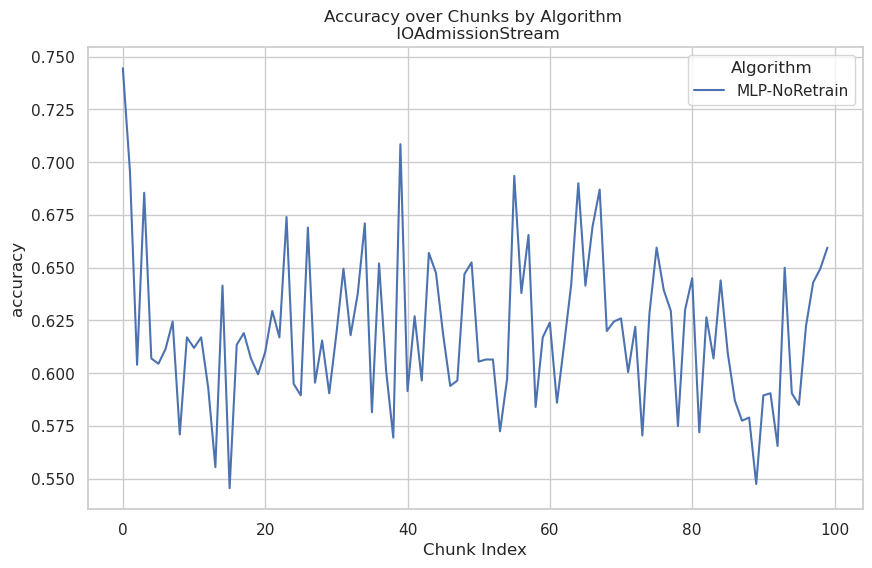

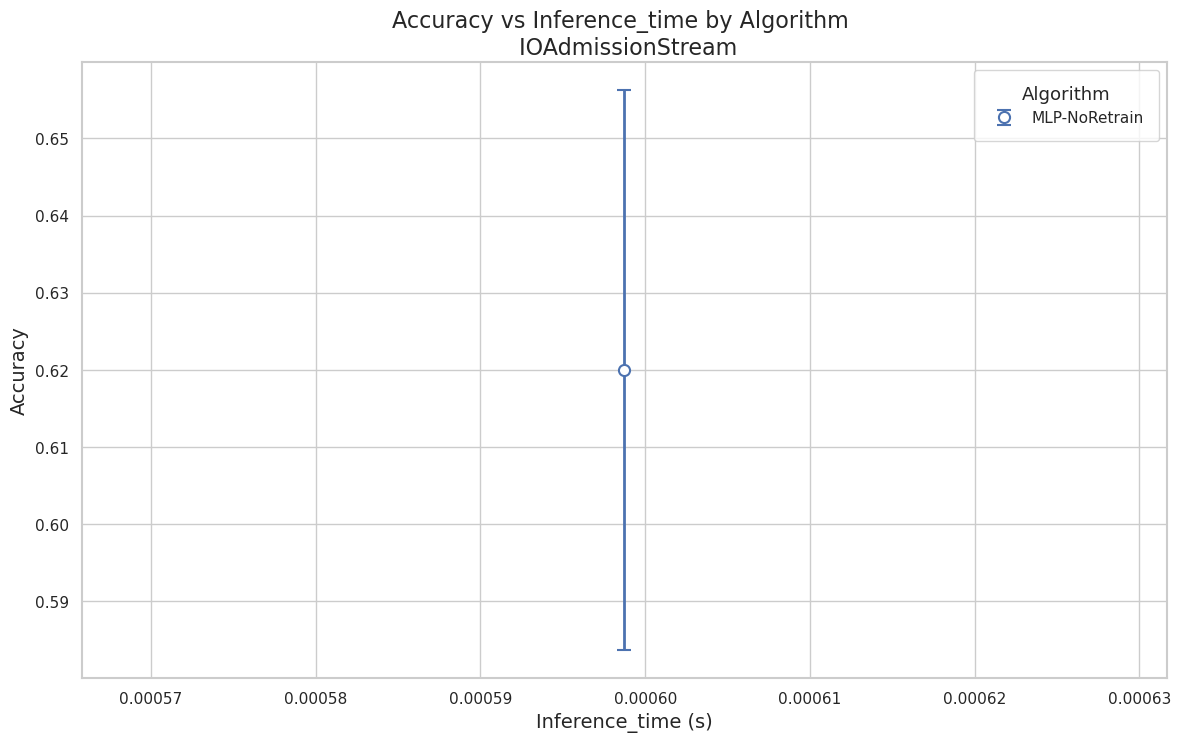

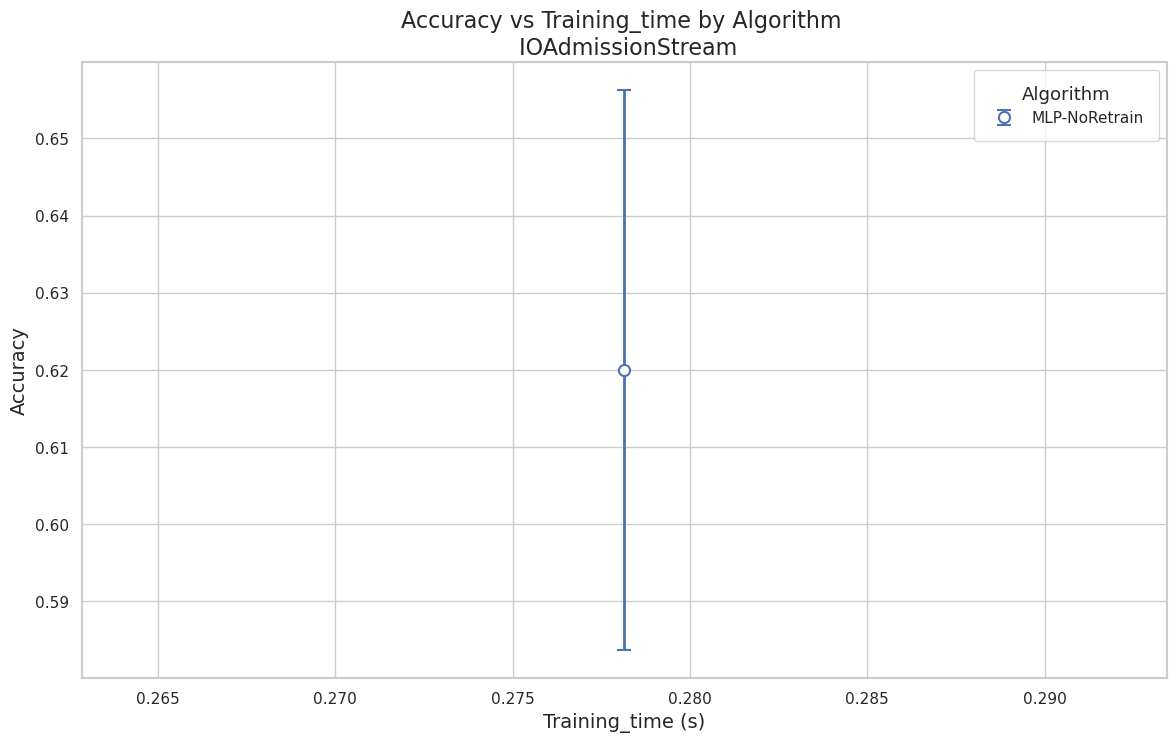

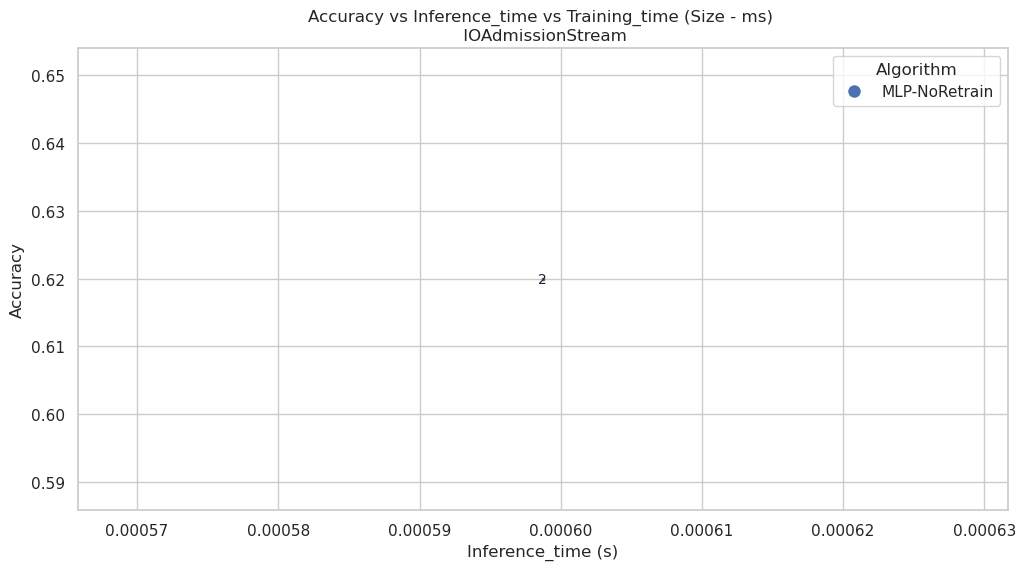

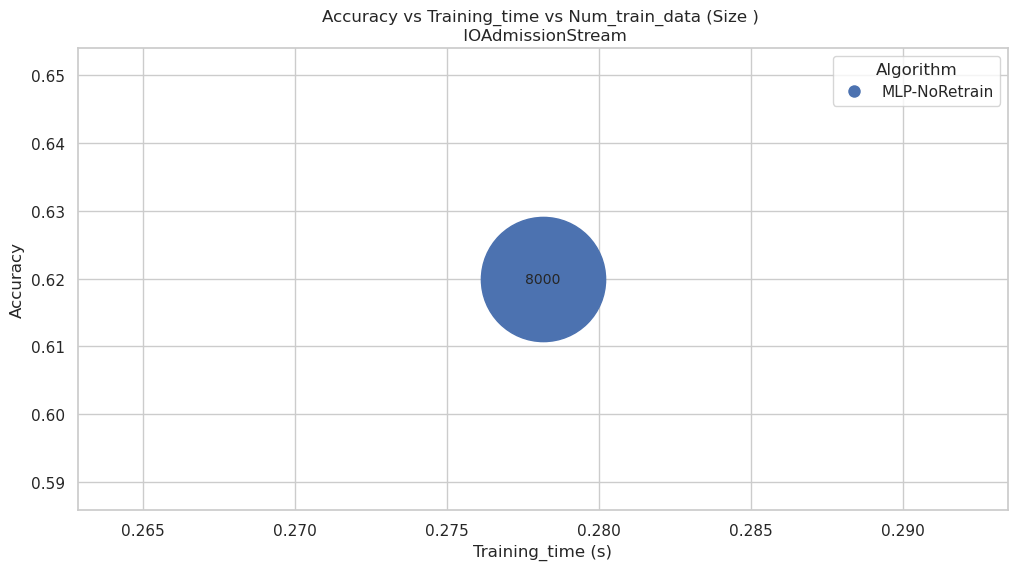

Running MLP-RetrainWin on window 0
FITTING ALWAYS RETRAIN, Memory: 7 Total Train Length: 8000
Training time: 1.3614983558654785
Inference time: 0.0006008148193359375
Running MLP-RetrainWin on window 1
Accuracy: 0.7155, Inference time: 0.0004634857177734375 
FITTING ALWAYS RETRAIN, Memory: 7 Total Train Length: 16000
Training time: 1.1833429336547852
Running MLP-RetrainWin on window 2
Accuracy: 0.6085, Inference time: 0.0005779266357421875 
FITTING ALWAYS RETRAIN, Memory: 7 Total Train Length: 24000
Training time: 3.333186626434326
Running MLP-RetrainWin on window 3
Accuracy: 0.779, Inference time: 0.0005786418914794922 
FITTING ALWAYS RETRAIN, Memory: 7 Total Train Length: 32000
Training time: 4.511762619018555
Running MLP-RetrainWin on window 4
Accuracy: 0.7235, Inference time: 0.0005862712860107422 
FITTING ALWAYS RETRAIN, Memory: 7 Total Train Length: 40000
Training time: 2.320075511932373
Running MLP-RetrainWin on window 5
Accuracy: 0.7275, Inference time: 0.0005750656127929688 
FI

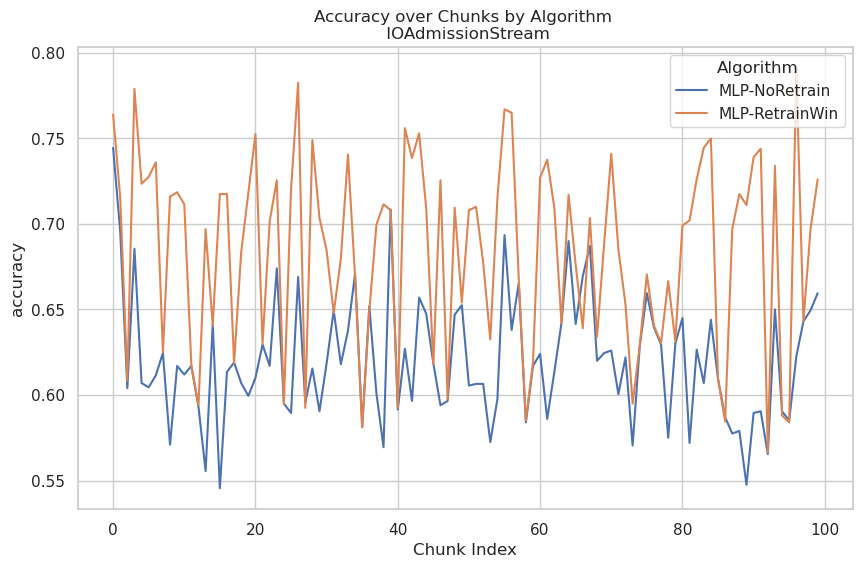

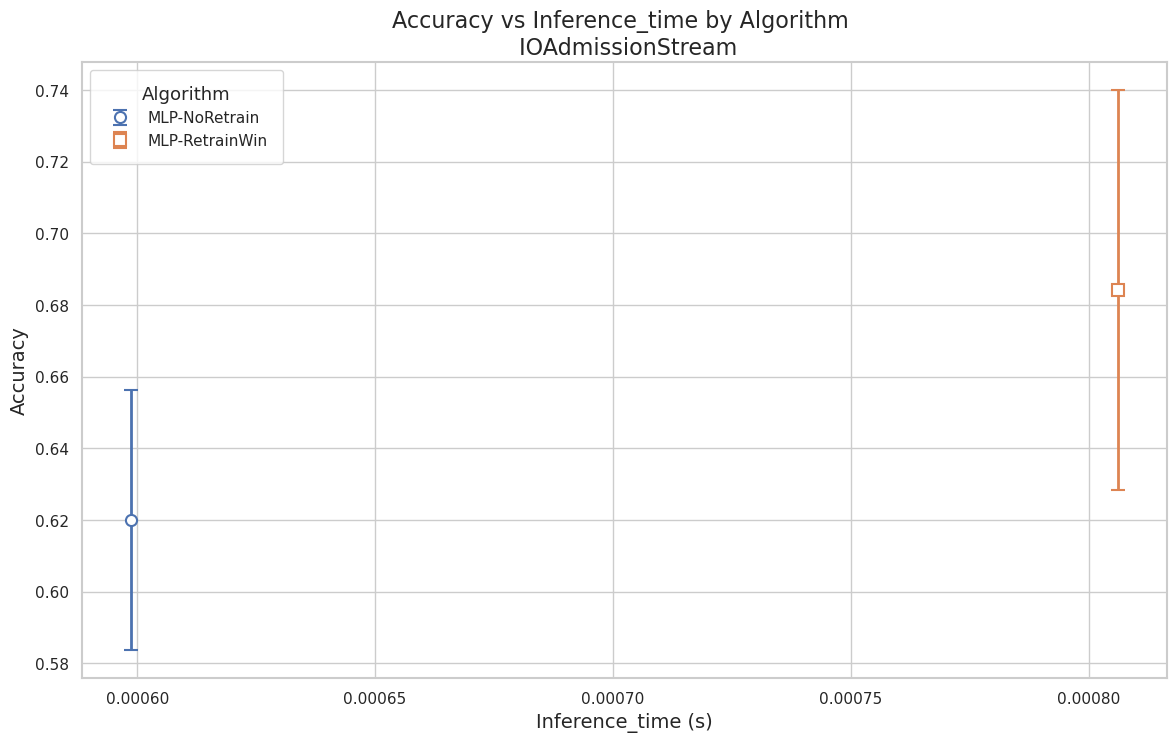

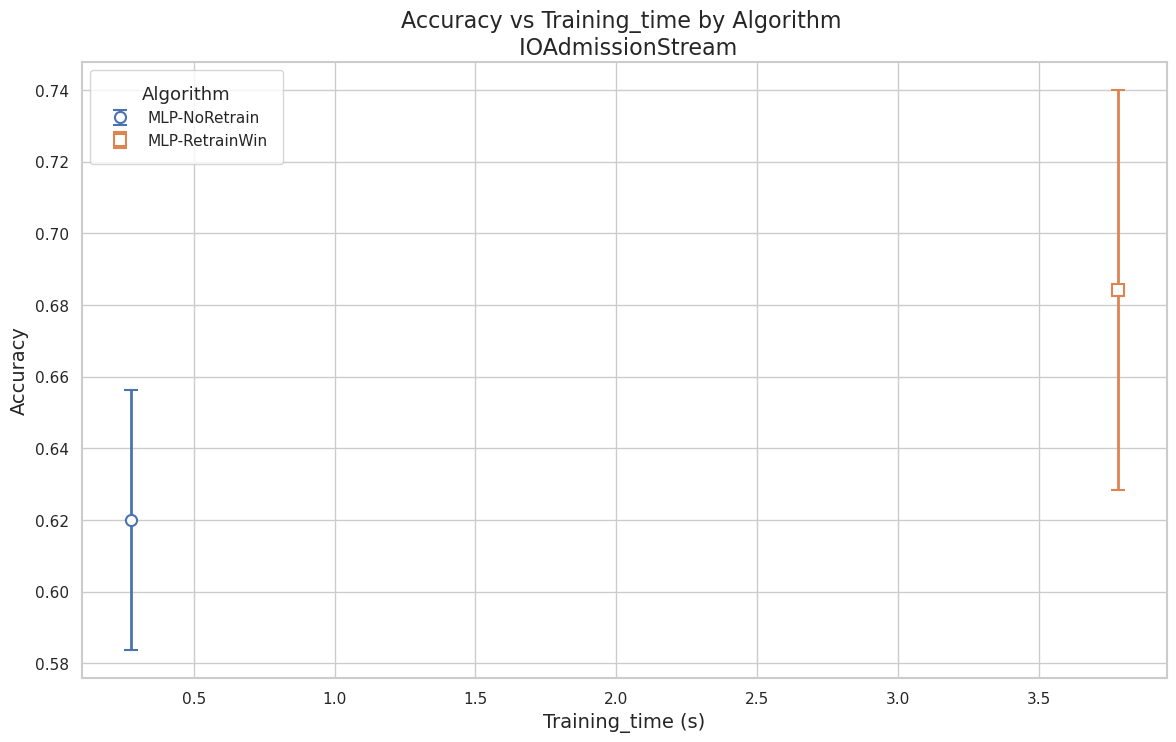

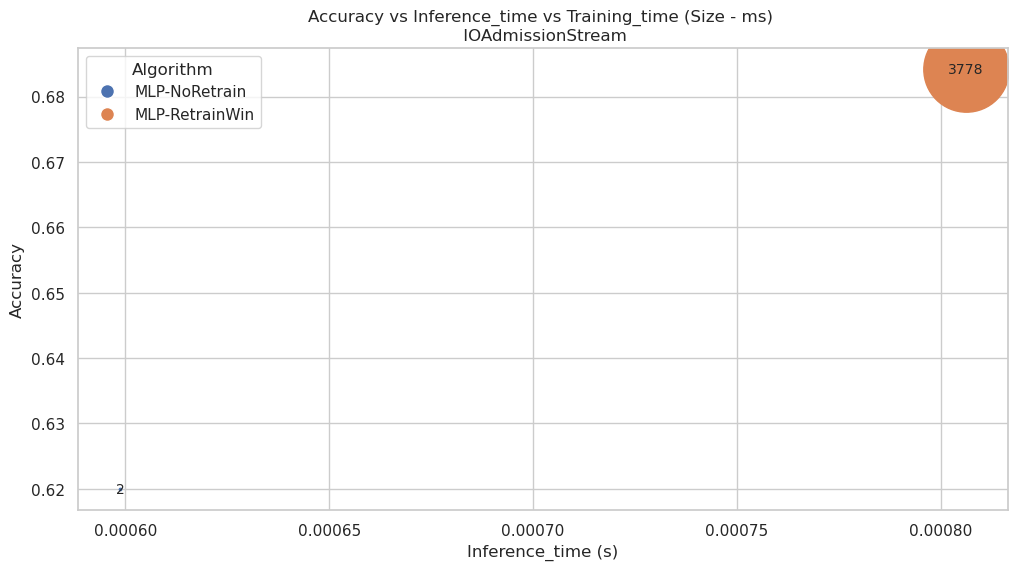

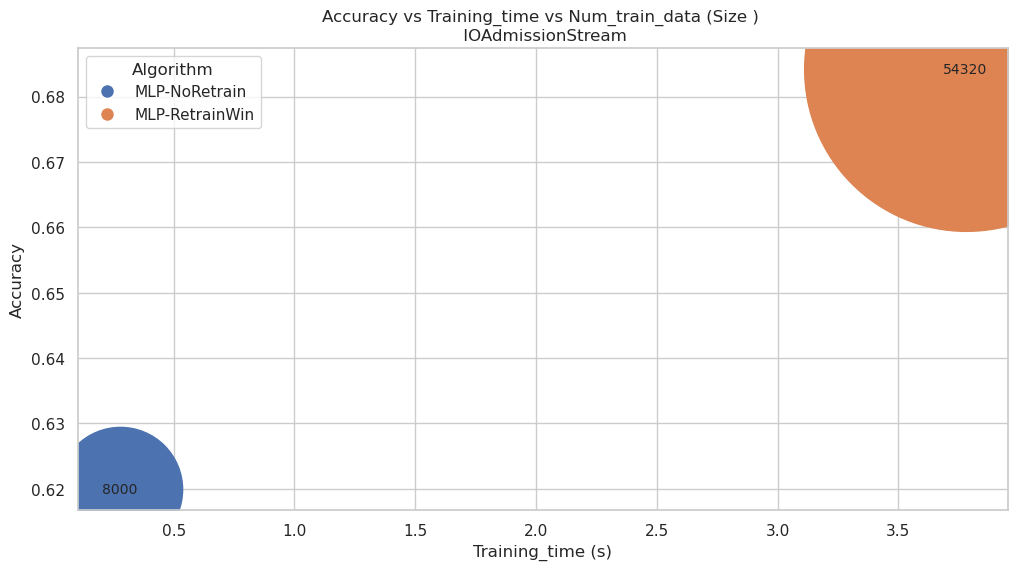

Running MLP-RetrainOne on window 0
FITTING ALWAYS RETRAIN, Memory: 1 Total Train Length: 8000
Training time: 0.297257661819458
Inference time: 0.0085601806640625
Running MLP-RetrainOne on window 1
Accuracy: 0.6955, Inference time: 0.0004553794860839844 
FITTING ALWAYS RETRAIN, Memory: 1 Total Train Length: 8000
Training time: 0.3980553150177002
Running MLP-RetrainOne on window 2
Accuracy: 0.4335, Inference time: 0.0006117820739746094 
FITTING ALWAYS RETRAIN, Memory: 1 Total Train Length: 8000
Training time: 1.802818775177002
Running MLP-RetrainOne on window 3
Accuracy: 0.7635, Inference time: 0.0005738735198974609 
FITTING ALWAYS RETRAIN, Memory: 1 Total Train Length: 8000
Training time: 0.41695070266723633
Running MLP-RetrainOne on window 4
Accuracy: 0.729, Inference time: 0.0005819797515869141 
FITTING ALWAYS RETRAIN, Memory: 1 Total Train Length: 8000
Training time: 0.781494140625
Running MLP-RetrainOne on window 5
Accuracy: 0.612, Inference time: 0.0005691051483154297 
FITTING ALWA

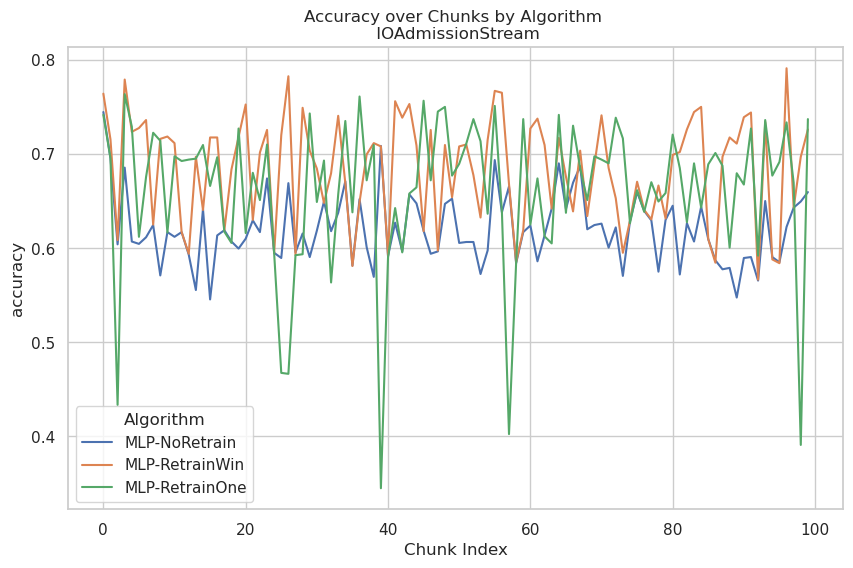

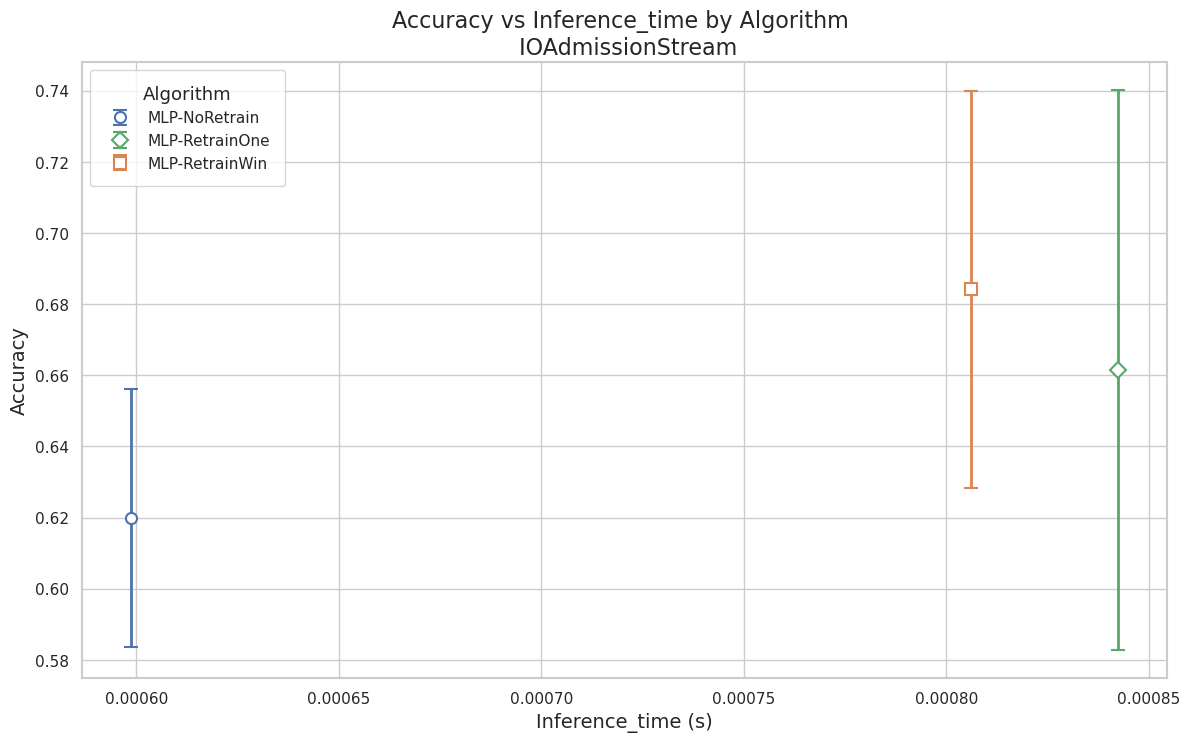

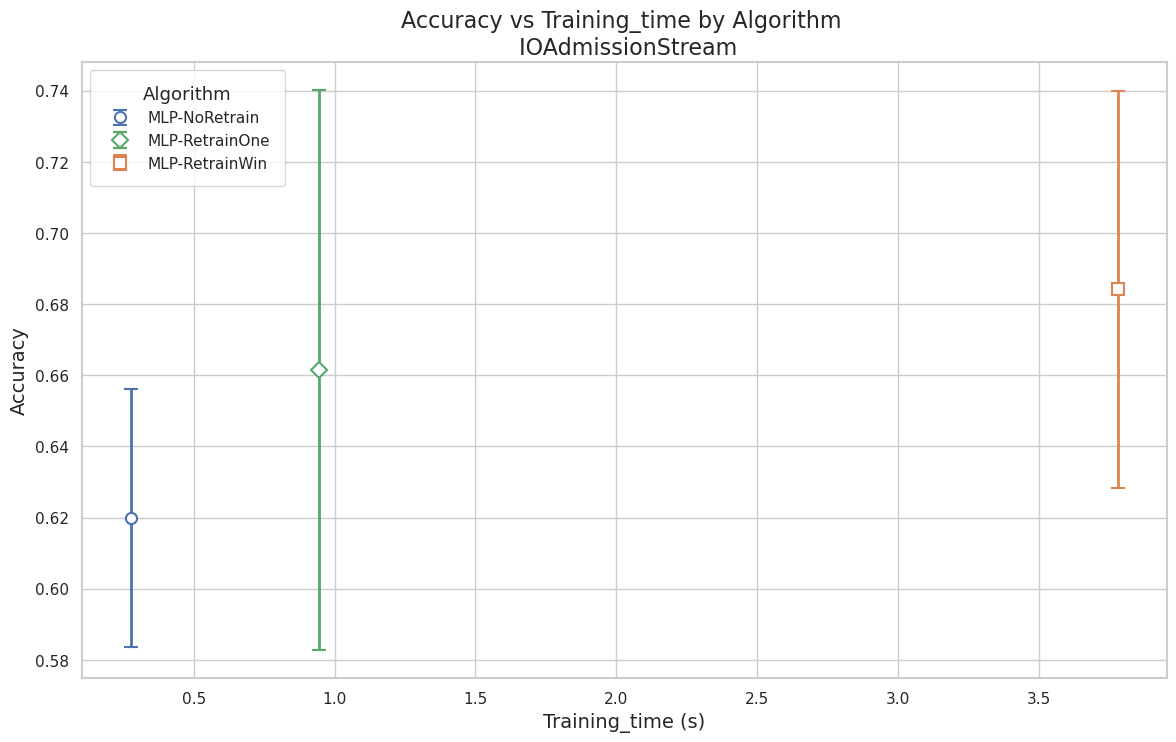

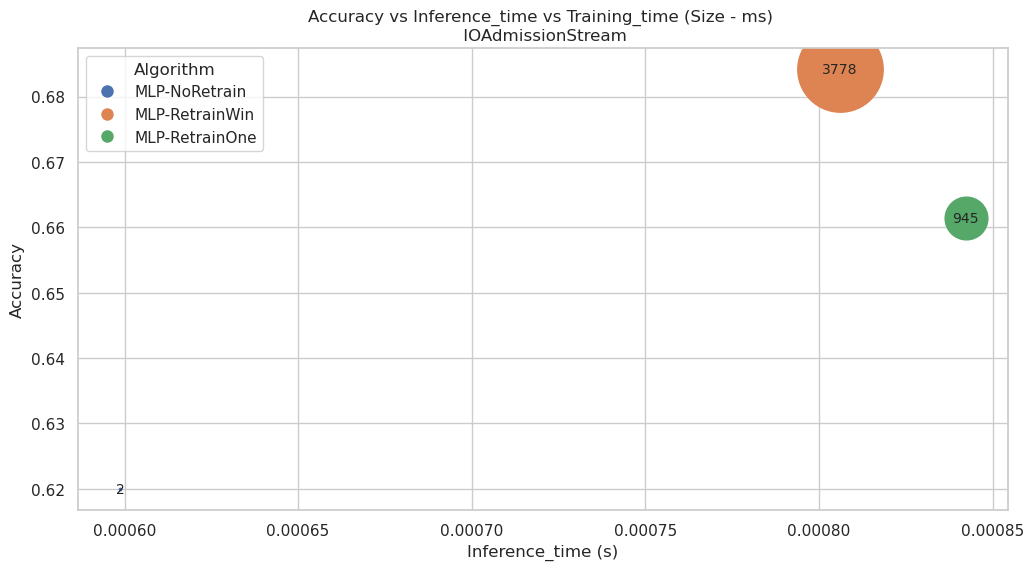

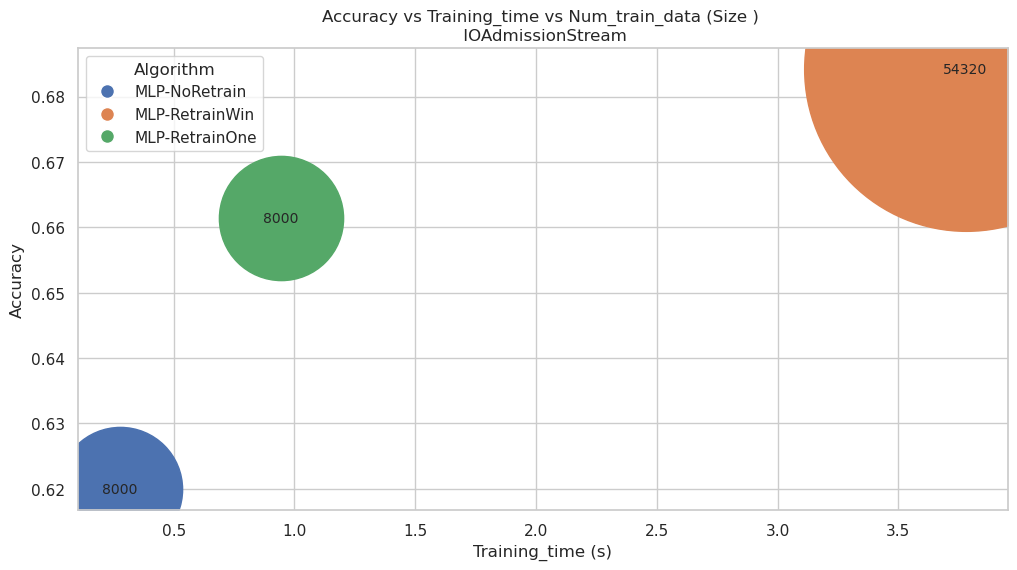

Running MLP-Matchmaker on window 0
Current model zoo length: 1
Training time: 0.48526716232299805
Inference time: 0.011415958404541016
Running MLP-Matchmaker on window 1
Accuracy: 0.735, Inference time: 0.0115509033203125 
Current model zoo length: 2
Training time: 1.0896008014678955
Running MLP-Matchmaker on window 2
Accuracy: 0.6555, Inference time: 0.01382756233215332 
Current model zoo length: 3
Training time: 1.1155579090118408
Running MLP-Matchmaker on window 3
Accuracy: 0.698, Inference time: 0.015133142471313477 
Current model zoo length: 4
Training time: 1.3690848350524902
Running MLP-Matchmaker on window 4
Accuracy: 0.724, Inference time: 0.016288280487060547 
Current model zoo length: 5
Training time: 1.0791456699371338
Running MLP-Matchmaker on window 5
Accuracy: 0.7225, Inference time: 0.017158031463623047 
Current model zoo length: 6
Training time: 2.332733154296875
Running MLP-Matchmaker on window 6
Accuracy: 0.7365, Inference time: 0.01855325698852539 
Current model zoo

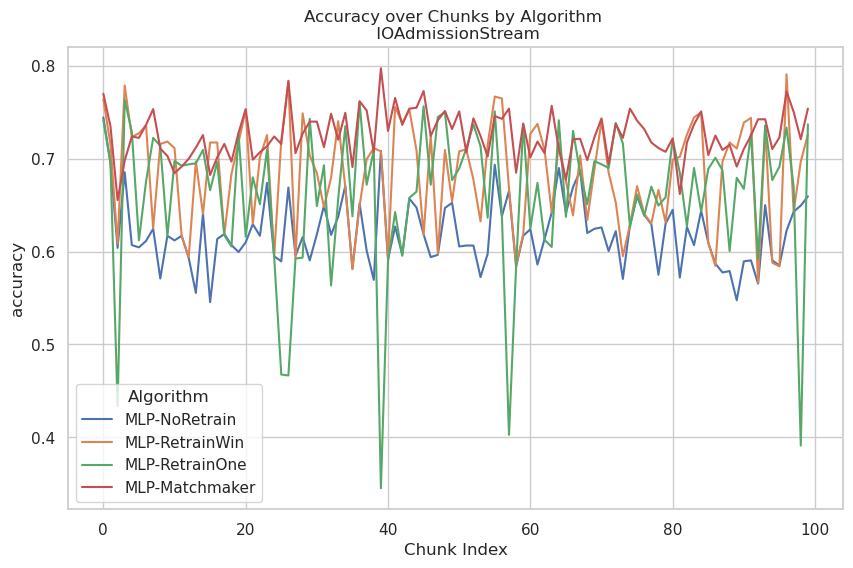

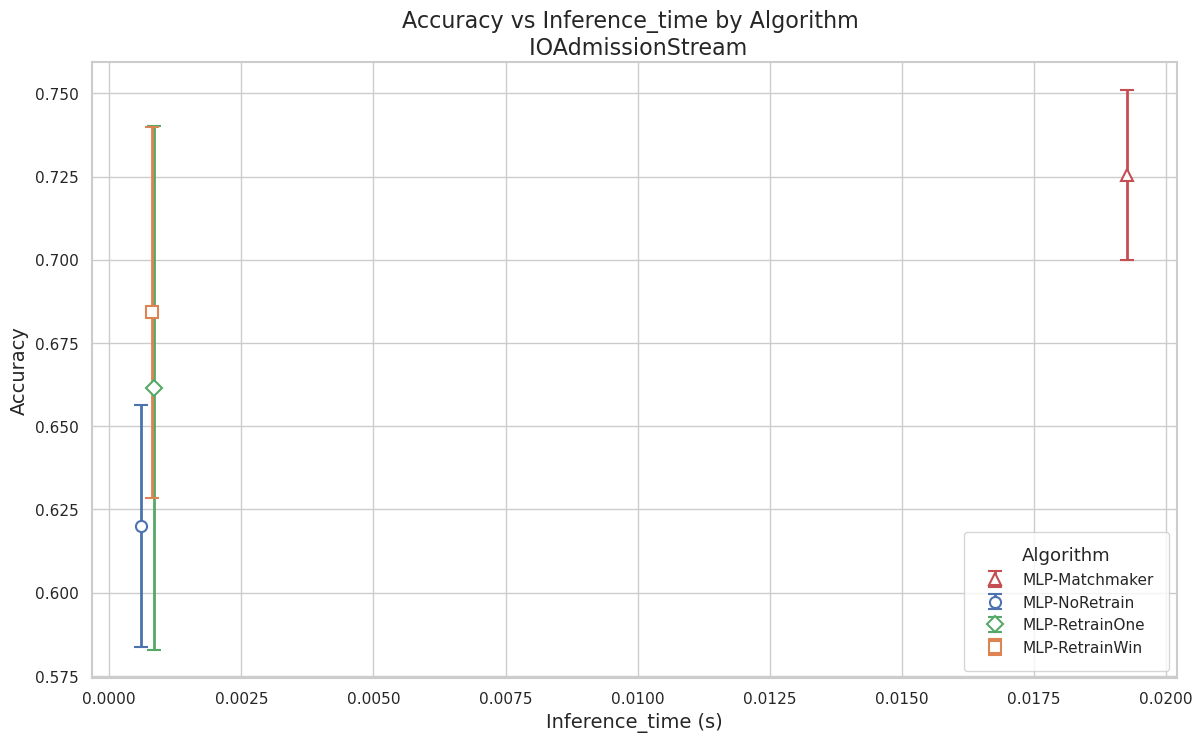

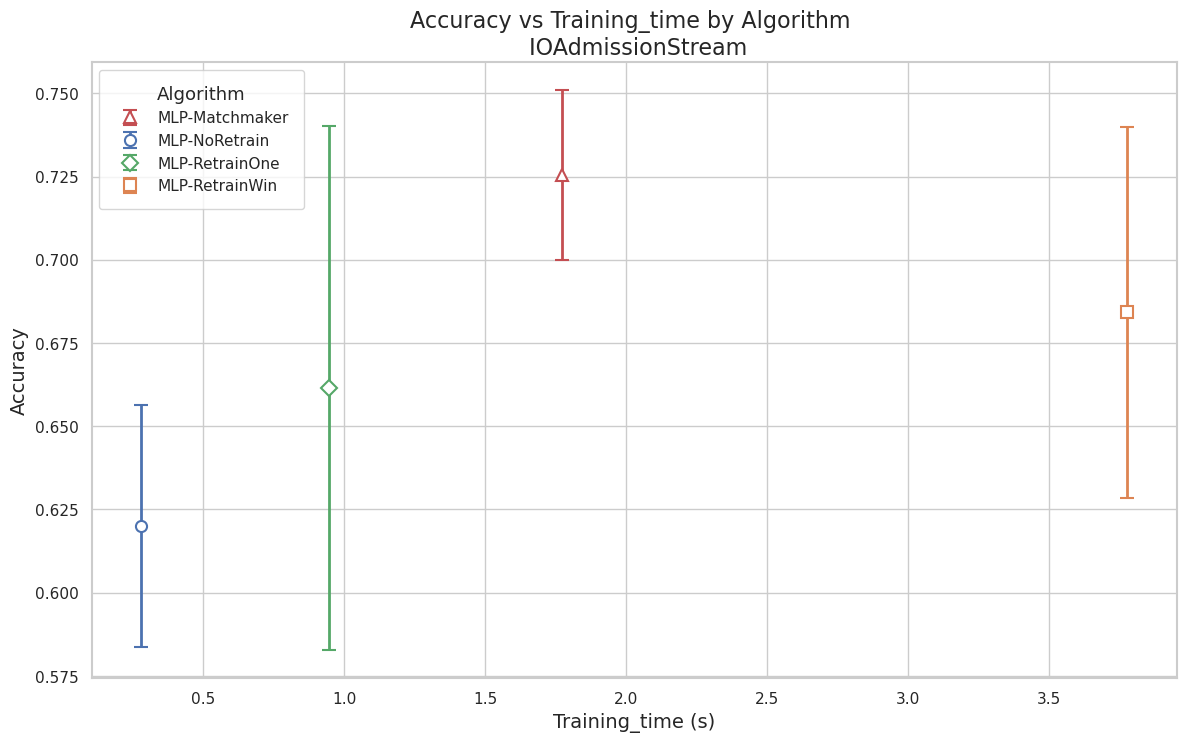

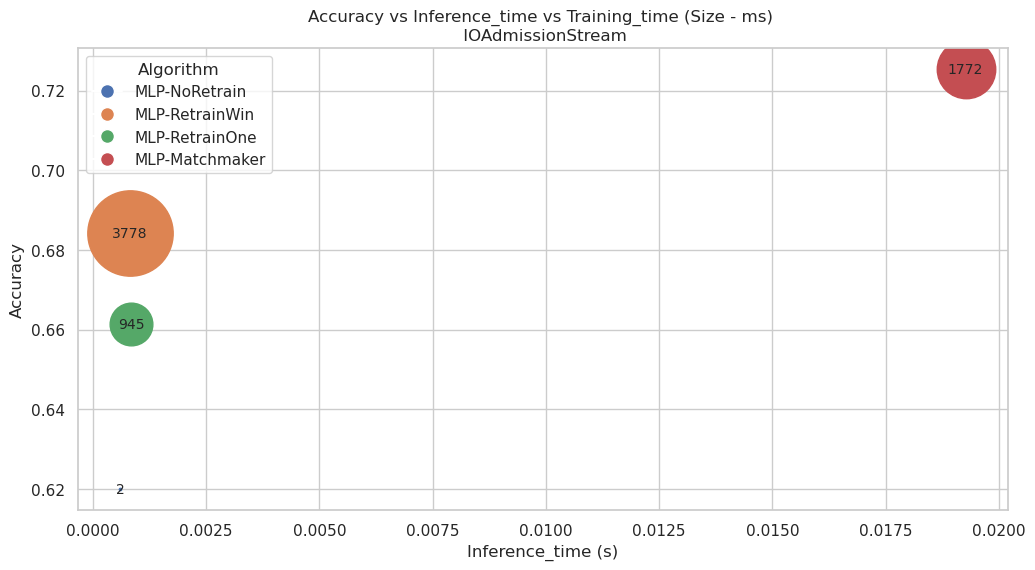

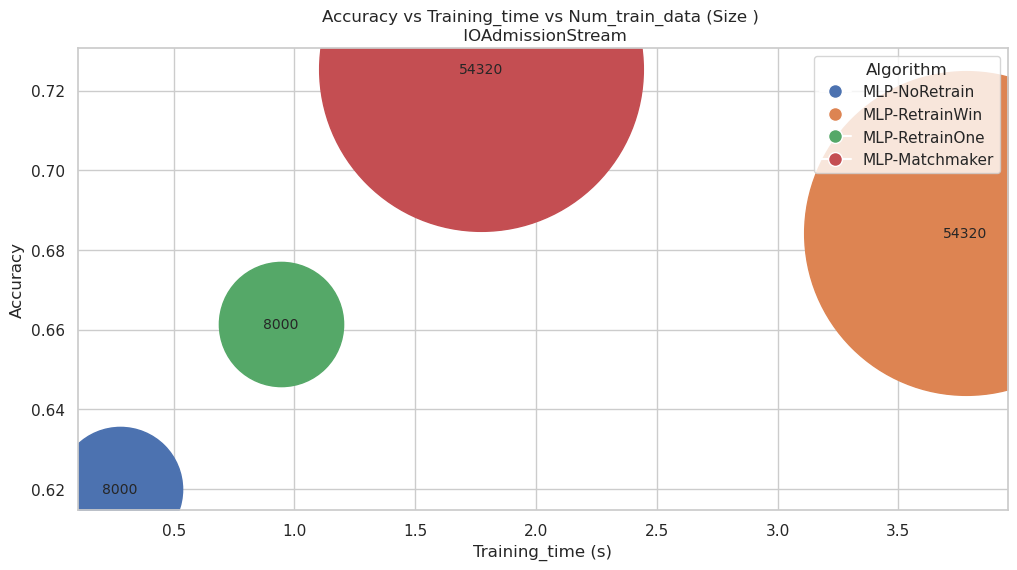

Running MLP-AUE on window 0
Model has 1 classifiers, with weights [4.770338037010206]
Retrained 0 classifiers, comparator: 5.225329687686128
Model has 2 classifiers, with weights [5.287677068473602, 5.1466413709848]
Retrained 1 classifiers, comparator: 5.225329687686128
Training time: 6.2695581912994385
Inference time: 0.0012214183807373047
Running MLP-AUE on window 1
Accuracy: 0.6965, Inference time: 0.0011959075927734375 
Model has 3 classifiers, with weights [4.6090376906562565, 5.1942911410874775, 3.152575845495096]
Retrained 1 classifiers, comparator: 4.680287033228209
Model has 4 classifiers, with weights [4.6090376906562565, 6.690257523432216, 2.3307795312315975, 2.947604082918043]
Retrained 1 classifiers, comparator: 4.680287033228209
Training time: 4.210540533065796
Running MLP-AUE on window 2
Accuracy: 0.568, Inference time: 0.002172231674194336 
Model has 5 classifiers, with weights [3.8562758469563265, 5.948295791339091, 2.3119634153854314, 2.345366492264413, 4.003199080589

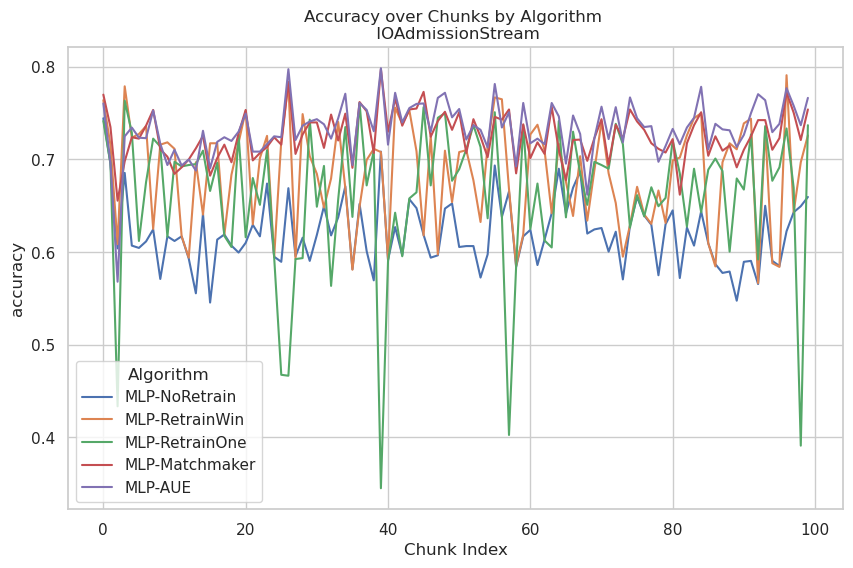

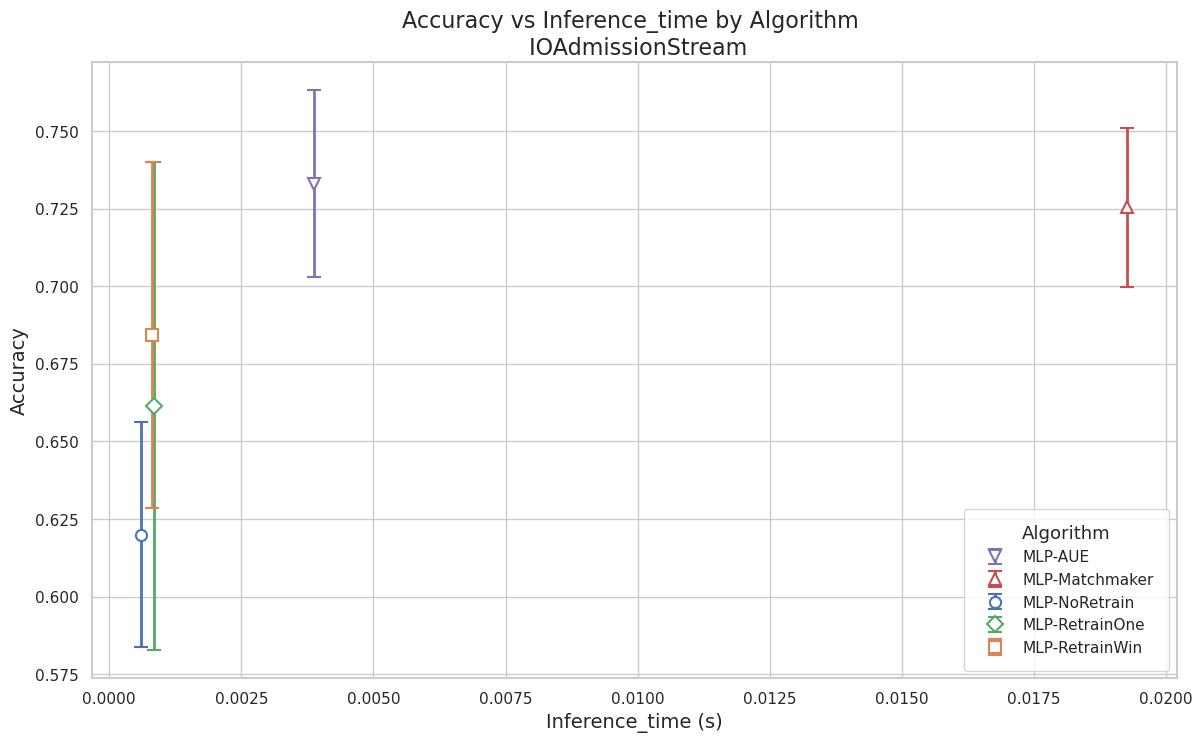

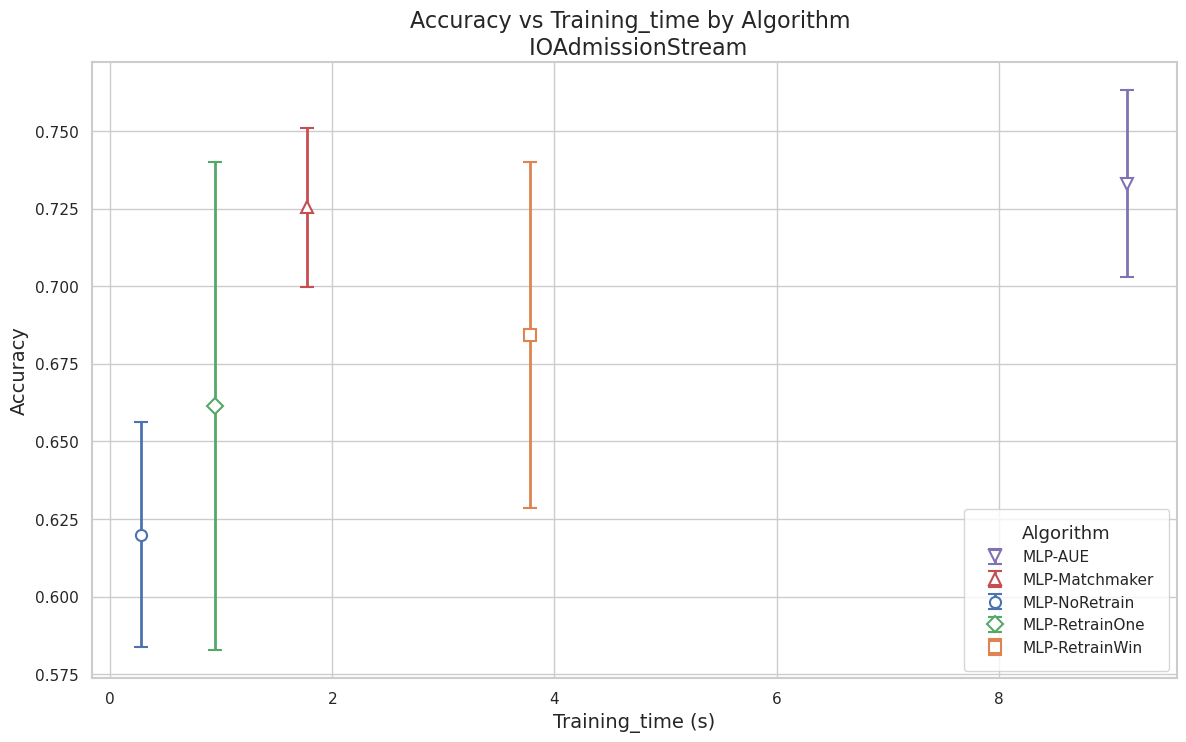

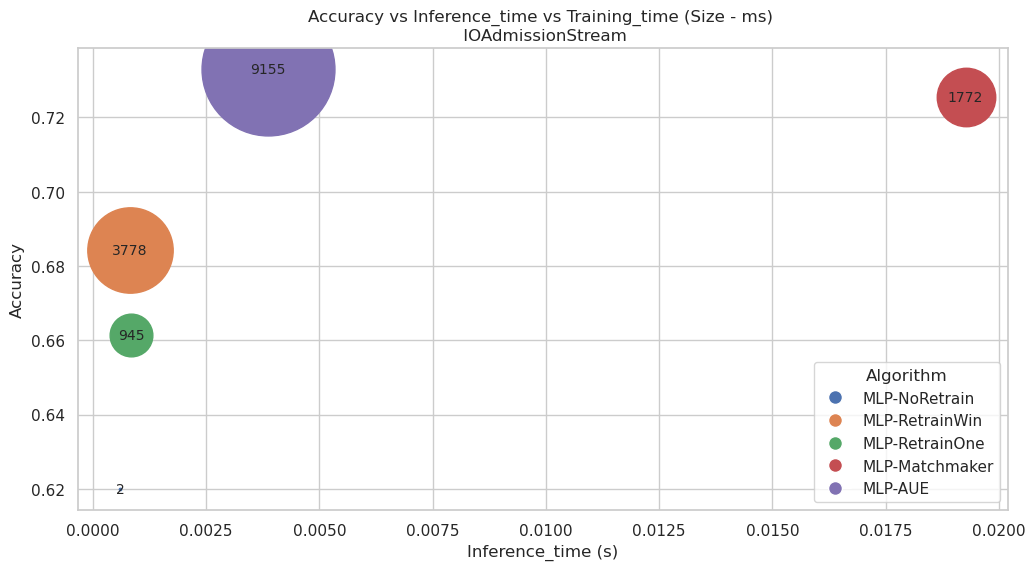

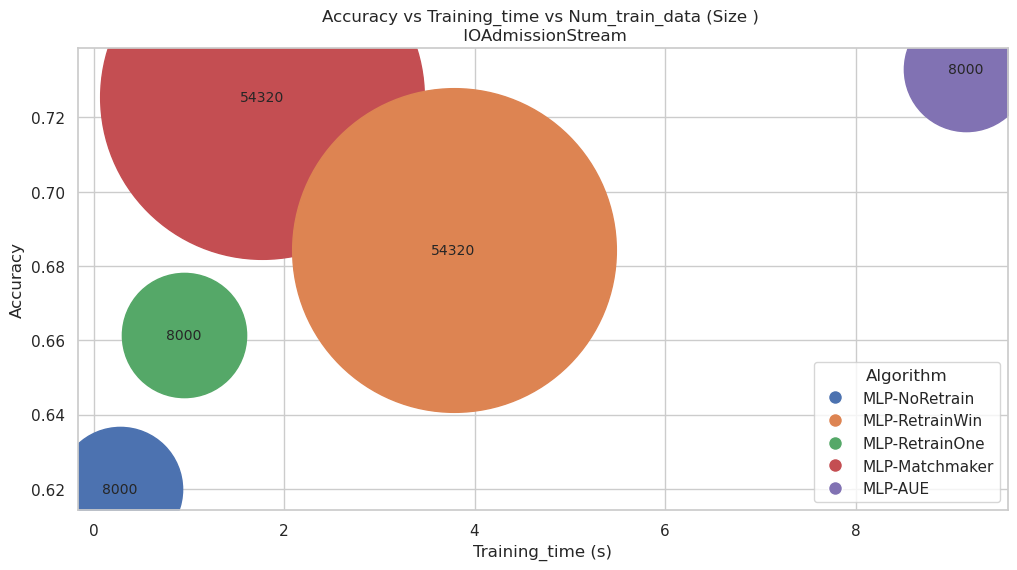

Running MLP-DriftSurf on window 0
Training time: 0.681633472442627
Inference time: 0.0006697177886962891
Running MLP-DriftSurf on window 1
Accuracy: 0.7075, Inference time: 0.0005056858062744141 
DS Iteration 1, acc: 0.704625
DriftSurf State: stab, Best Accuracy: 0.704625, Current Model: pred
Training time: 4.012401342391968
Running MLP-DriftSurf on window 2
Accuracy: 0.6865, Inference time: 0.0006597042083740234 
DS Iteration 2, acc: 0.704875
DriftSurf State: stab, Best Accuracy: 0.704875, Current Model: pred
Training time: 4.923713684082031
Running MLP-DriftSurf on window 3
Accuracy: 0.705, Inference time: 0.0007345676422119141 
DS Iteration 3, acc: 0.703125
DriftSurf State: stab, Best Accuracy: 0.704875, Current Model: pred
Training time: 2.3242619037628174
Running MLP-DriftSurf on window 4
Accuracy: 0.648, Inference time: 0.0009877681732177734 
DS Iteration 4, acc: 0.642875
Entering reactive state
DriftSurf State: reac, Best Accuracy: 0.704875, Current Model: pred
Training time: 3.

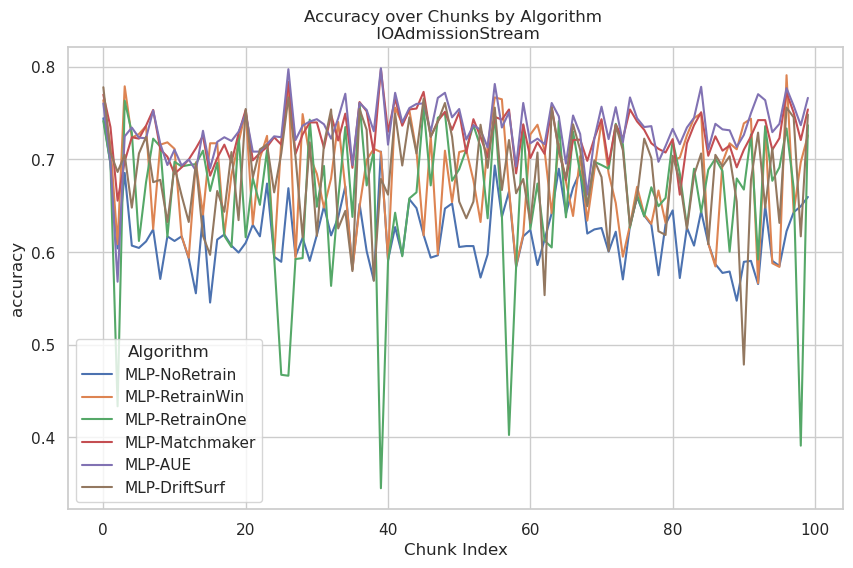

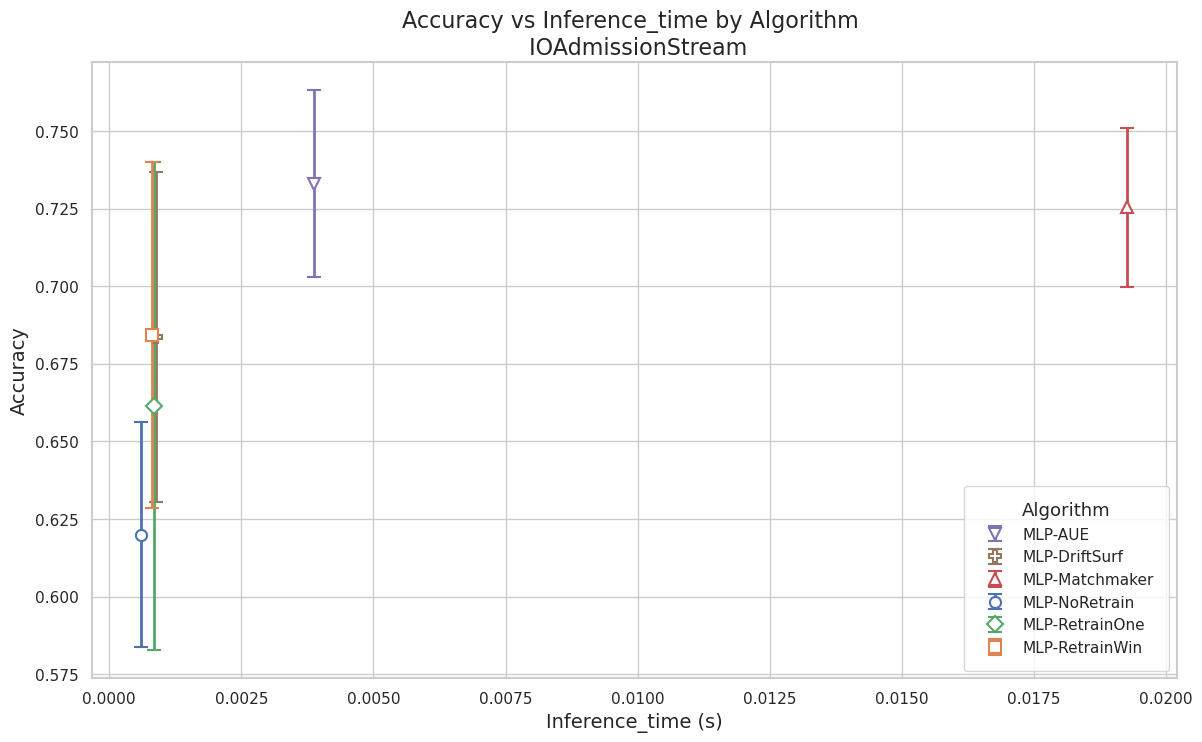

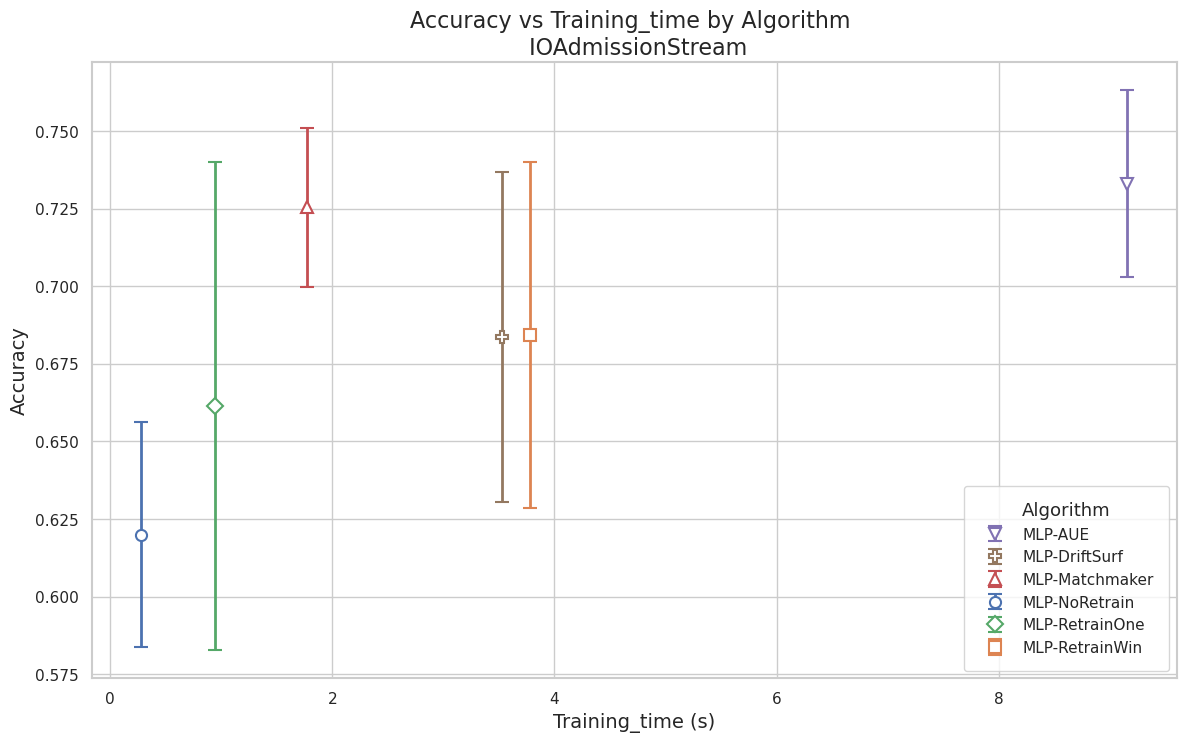

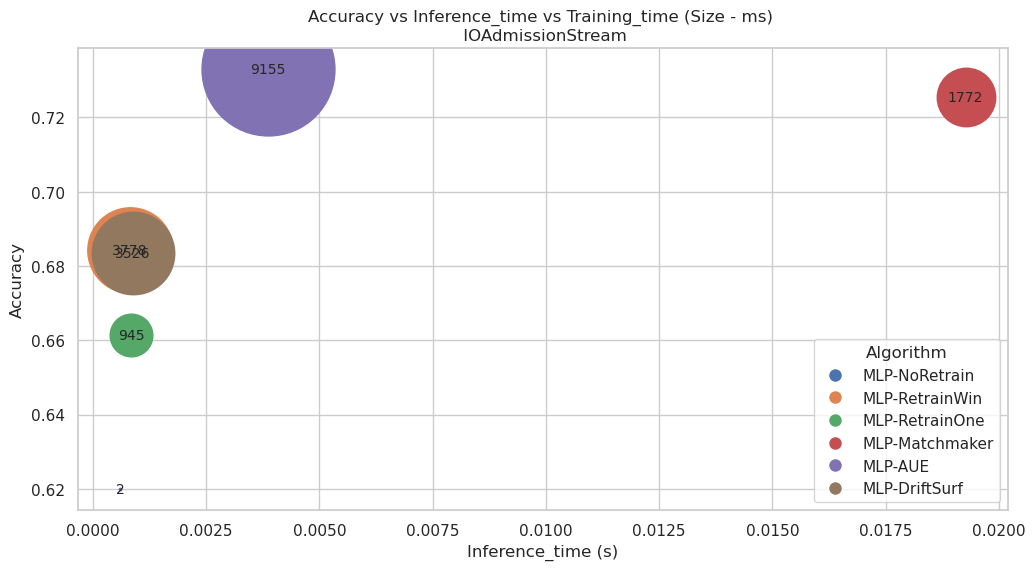

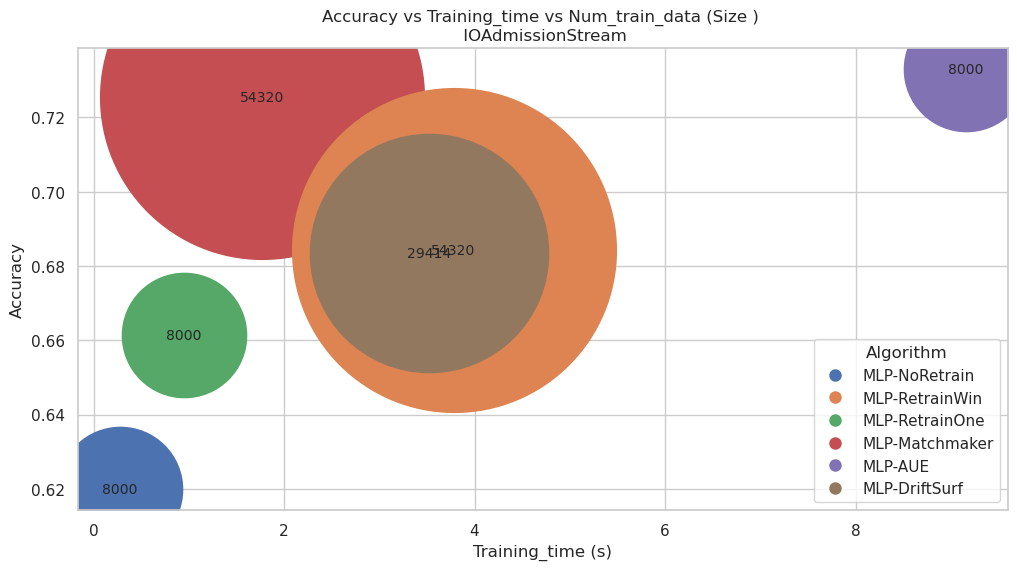

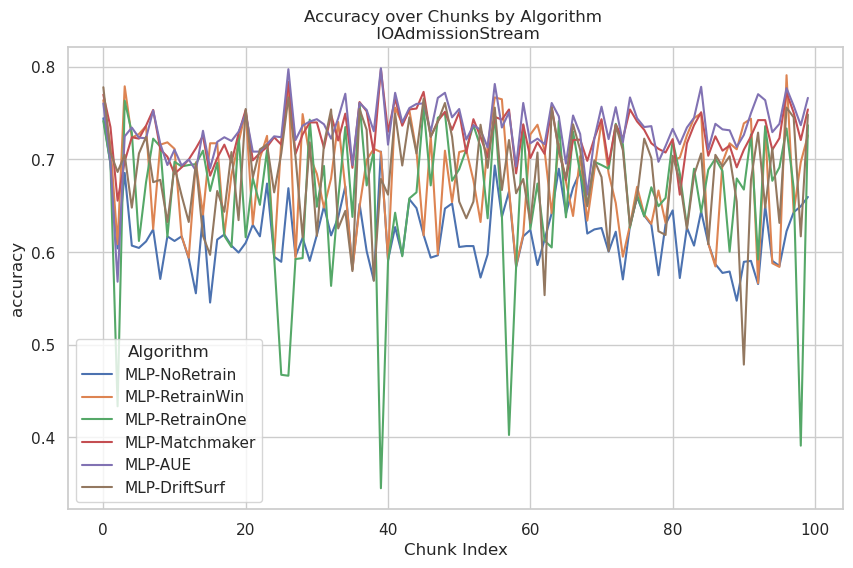

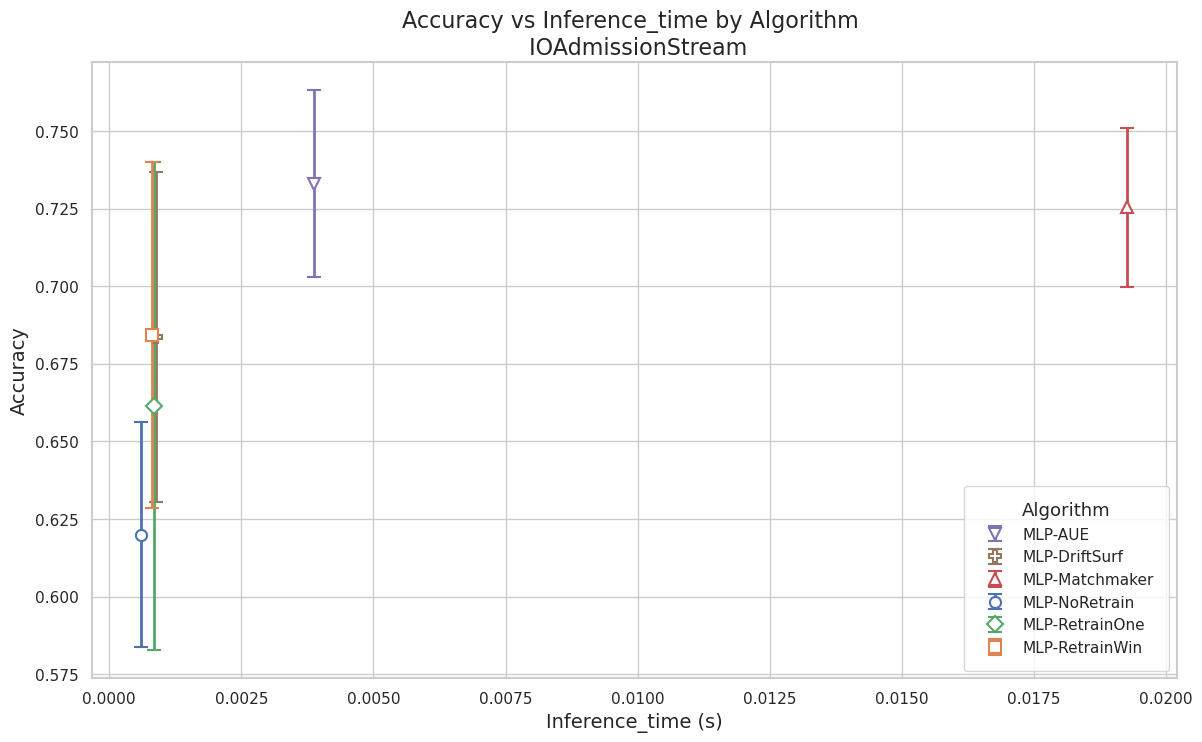

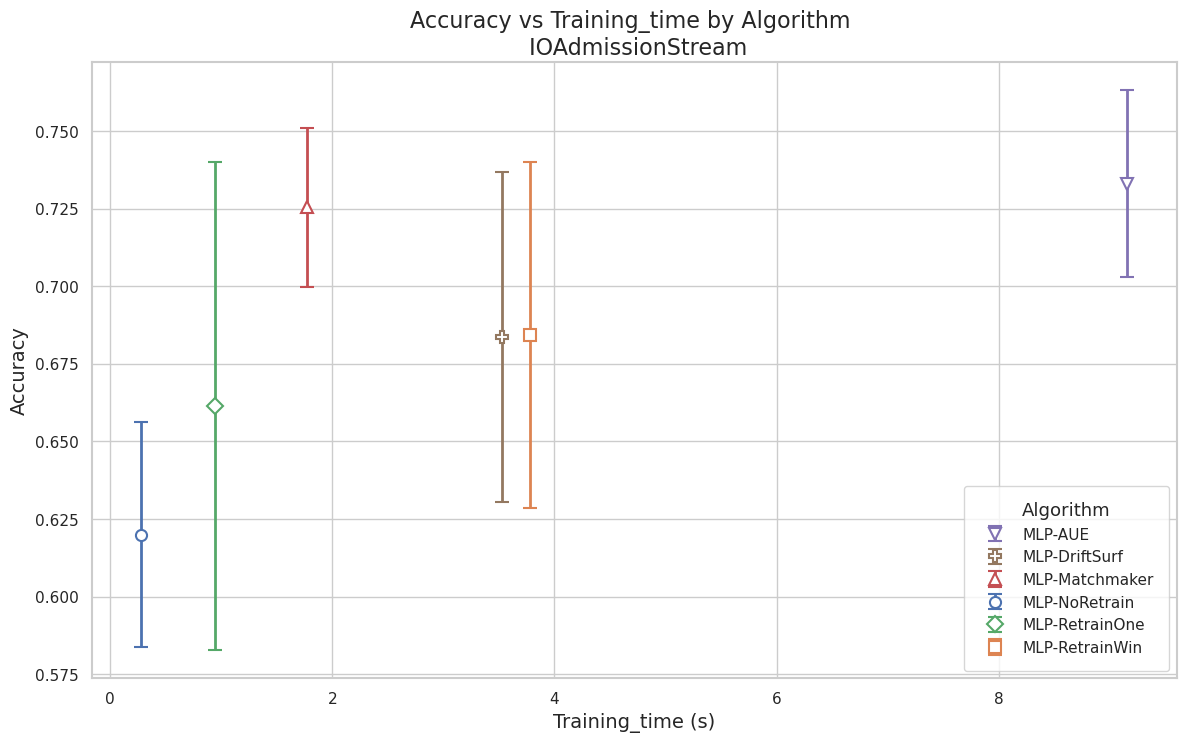

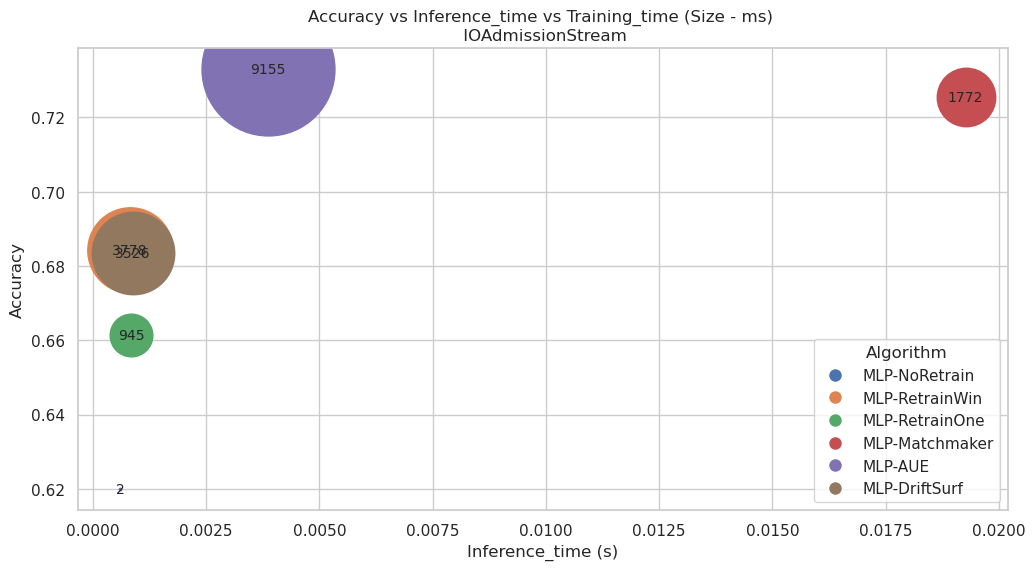

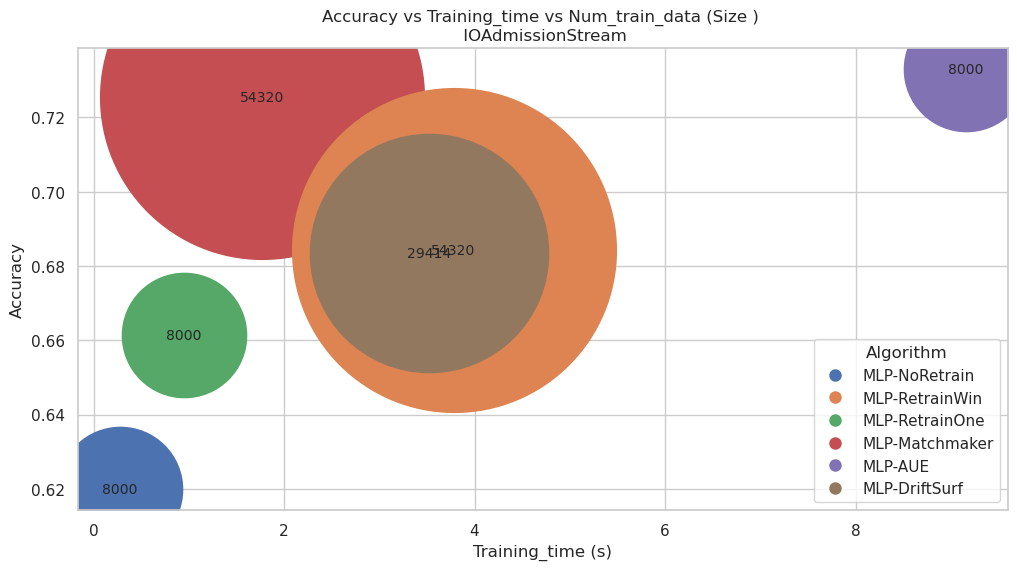

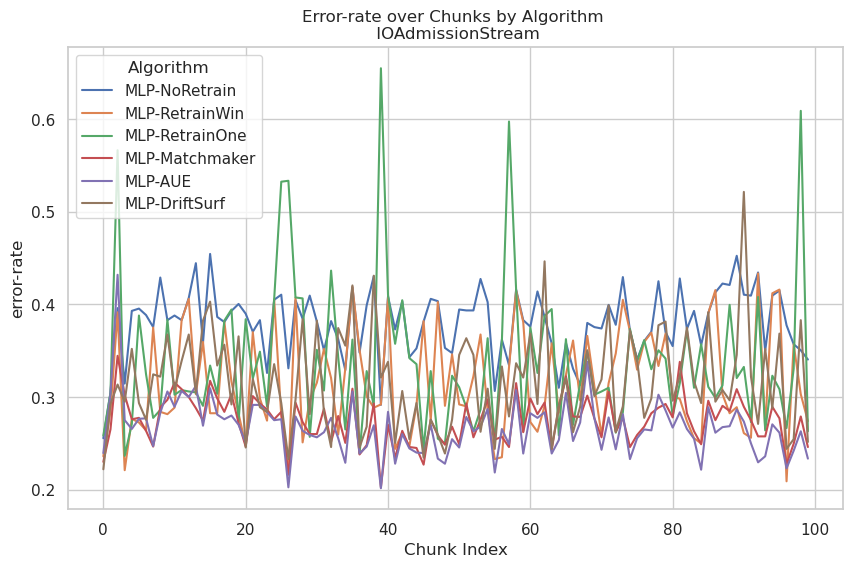

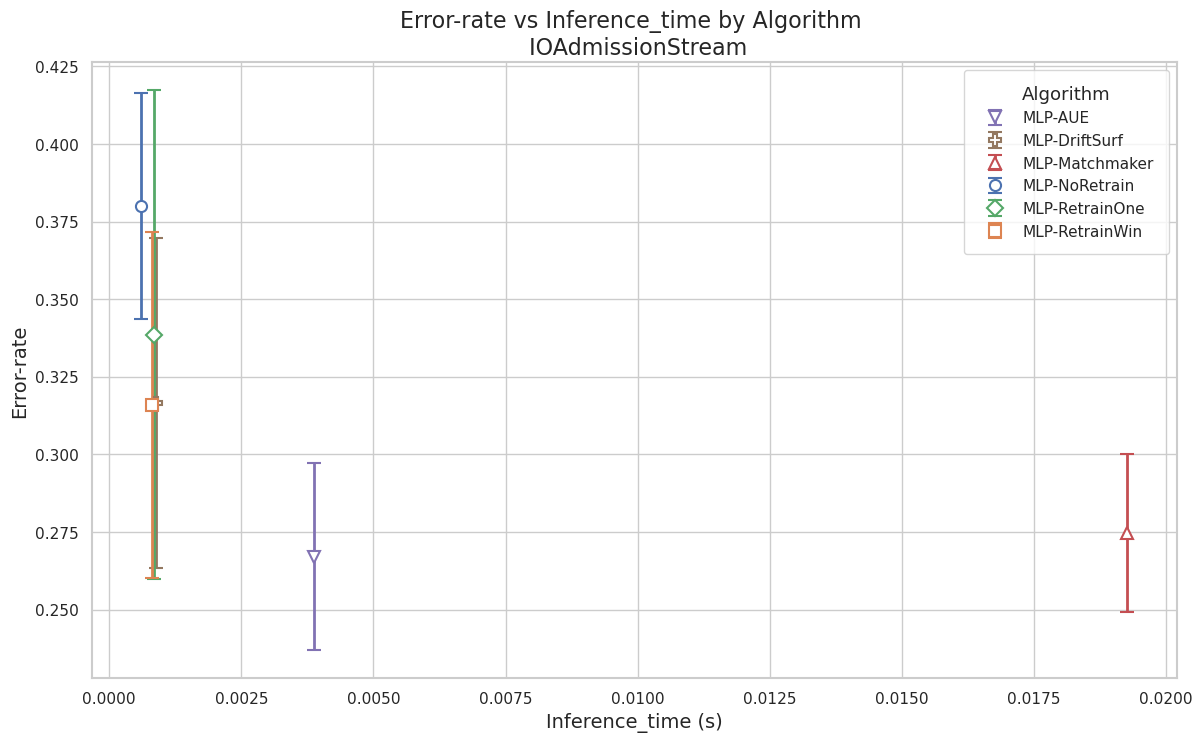

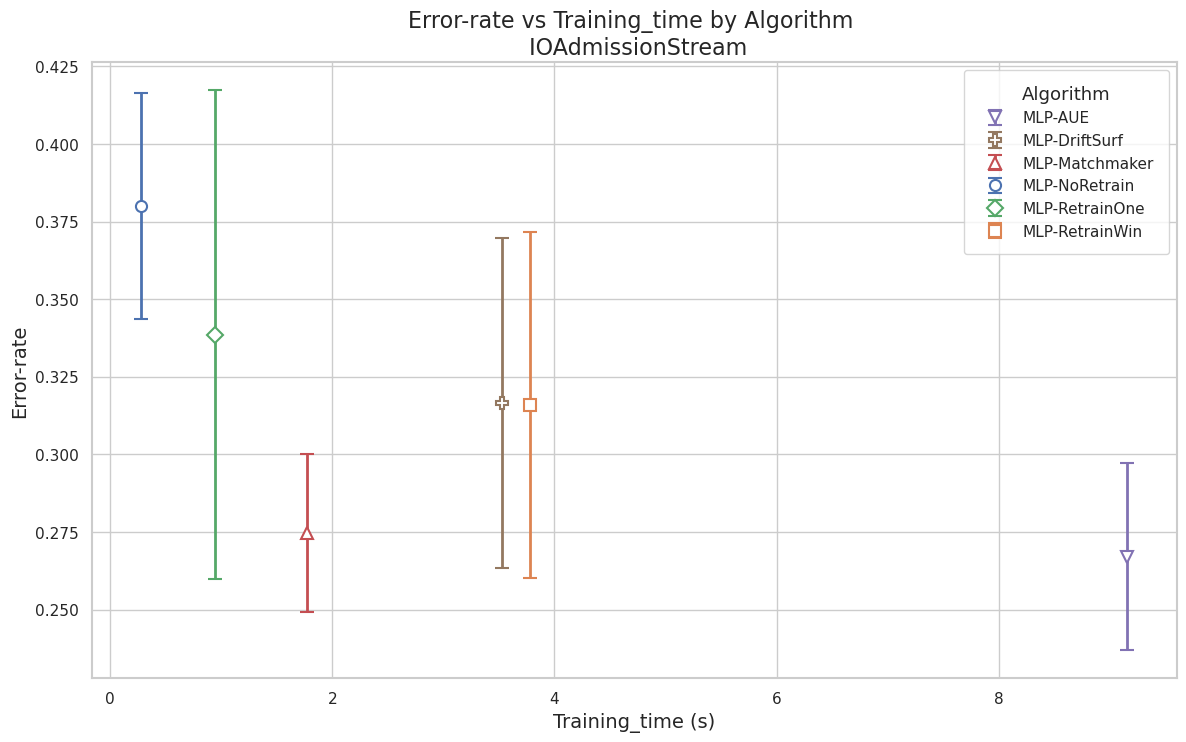

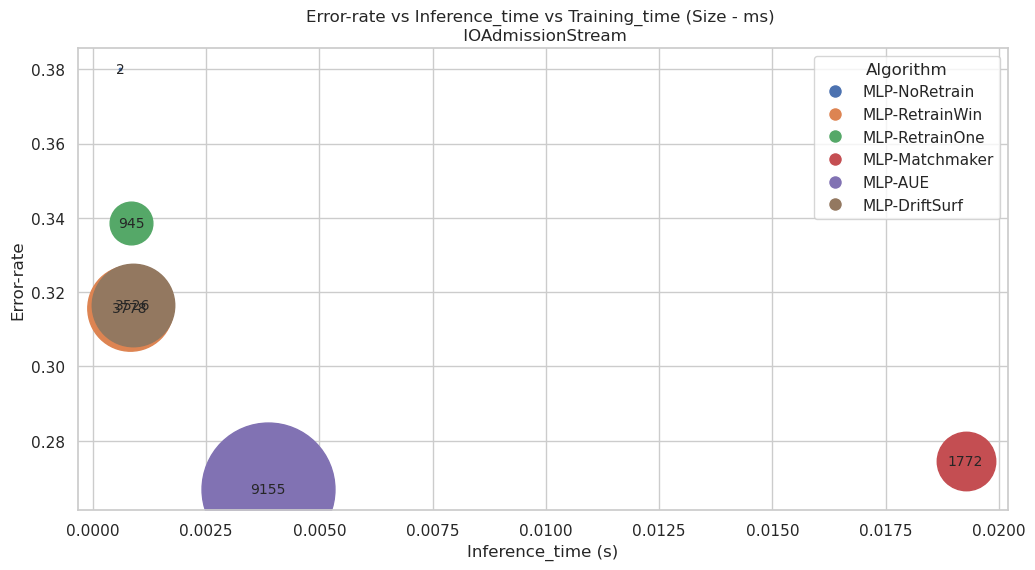

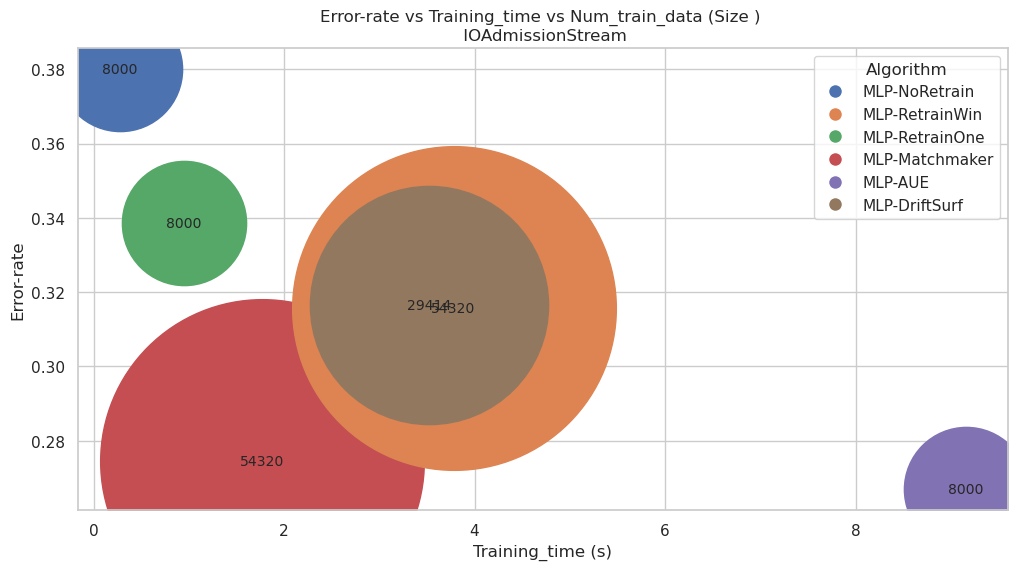

In [52]:
pipeline_io = Pipeline(dataset_name="IOAdmissionStream", data_stream=io_admission, algorithms=algorithms, drift_detector=AlwaysDriftDetector(), metric_evaluator=MetricEvaluator())
results_io = pipeline_io.run()
pipeline_io.plot_results()

Running MLP-NoRetrain on window 0
TOTAL TRAIN LENGTH 800
Training time: 0.8142030239105225
Inference time: 0.0007719993591308594
Running MLP-NoRetrain on window 1
Accuracy: 0.96, Inference time: 0.0005931854248046875 
Training time: 3.0994415283203125e-06
Running MLP-NoRetrain on window 2
Accuracy: 0.985, Inference time: 0.00039458274841308594 
Training time: 3.0994415283203125e-06
Running MLP-NoRetrain on window 3
Accuracy: 0.985, Inference time: 0.00039839744567871094 
Training time: 2.6226043701171875e-06
Running MLP-NoRetrain on window 4
Accuracy: 0.98, Inference time: 0.0003688335418701172 
Training time: 2.384185791015625e-06
Running MLP-NoRetrain on window 5
Accuracy: 0.965, Inference time: 0.00045037269592285156 
Training time: 2.6226043701171875e-06
Running MLP-NoRetrain on window 6
Accuracy: 0.985, Inference time: 0.00034618377685546875 
Training time: 2.6226043701171875e-06
Running MLP-NoRetrain on window 7
Accuracy: 0.98, Inference time: 0.0004639625549316406 
Training time

<ipython-input-8-551e37e6f975>:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.results[dataset_name] = self.results[dataset_name]._append({


Running MLP-NoRetrain on window 16
Accuracy: 0.98, Inference time: 0.0005142688751220703 
Training time: 2.6226043701171875e-06
Running MLP-NoRetrain on window 17
Accuracy: 0.975, Inference time: 0.0004074573516845703 
Training time: 2.6226043701171875e-06
Running MLP-NoRetrain on window 18
Accuracy: 0.99, Inference time: 0.0004680156707763672 
Training time: 2.86102294921875e-06
Running MLP-NoRetrain on window 19
Accuracy: 0.96, Inference time: 0.00038695335388183594 
Training time: 2.6226043701171875e-06
Running MLP-NoRetrain on window 20
Accuracy: 0.995, Inference time: 0.0004849433898925781 
Training time: 2.6226043701171875e-06
Running MLP-NoRetrain on window 21
Accuracy: 0.97, Inference time: 0.00044608116149902344 
Training time: 2.384185791015625e-06
Running MLP-NoRetrain on window 22
Accuracy: 0.995, Inference time: 0.001171112060546875 
Training time: 2.384185791015625e-06
Running MLP-NoRetrain on window 23
Accuracy: 0.98, Inference time: 0.00045228004455566406 
Training time

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Training time: 0.9380125999450684
Running MLP-RetrainOne on window 15
Accuracy: 0.985, Inference time: 0.0003409385681152344 
FITTING ALWAYS RETRAIN, Memory: 1 Total Train Length: 800
Training time: 0.48804187774658203
Running MLP-RetrainOne on window 16
Accuracy: 0.96, Inference time: 0.00043773651123046875 
FITTING ALWAYS RETRAIN, Memory: 1 Total Train Length: 800
Training time: 0.41495776176452637
Running MLP-RetrainOne on window 17
Accuracy: 0.98, Inference time: 0.0004849433898925781 
FITTING ALWAYS RETRAIN, Memory: 1 Total Train Length: 800
Training time: 0.6625068187713623
Running MLP-RetrainOne on window 18
Accuracy: 0.97, Inference time: 0.0004260540008544922 
FITTING ALWAYS RETRAIN, Memory: 1 Total Train Length: 800
Training time: 0.47385740280151367
Running MLP-RetrainOne on window 19
Accuracy: 0.965, Inference time: 0.00040984153747558594 
FITTING ALWAYS RETRAIN, Memory: 1 Total Train Length: 800
Training time: 0.2612905502319336
Running MLP-RetrainOne on window 20
Accuracy

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Training time: 0.9768152236938477
Running MLP-RetrainOne on window 40
Accuracy: 0.995, Inference time: 0.0003154277801513672 
FITTING ALWAYS RETRAIN, Memory: 1 Total Train Length: 800
Training time: 0.5672025680541992
Running MLP-RetrainOne on window 41
Accuracy: 0.985, Inference time: 0.00035762786865234375 
FITTING ALWAYS RETRAIN, Memory: 1 Total Train Length: 800
Training time: 0.629051923751831
Running MLP-RetrainOne on window 42
Accuracy: 0.995, Inference time: 0.00036454200744628906 
FITTING ALWAYS RETRAIN, Memory: 1 Total Train Length: 800
Training time: 0.4514310359954834
Running MLP-RetrainOne on window 43
Accuracy: 0.99, Inference time: 0.000308990478515625 
FITTING ALWAYS RETRAIN, Memory: 1 Total Train Length: 800
Training time: 0.545393705368042
Running MLP-RetrainOne on window 44
Accuracy: 0.985, Inference time: 0.0003490447998046875 
FITTING ALWAYS RETRAIN, Memory: 1 Total Train Length: 800
Training time: 0.694709062576294
Running MLP-RetrainOne on window 45
Accuracy: 0.9

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Training time: 0.943387508392334
Running MLP-RetrainOne on window 49
Accuracy: 0.98, Inference time: 0.00033354759216308594 
FITTING ALWAYS RETRAIN, Memory: 1 Total Train Length: 800
Training time: 0.5823640823364258
Running MLP-RetrainOne on window 50
Accuracy: 0.975, Inference time: 0.00031280517578125 
FITTING ALWAYS RETRAIN, Memory: 1 Total Train Length: 800
Training time: 0.5195989608764648
Running MLP-RetrainOne on window 51
Accuracy: 0.955, Inference time: 0.0005002021789550781 
FITTING ALWAYS RETRAIN, Memory: 1 Total Train Length: 800


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Training time: 0.9480626583099365
Running MLP-RetrainOne on window 52
Accuracy: 0.955, Inference time: 0.00041031837463378906 
FITTING ALWAYS RETRAIN, Memory: 1 Total Train Length: 800
Training time: 0.7294268608093262
Running MLP-RetrainOne on window 53
Accuracy: 0.945, Inference time: 0.00040221214294433594 
FITTING ALWAYS RETRAIN, Memory: 1 Total Train Length: 800
Training time: 1.0120773315429688
Running MLP-RetrainOne on window 54
Accuracy: 0.93, Inference time: 0.0004150867462158203 
FITTING ALWAYS RETRAIN, Memory: 1 Total Train Length: 800
Training time: 1.2849066257476807
Running MLP-RetrainOne on window 55
Accuracy: 0.935, Inference time: 0.0004291534423828125 
FITTING ALWAYS RETRAIN, Memory: 1 Total Train Length: 800
Training time: 1.288447618484497
Running MLP-RetrainOne on window 56
Accuracy: 0.99, Inference time: 0.000335693359375 
FITTING ALWAYS RETRAIN, Memory: 1 Total Train Length: 800
Training time: 0.29711008071899414
Running MLP-RetrainOne on window 57
Accuracy: 0.99

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Training time: 0.9323720932006836
Running MLP-RetrainOne on window 60
Accuracy: 0.985, Inference time: 0.0003650188446044922 
FITTING ALWAYS RETRAIN, Memory: 1 Total Train Length: 800
Training time: 0.5476081371307373
Running MLP-RetrainOne on window 61
Accuracy: 0.99, Inference time: 0.0002999305725097656 
FITTING ALWAYS RETRAIN, Memory: 1 Total Train Length: 800
Training time: 0.5735514163970947
Running MLP-RetrainOne on window 62
Accuracy: 0.915, Inference time: 0.0005044937133789062 
FITTING ALWAYS RETRAIN, Memory: 1 Total Train Length: 800
Training time: 0.7955653667449951
Running MLP-RetrainOne on window 63
Accuracy: 0.98, Inference time: 0.0003314018249511719 
FITTING ALWAYS RETRAIN, Memory: 1 Total Train Length: 800
Training time: 0.8511354923248291
Running MLP-RetrainOne on window 64
Accuracy: 0.975, Inference time: 0.00033092498779296875 
FITTING ALWAYS RETRAIN, Memory: 1 Total Train Length: 800
Training time: 0.8589391708374023
Running MLP-RetrainOne on window 65
Accuracy: 0

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Training time: 0.951744794845581
Running MLP-RetrainOne on window 87
Accuracy: 0.99, Inference time: 0.0003294944763183594 
FITTING ALWAYS RETRAIN, Memory: 1 Total Train Length: 800
Training time: 0.4476349353790283
Running MLP-RetrainOne on window 88
Accuracy: 0.975, Inference time: 0.00036978721618652344 
FITTING ALWAYS RETRAIN, Memory: 1 Total Train Length: 800
Training time: 0.4430994987487793
Running MLP-RetrainOne on window 89
Accuracy: 0.98, Inference time: 0.00034165382385253906 
FITTING ALWAYS RETRAIN, Memory: 1 Total Train Length: 800
Training time: 0.5946412086486816
Running MLP-RetrainOne on window 90
Accuracy: 0.99, Inference time: 0.0006780624389648438 
FITTING ALWAYS RETRAIN, Memory: 1 Total Train Length: 800
Training time: 0.5182268619537354
Running MLP-RetrainOne on window 91
Accuracy: 0.99, Inference time: 0.000316619873046875 
FITTING ALWAYS RETRAIN, Memory: 1 Total Train Length: 800
Training time: 0.44855356216430664
Running MLP-RetrainOne on window 92
Accuracy: 0.9

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Training time: 1.1891262531280518
Running MLP-RetrainOne on window 94
Accuracy: 0.99, Inference time: 0.0004303455352783203 
FITTING ALWAYS RETRAIN, Memory: 1 Total Train Length: 800
Training time: 0.6377599239349365
Running MLP-RetrainOne on window 95
Accuracy: 1.0, Inference time: 0.000438690185546875 
FITTING ALWAYS RETRAIN, Memory: 1 Total Train Length: 800
Training time: 0.9185655117034912
Running MLP-RetrainOne on window 96
Accuracy: 0.99, Inference time: 0.0004775524139404297 
FITTING ALWAYS RETRAIN, Memory: 1 Total Train Length: 800
Training time: 0.9038529396057129
Running MLP-RetrainOne on window 97
Accuracy: 0.99, Inference time: 0.00042557716369628906 
FITTING ALWAYS RETRAIN, Memory: 1 Total Train Length: 800
Training time: 0.622556209564209
Running MLP-RetrainOne on window 98
Accuracy: 0.99, Inference time: 0.000354766845703125 
FITTING ALWAYS RETRAIN, Memory: 1 Total Train Length: 800
Training time: 0.3958613872528076
Running MLP-RetrainOne on window 99
Accuracy: 1.0, Inf

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Current model zoo length: 7
Training time: 0.9761931896209717
Running MLP-Matchmaker on window 11
Accuracy: 0.95, Inference time: 0.004687070846557617 
Current model zoo length: 7
Training time: 0.6707587242126465
Running MLP-Matchmaker on window 12
Accuracy: 0.975, Inference time: 0.0026869773864746094 
Current model zoo length: 7
Training time: 0.8495488166809082
Running MLP-Matchmaker on window 13
Accuracy: 0.99, Inference time: 0.0027930736541748047 
Current model zoo length: 7
Training time: 0.36486291885375977
Running MLP-Matchmaker on window 14
Accuracy: 0.995, Inference time: 0.002771615982055664 
Current model zoo length: 7
Training time: 0.6651632785797119
Running MLP-Matchmaker on window 15
Accuracy: 0.98, Inference time: 0.002728700637817383 
Current model zoo length: 7
Training time: 0.6868021488189697
Running MLP-Matchmaker on window 16
Accuracy: 0.985, Inference time: 0.0028209686279296875 
Current model zoo length: 7
Training time: 0.9413352012634277
Running MLP-Matchma

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Current model zoo length: 7
Training time: 1.6591784954071045
Running MLP-Matchmaker on window 60
Accuracy: 0.985, Inference time: 0.004824399948120117 
Current model zoo length: 7
Training time: 1.294203519821167
Running MLP-Matchmaker on window 61
Accuracy: 0.97, Inference time: 0.002718210220336914 
Current model zoo length: 7
Training time: 0.9196605682373047
Running MLP-Matchmaker on window 62
Accuracy: 0.995, Inference time: 0.002681732177734375 
Current model zoo length: 7
Training time: 0.598203182220459
Running MLP-Matchmaker on window 63
Accuracy: 0.99, Inference time: 0.002941608428955078 
Current model zoo length: 7
Training time: 0.5476727485656738
Running MLP-Matchmaker on window 64
Accuracy: 1.0, Inference time: 0.0026481151580810547 
Current model zoo length: 7
Training time: 1.0394396781921387
Running MLP-Matchmaker on window 65
Accuracy: 1.0, Inference time: 0.0028548240661621094 
Current model zoo length: 7
Training time: 0.7159011363983154
Running MLP-Matchmaker on 

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 4 classifiers, with weights [66.00779821689167, 77.01367688853264, 54.249881398237875, 56.16026695148819]
Retrained 3 classifiers, comparator: 4.796486573584849
Training time: 3.869100332260132
Running MLP-AUE on window 2
Accuracy: 0.99, Inference time: 0.0011303424835205078 
Model has 5 classifiers, with weights [79.80068455507195, 81.4368032858846, 60.50423471805719, 41.43959596264778, 11.36637000232447]
Retrained 4 classifiers, comparator: 4.856726566294317
Model has 6 classifiers, with weights [110.92002302230796, 129.86070781533334, 72.48946482664189, 50.801242519288024, 95.84179267785524, 61.854573728589294]
Retrained 5 classifiers, comparator: 4.856726566294317
Training time: 3.6965768337249756
Running MLP-AUE on window 3
Accuracy: 0.995, Inference time: 0.0019850730895996094 


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [99.89648270360105, 87.97695260369102, 47.192819686857646, 41.18699028853511, 52.08688574472887, 4.988554586323578, 100.84742040126139]
Retrained 6 classifiers, comparator: 4.987686648586303
Model has 7 classifiers, with weights [141.77162982290565, 134.3636759221549, 78.99207207932606, 51.026597288496454, 77.23920239029496, 192.66354643220166, 85.02897976982074]
Retrained 6 classifiers, comparator: 4.987686648586303
Training time: 6.194800853729248
Running MLP-AUE on window 4
Accuracy: 0.985, Inference time: 0.0017213821411132812 
Model has 7 classifiers, with weights [83.53126132239983, 100.29119152896548, 48.58888892935902, 38.28932761385229, 56.21694785268074, 93.94097545037057, 68.65506479049829]
Retrained 6 classifiers, comparator: 4.717537445453472
Model has 7 classifiers, with weights [143.00752138373022, 134.5505830786879, 68.35753921779867, 76.81619961043273, 155.8938327978115, 68.65506479049829, 68.02308352480063]
Retrained 6 classifiers

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [64.27620041859521, 85.77337383602823, 53.648265391052085, 53.48161346504716, 63.9986495609881, 63.43350937192196, 56.42388066502872]
Retrained 6 classifiers, comparator: 5.044295217377596
Model has 7 classifiers, with weights [73.01945085766779, 95.93519460000896, 68.01800478307108, 70.44895719251006, 74.91815619431986, 82.69104308035917, 56.42388066502872]
Retrained 6 classifiers, comparator: 5.044295217377596
Training time: 5.183431386947632
Running MLP-AUE on window 7
Accuracy: 0.995, Inference time: 0.0023605823516845703 
Model has 7 classifiers, with weights [69.45441444410437, 73.8536167435421, 52.96562915681035, 61.46361797938838, 109.31614859830175, 56.63088195875472, 52.321911288719754]
Retrained 6 classifiers, comparator: 4.784832082299111


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [127.85433383824306, 157.39591854376874, 74.36806806297975, 127.31867678487858, 130.71706439240188, 77.55429643135228, 103.84243535463689]
Retrained 6 classifiers, comparator: 4.784832082299111
Training time: 4.510300874710083
Running MLP-AUE on window 8
Accuracy: 0.995, Inference time: 0.0016336441040039062 
Model has 7 classifiers, with weights [69.25387367876615, 91.69112914209762, 56.941460798862, 72.10221971995242, 72.3663529259923, 60.87017210867722, 51.685670359840834]
Retrained 6 classifiers, comparator: 5.103505470319926
Model has 7 classifiers, with weights [96.1740238885099, 149.2144898652419, 87.9673082399551, 131.71736920158278, 128.37859564206653, 73.6367931281968, 54.15848345666008]
Retrained 6 classifiers, comparator: 5.103505470319926
Training time: 5.397281646728516
Running MLP-AUE on window 9
Accuracy: 0.99, Inference time: 0.0024700164794921875 
Model has 7 classifiers, with weights [99.8075702064591, 106.03797065674067, 75.0931

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [112.41054618545554, 167.05940712940188, 98.07990009944781, 182.32361671106872, 165.52023723204218, 110.30318057597286, 76.11495802340256]
Retrained 6 classifiers, comparator: 5.351215311164808
Training time: 4.536316871643066
Running MLP-AUE on window 10
Accuracy: 0.985, Inference time: 0.0034046173095703125 
Model has 7 classifiers, with weights [121.80333755312469, 105.26082208841714, 78.7605457382878, 154.93394829517914, 130.4105582816252, 69.74005711296954, 105.04572753764617]
Retrained 6 classifiers, comparator: 5.001602075664861
Model has 7 classifiers, with weights [184.7335680494118, 180.50624524783598, 110.62748768957147, 297.51063436345066, 191.04055006867617, 134.09277484916782, 105.04572753764617]
Retrained 6 classifiers, comparator: 5.001602075664861
Training time: 4.2173850536346436
Running MLP-AUE on window 11
Accuracy: 0.98, Inference time: 0.001708984375 
Model has 7 classifiers, with weights [90.22873280037585, 95.09144105691374,

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [130.4707750921892, 116.16221063949489, 67.19746343599259, 83.7635398211017, 78.21800368168412, 82.69700218644283, 67.73350972414178]
Retrained 6 classifiers, comparator: 4.920389633354091


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [145.16616525103976, 141.314491075908, 77.57474586449526, 175.81975649746215, 148.92498446917094, 124.08045266235197, 78.93175668589866]
Retrained 6 classifiers, comparator: 4.920389633354091
Training time: 4.746350049972534
Running MLP-AUE on window 16
Accuracy: 0.995, Inference time: 0.0016007423400878906 
Model has 7 classifiers, with weights [98.81941426989168, 156.5039306913512, 60.09481936666016, 116.03578754633607, 198.0358856051535, 94.79032615737106, 95.96345509929118]
Retrained 6 classifiers, comparator: 4.706747563890421
Model has 7 classifiers, with weights [212.72720754194896, 209.62180350173247, 109.4354881075677, 199.91610020049026, 561.9509414613201, 108.4478014293158, 95.96345509929118]
Retrained 6 classifiers, comparator: 4.706747563890421
Training time: 4.590939998626709
Running MLP-AUE on window 17
Accuracy: 0.985, Inference time: 0.0027284622192382812 
Model has 7 classifiers, with weights [99.24628984711241, 124.84657898130045

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [134.57311217039563, 189.48252416915466, 202.7611325275486, 184.55712861904286, 137.98608161730394, 104.93163557027997, 141.59706265664767]
Retrained 6 classifiers, comparator: 5.16545601291364
Training time: 5.056197881698608
Running MLP-AUE on window 18
Accuracy: 1.0, Inference time: 0.0016655921936035156 
Model has 7 classifiers, with weights [86.48634304563711, 119.4927334852767, 130.64402303400837, 104.81505308467662, 93.79321955205174, 97.79637839344377, 69.93855141337312]
Retrained 6 classifiers, comparator: 4.869178858634044
Model has 7 classifiers, with weights [111.54968937972696, 215.5374090485553, 166.03853524062617, 127.07803095874026, 150.27122283897089, 122.3293802220133, 69.93855141337312]
Retrained 6 classifiers, comparator: 4.869178858634044
Training time: 3.1585640907287598
Running MLP-AUE on window 19
Accuracy: 1.0, Inference time: 0.0017261505126953125 
Model has 7 classifiers, with weights [176.29347169269016, 155.179977097377

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [159.6088941007252, 225.67823719971386, 249.32201587365768, 99.73863382923743, 148.34036198897675, 143.96671878796636, 63.162279848705225]
Retrained 6 classifiers, comparator: 4.808270224786632
Training time: 5.945795297622681
Running MLP-AUE on window 21
Accuracy: 0.97, Inference time: 0.0019183158874511719 
Model has 7 classifiers, with weights [77.17911069010134, 92.46134946144701, 79.0521103559822, 104.15133534312689, 113.61994194370071, 75.24651194590871, 72.22151777321805]
Retrained 6 classifiers, comparator: 4.664757031756792


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [178.88002609176215, 219.1684419224251, 201.00970630912144, 167.97964752177447, 193.29267907910014, 133.52935345222377, 72.22151777321805]
Retrained 6 classifiers, comparator: 4.664757031756792
Training time: 5.360658168792725
Running MLP-AUE on window 22
Accuracy: 1.0, Inference time: 0.0017457008361816406 
Model has 7 classifiers, with weights [61.468181402106815, 87.05223211290304, 87.90283532496628, 91.2784587400099, 91.69125247173018, 87.53468548754564, 63.97992867060503]
Retrained 6 classifiers, comparator: 4.907373328425959
Model has 7 classifiers, with weights [114.3024655581423, 167.6398111537307, 190.88378925239516, 117.26331663118708, 120.33281228108434, 139.554261223804, 63.97992867060503]
Retrained 6 classifiers, comparator: 4.907373328425959
Training time: 4.352355003356934
Running MLP-AUE on window 23
Accuracy: 0.99, Inference time: 0.002231121063232422 
Model has 7 classifiers, with weights [84.6973631126223, 134.81314872251085, 142

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [163.01396950713874, 229.77048850608398, 314.3159935100612, 209.5217106153485, 191.34979551443934, 221.60647843483684, 201.53307728037106]
Retrained 6 classifiers, comparator: 5.073566717402334
Training time: 4.385678052902222
Running MLP-AUE on window 25
Accuracy: 0.995, Inference time: 0.0015492439270019531 
Model has 7 classifiers, with weights [165.30465650267612, 148.31895850021778, 149.3204440115647, 189.73122515997892, 120.18215674991613, 122.83039383667526, 103.88946938292143]
Retrained 6 classifiers, comparator: 4.907373328425959
Model has 7 classifiers, with weights [212.7305682916015, 301.6801741009584, 231.27353258428136, 222.02903925976057, 161.77642276007367, 203.64036858915816, 103.88946938292143]
Retrained 6 classifiers, comparator: 4.907373328425959
Training time: 5.082219123840332
Running MLP-AUE on window 26
Accuracy: 0.965, Inference time: 0.0027322769165039062 
Model has 7 classifiers, with weights [35.81990757157658, 34.624003

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [374.8744254296754, 251.4367622164746, 161.50469104962855, 165.42061385317146, 136.42034565746496, 146.15397706459254, 122.59581674900345]
Retrained 6 classifiers, comparator: 7.347876004592424
Model has 7 classifiers, with weights [563.8757493564473, 640.543612524209, 417.81319506499455, 277.06773645328633, 272.07013367501906, 153.55023574219265, 122.59581674900345]
Retrained 6 classifiers, comparator: 7.347876004592424
Training time: 5.247956275939941
Running MLP-AUE on window 32
Accuracy: 1.0, Inference time: 0.0024673938751220703 


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [307.0543407050938, 299.35315237057455, 219.02786236274494, 217.93859341411144, 267.78937282395583, 140.03135493767542, 128.6103299665853]
Retrained 6 classifiers, comparator: 7.685748940207275
Model has 7 classifiers, with weights [341.82644011866796, 571.6352305963387, 507.58159160744844, 355.0027057470185, 358.4079885562626, 189.3267943002865, 128.6103299665853]
Retrained 6 classifiers, comparator: 7.685748940207275
Training time: 5.618812561035156
Running MLP-AUE on window 33
Accuracy: 0.99, Inference time: 0.0015959739685058594 


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [131.55942676952566, 114.3709271730527, 82.5684576471392, 85.12288110720657, 72.9110680604801, 77.85532764595428, 77.12452397119662]
Retrained 6 classifiers, comparator: 7.5851851851851855


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [194.06584134317583, 209.1602000114314, 189.40737770450355, 198.4918301821989, 122.31225970765516, 89.83647216403239, 77.12452397119662]
Retrained 6 classifiers, comparator: 7.5851851851851855
Training time: 5.18564510345459
Running MLP-AUE on window 34
Accuracy: 1.0, Inference time: 0.005181550979614258 
Model has 7 classifiers, with weights [328.8380902335293, 228.6176161593208, 199.16853406336443, 337.0999046950552, 151.48533012039485, 132.0072777260888, 150.33530344674537]
Retrained 6 classifiers, comparator: 7.5851851851851855
Model has 7 classifiers, with weights [346.7363285368104, 519.2288968822877, 355.2208321634616, 511.76574003821224, 265.78757704441944, 160.78156267709238, 150.33530344674537]
Retrained 6 classifiers, comparator: 7.5851851851851855
Training time: 6.157869338989258
Running MLP-AUE on window 35
Accuracy: 1.0, Inference time: 0.0016388893127441406 


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [129.7892561555286, 177.67419174973512, 136.1170393176427, 109.83996926845363, 148.21455982079954, 81.77480907535113, 82.19299907901231]
Retrained 6 classifiers, comparator: 7.487919879257292


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [231.51556858261804, 404.61429867055546, 203.55969554452844, 121.74400244988385, 202.0369002084202, 100.75402090468117, 100.59505670479867]
Retrained 6 classifiers, comparator: 7.487919879257292
Training time: 4.411158561706543
Running MLP-AUE on window 36
Accuracy: 1.0, Inference time: 0.0017547607421875 
Model has 7 classifiers, with weights [150.70165149085258, 195.7150284114363, 207.95391526451596, 139.87743535590747, 164.13907956955424, 115.42312894607211, 112.70508964683367]
Retrained 6 classifiers, comparator: 7.635044855888528
Model has 7 classifiers, with weights [255.8813425756306, 406.54571683110623, 333.7266184457603, 425.33459624781574, 265.9640129887786, 181.2249023258385, 112.70508964683367]
Retrained 6 classifiers, comparator: 7.635044855888528
Training time: 5.037075042724609
Running MLP-AUE on window 37
Accuracy: 0.995, Inference time: 0.0026586055755615234 
Model has 7 classifiers, with weights [196.87997677978686, 169.0426164877

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [395.45177208857166, 569.678531337323, 468.1525035867856, 478.59893823204925, 481.0879949833266, 291.18992598136873, 247.01245328349572]
Retrained 6 classifiers, comparator: 7.685748940207275
Training time: 7.042285442352295
Running MLP-AUE on window 39
Accuracy: 0.985, Inference time: 0.002481698989868164 
Model has 7 classifiers, with weights [242.8224642258505, 162.3488593309194, 335.52558642643635, 312.5582532618575, 196.63007593975428, 135.58112904526607, 128.42685318001514]
Retrained 6 classifiers, comparator: 7.005560663776873
Model has 7 classifiers, with weights [427.5796502957414, 586.819020520262, 905.0340608368944, 970.1387843380785, 397.0220830274056, 277.42653276417576, 128.42685318001514]
Retrained 6 classifiers, comparator: 7.005560663776873
Training time: 5.37169075012207
Running MLP-AUE on window 40
Accuracy: 0.995, Inference time: 0.0017142295837402344 


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [233.5358704432219, 330.23208719949224, 224.8781105590698, 240.27391346890124, 171.99649964907735, 112.57957891415978, 131.5642071552116]
Retrained 6 classifiers, comparator: 8.066142367412786
Model has 7 classifiers, with weights [442.2352454285681, 569.1437799539242, 500.52012531602827, 748.225832113645, 407.6678863357356, 277.58670591783317, 131.5642071552116]
Retrained 6 classifiers, comparator: 8.066142367412786
Training time: 3.969193935394287
Running MLP-AUE on window 41
Accuracy: 0.995, Inference time: 0.0016932487487792969 
Model has 7 classifiers, with weights [231.99803953874576, 180.35298855581786, 166.21609528977933, 171.5334539065746, 209.43674751107815, 133.38109076994013, 137.82487305675986]
Retrained 6 classifiers, comparator: 8.066142367412786


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [307.5592944038758, 356.04324629144287, 463.9921604961103, 327.11863861172685, 286.5201859621974, 309.0503619553386, 137.82487305675986]
Retrained 6 classifiers, comparator: 8.066142367412786
Training time: 5.343654155731201
Running MLP-AUE on window 42
Accuracy: 0.99, Inference time: 0.0026636123657226562 


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [139.35908709414406, 211.022881320621, 142.8604649911579, 112.59011660547732, 133.3776606840149, 81.18443655010131, 133.0331783870297]
Retrained 6 classifiers, comparator: 6.965683126721014
Model has 7 classifiers, with weights [139.54551648168209, 406.4694287121332, 156.86072527771313, 326.2202991760325, 150.85133641564033, 171.15828464017778, 133.0331783870297]
Retrained 6 classifiers, comparator: 6.965683126721014
Training time: 5.743649244308472
Running MLP-AUE on window 43
Accuracy: 0.99, Inference time: 0.001653432846069336 


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [114.06868313623742, 168.23707799714515, 128.7074342101126, 190.0983349270855, 225.1815204627548, 148.4690165798598, 97.82032793685259]
Retrained 6 classifiers, comparator: 8.124404950809268


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [179.33980777574726, 471.92243838002474, 302.0207846995875, 753.887452583065, 512.5639626970258, 265.47991143289437, 97.82032793685259]
Retrained 6 classifiers, comparator: 8.124404950809268
Training time: 5.118183851242065
Running MLP-AUE on window 44
Accuracy: 0.995, Inference time: 0.0016291141510009766 


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [177.25364398351158, 185.3556213127132, 121.75775376870426, 209.68650327140037, 133.515176000233, 112.9038052932093, 128.94481812325083]
Retrained 6 classifiers, comparator: 6.702693645008589
Model has 7 classifiers, with weights [252.16616609412264, 364.1496869461082, 332.91667006592365, 135.86094584963732, 310.66545291551915, 178.37294560317218, 128.94481812325083]
Retrained 6 classifiers, comparator: 6.702693645008589
Training time: 5.781286239624023
Running MLP-AUE on window 45
Accuracy: 0.995, Inference time: 0.0016009807586669922 
Model has 7 classifiers, with weights [193.08242892502523, 306.69362207083134, 159.92091507330193, 197.33778708277615, 179.65447434961044, 236.15228310523995, 154.6311852745091]
Retrained 6 classifiers, comparator: 7.3026848777370805


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [286.4159827568841, 535.8537161849208, 465.4094290647589, 1080.4593598406552, 427.21860842111033, 791.0254427394381, 154.6311852745091]
Retrained 6 classifiers, comparator: 7.3026848777370805
Training time: 5.250979423522949
Running MLP-AUE on window 46
Accuracy: 1.0, Inference time: 0.001546621322631836 
Model has 7 classifiers, with weights [131.65692806948786, 212.28338161045912, 115.34657023097549, 145.6296138296323, 129.88270196625552, 153.956157428362, 89.11061717433888]
Retrained 6 classifiers, comparator: 7.005560663776873


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [229.03815885982127, 335.6291480057218, 255.68995622243972, 202.9208564547599, 375.95314796390755, 183.4560827436461, 89.11061717433888]
Retrained 6 classifiers, comparator: 7.005560663776873
Training time: 8.664967775344849
Running MLP-AUE on window 47
Accuracy: 0.995, Inference time: 0.0024421215057373047 
Model has 7 classifiers, with weights [137.88983845824634, 146.626001482537, 232.08492433991728, 195.8068798584209, 174.20643742308516, 125.76242058346372, 113.9195403314027]
Retrained 6 classifiers, comparator: 6.84960828802603
Model has 7 classifiers, with weights [214.9439237446426, 277.1038803307382, 254.0075910598687, 321.80414332111303, 245.04231964298032, 186.73493699692753, 113.9195403314027]
Retrained 6 classifiers, comparator: 6.84960828802603
Training time: 6.91029691696167
Running MLP-AUE on window 48
Accuracy: 0.995, Inference time: 0.0017671585083007812 
Model has 7 classifiers, with weights [120.40305172099957, 145.52515899436239

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [301.19537242083805, 695.440017940226, 264.3767725409602, 541.0638522363969, 328.48497983417315, 218.81970208687184, 83.09955577368264]
Retrained 6 classifiers, comparator: 7.9526815448083905
Training time: 7.736776828765869
Running MLP-AUE on window 49
Accuracy: 0.99, Inference time: 0.0017547607421875 
Model has 7 classifiers, with weights [88.60061360033643, 137.14061033883047, 126.15682113548199, 135.23002983572593, 191.15847739463635, 117.29699224069955, 90.25711827364695]
Retrained 6 classifiers, comparator: 7.171350454932544
Model has 7 classifiers, with weights [250.63148264777342, 187.05443856240956, 224.83129071342526, 409.3913425731711, 335.8019298950644, 253.98013585625552, 90.25711827364695]
Retrained 6 classifiers, comparator: 7.171350454932544
Training time: 4.940258502960205
Running MLP-AUE on window 50
Accuracy: 0.99, Inference time: 0.0019173622131347656 
Model has 7 classifiers, with weights [197.74537754977757, 388.8386337159380

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [21.268781094224696, 20.697546111798676, 21.704074043332678, 20.78814168708127, 23.086329231676057, 21.228325808867297, 26.787904373590845]
Retrained 6 classifiers, comparator: 7.8431372549019605


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [396.0053098628533, 455.1603848922664, 259.2506318422221, 295.1062576594656, 314.4430340436975, 118.93095669960692, 116.15091929856467]
Retrained 6 classifiers, comparator: 7.8431372549019605
Training time: 6.925262451171875
Running MLP-AUE on window 52
Accuracy: 0.96, Inference time: 0.0016567707061767578 
Model has 7 classifiers, with weights [17.458718139961398, 16.463104045098625, 16.33653265150233, 16.621289512325713, 19.36947797924633, 18.8173677769468, 76.26222379172374]
Retrained 6 classifiers, comparator: 7.737318052130181
Model has 7 classifiers, with weights [537.8339593239114, 469.99434941407276, 422.37474244416387, 352.51037787113574, 157.27612968141074, 189.19543375965205, 67.8205745452805]
Retrained 6 classifiers, comparator: 7.737318052130181
Training time: 4.767115592956543
Running MLP-AUE on window 53
Accuracy: 0.95, Inference time: 0.0017075538635253906 
Model has 7 classifiers, with weights [18.050695557348373, 17.39782543068643

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [13.44581568871408, 13.192207164191057, 14.221815497565316, 15.253450666968316, 16.620173286282835, 15.402795668261795, 18.348990838022896]
Retrained 6 classifiers, comparator: 6.965683126721014
Model has 7 classifiers, with weights [157.2657992784192, 196.6602782924378, 126.26121065118765, 129.9499496493917, 82.47885302444806, 80.9845649630349, 103.36201084028252]
Retrained 6 classifiers, comparator: 6.965683126721014
Training time: 4.803298234939575
Running MLP-AUE on window 55
Accuracy: 0.935, Inference time: 0.0016300678253173828 


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [17.205662228302735, 19.723738186415225, 18.71415587948311, 22.20459578881659, 20.359774479210785, 20.198245615693025, 70.29458153226757]
Retrained 6 classifiers, comparator: 7.128933444722918


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [488.0453498035255, 147.90272941660317, 272.77092008290776, 103.29437309146576, 173.6019369207546, 129.87780233898556, 88.45361431196658]
Retrained 6 classifiers, comparator: 7.128933444722918
Training time: 6.28357195854187
Running MLP-AUE on window 56
Accuracy: 1.0, Inference time: 0.0026841163635253906 


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [102.91102079262305, 96.63410225176354, 96.13305932059534, 79.96811254164365, 99.22110008687339, 81.39805220912605, 80.10162284511317]
Retrained 6 classifiers, comparator: 6.812061606582155


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [206.82130249244491, 184.66145096780008, 116.52946791021591, 100.31937938665189, 114.48222891463696, 106.96210786405267, 160.88944126967507]
Retrained 6 classifiers, comparator: 6.812061606582155
Training time: 6.295191764831543
Running MLP-AUE on window 57
Accuracy: 1.0, Inference time: 0.0015742778778076172 


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [117.88286500283783, 84.95980975027912, 90.72263596810625, 122.81964513352479, 68.23271456333626, 80.21162079662444, 75.77291514387994]
Retrained 6 classifiers, comparator: 6.4652342132113025
Model has 7 classifiers, with weights [253.31905100726698, 184.9479541406554, 177.8480876410288, 150.77102223421662, 117.06009426268706, 140.8347893149078, 253.1678531182387]
Retrained 6 classifiers, comparator: 6.4652342132113025
Training time: 5.833880662918091
Running MLP-AUE on window 58
Accuracy: 1.0, Inference time: 0.002797842025756836 
Model has 7 classifiers, with weights [216.61329434786185, 133.97245127184647, 119.75583827330036, 95.2924099508787, 76.08762694191414, 133.60155028857417, 94.03419359544642]
Retrained 6 classifiers, comparator: 7.737318052130181


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [432.40836806579324, 206.2728989543937, 194.9252285844366, 118.63566609237299, 131.48782465043857, 166.32510561794194, 94.03419359544642]
Retrained 6 classifiers, comparator: 7.737318052130181
Training time: 6.650734901428223
Running MLP-AUE on window 59
Accuracy: 0.975, Inference time: 0.0015425682067871094 


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [132.8407862073587, 105.64193096072397, 101.17206160262941, 147.5910188629911, 82.71042263458831, 127.95859696988168, 112.97824716623502]
Retrained 6 classifiers, comparator: 7.171350454932544


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [275.05685763525327, 184.1593114261876, 191.4753046987594, 163.88044982826761, 195.9416742811073, 184.64058747217965, 112.97824716623502]
Retrained 6 classifiers, comparator: 7.171350454932544
Training time: 5.932387828826904
Running MLP-AUE on window 60
Accuracy: 0.99, Inference time: 0.0016927719116210938 
Model has 7 classifiers, with weights [272.45448715591107, 219.56919241067325, 130.99331728068077, 148.19227832042284, 93.23912224991763, 213.42981802237696, 158.38719821420318]
Retrained 6 classifiers, comparator: 7.2144378938350355


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [630.6309622824983, 529.5060520564283, 393.4285657891647, 210.7595310478045, 281.3576030973729, 402.8625269353357, 158.38719821420318]
Retrained 6 classifiers, comparator: 7.2144378938350355
Training time: 6.758256435394287
Running MLP-AUE on window 61
Accuracy: 0.985, Inference time: 0.0017039775848388672 
Model has 7 classifiers, with weights [153.1321923259158, 145.77498037073076, 135.04898401681754, 105.63420595438771, 165.42303078714838, 141.75349977325777, 107.21824486478855]
Retrained 6 classifiers, comparator: 7.0460525591483085


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [299.48864422662723, 177.47450232066367, 263.1712720300073, 171.39053288416522, 297.11692094096884, 182.20568692105854, 97.00854331186231]
Retrained 6 classifiers, comparator: 7.0460525591483085
Training time: 5.899104833602905
Running MLP-AUE on window 62
Accuracy: 0.995, Inference time: 0.0017092227935791016 
Model has 7 classifiers, with weights [152.0736722421489, 135.75110733467346, 101.54127202470598, 96.43338677451307, 159.5206943049228, 86.6590425415165, 106.08534979179998]
Retrained 6 classifiers, comparator: 6.8877194115304725
Model has 7 classifiers, with weights [416.7046154313426, 333.5231177700928, 214.74654299647935, 130.8402927667283, 213.9977928730522, 136.27345317485867, 109.29997340853733]
Retrained 6 classifiers, comparator: 6.8877194115304725
Training time: 6.273141860961914
Running MLP-AUE on window 63
Accuracy: 0.99, Inference time: 0.0016520023345947266 


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [206.52347648036942, 117.11518757315653, 150.9394777573313, 135.18806698879683, 147.7197755997323, 105.29055196397616, 107.57080351696506]
Retrained 6 classifiers, comparator: 6.66729172526591


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [355.3881593766632, 192.52643036356596, 416.14416246743116, 215.21442200953726, 245.43151822392159, 195.52001662371597, 107.57080351696506]
Retrained 6 classifiers, comparator: 6.66729172526591
Training time: 5.318931818008423
Running MLP-AUE on window 64
Accuracy: 0.995, Inference time: 0.0016889572143554688 


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [143.55230112926913, 307.86475343127944, 111.85623296005868, 99.96273935888372, 176.0386963268887, 94.85585324475257, 115.00644378849087]
Retrained 6 classifiers, comparator: 7.171350454932544
Model has 7 classifiers, with weights [437.34811837397285, 430.0434109671371, 243.3909735913251, 219.37230491625058, 271.44462425941225, 153.39478928515092, 115.00644378849087]
Retrained 6 classifiers, comparator: 7.171350454932544
Training time: 5.857109308242798
Running MLP-AUE on window 65
Accuracy: 1.0, Inference time: 0.0035817623138427734 
Model has 7 classifiers, with weights [108.69741843224588, 111.8633905612396, 144.05363033498165, 98.27609789757872, 116.8123449775816, 135.82974407830912, 123.3528686967135]
Retrained 6 classifiers, comparator: 6.8877194115304725
Model has 7 classifiers, with weights [326.0192676714426, 205.4472924294555, 448.548112930231, 160.44858333461997, 213.93613896580214, 166.0451294577126, 123.3528686967135]
Retrained 6 class

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [140.19678211964998, 100.1593379060055, 141.63102872324694, 68.89203718119069, 93.79169594912575, 101.00047860060751, 76.41410923666339]
Retrained 6 classifiers, comparator: 6.926406926406927
Model has 7 classifiers, with weights [248.42196739088305, 208.87800347135303, 174.59948537140042, 86.40618705553338, 168.89367012049925, 133.37381486585667, 76.41410923666339]
Retrained 6 classifiers, comparator: 6.926406926406927
Training time: 5.261029958724976
Running MLP-AUE on window 67
Accuracy: 0.985, Inference time: 0.0017142295837402344 
Model has 7 classifiers, with weights [271.7347245096297, 417.92917498997735, 274.6783801309346, 218.19488691011907, 164.33417308165798, 172.47049007052314, 129.6307294530677]
Retrained 6 classifiers, comparator: 6.926406926406927


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [726.1655682849872, 1596.3819221524443, 690.5391872805129, 522.68738437419, 218.6121463988768, 483.60983686248517, 129.6307294530677]
Retrained 6 classifiers, comparator: 6.926406926406927
Training time: 7.255283355712891
Running MLP-AUE on window 68
Accuracy: 0.99, Inference time: 0.0016775131225585938 


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [66.69327279501849, 87.10862152761128, 80.35540781730242, 98.01277707080907, 72.23069627237317, 64.69607473395574, 73.68049814185876]
Retrained 6 classifiers, comparator: 7.171350454932544


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [158.45778896190077, 171.3537712680161, 143.05740450951393, 232.77787090985416, 144.1957184624096, 102.17445902566801, 64.57150726466047]
Retrained 6 classifiers, comparator: 7.171350454932544
Training time: 6.019737720489502
Running MLP-AUE on window 69
Accuracy: 0.995, Inference time: 0.0018105506896972656 


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [213.396165137189, 175.6491999224021, 125.9104252045668, 142.11807135878541, 106.03558565292089, 99.79036289337236, 98.28032925164175]
Retrained 6 classifiers, comparator: 7.737318052130181


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [1194.9353620309776, 413.58043872132504, 277.16604881924894, 352.43201505390715, 274.8838442160591, 107.45720169738509, 98.28032925164175]
Retrained 6 classifiers, comparator: 7.737318052130181
Training time: 7.305042743682861
Running MLP-AUE on window 70
Accuracy: 0.995, Inference time: 0.0015757083892822266 
Model has 7 classifiers, with weights [243.29368947635194, 288.79992926353606, 138.8897721473835, 159.48609448794377, 165.29475578767457, 164.68721567772874, 100.45091150929116]
Retrained 6 classifiers, comparator: 7.89743210059354
Model has 7 classifiers, with weights [1394.047399307169, 671.0052671781101, 171.69272574692621, 275.35773171141005, 292.20098943647656, 233.7253646875719, 100.45091150929116]
Retrained 6 classifiers, comparator: 7.89743210059354
Training time: 5.298611640930176
Running MLP-AUE on window 71
Accuracy: 0.99, Inference time: 0.0016357898712158203 


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [108.31493523711613, 185.48883344690188, 162.68726021760915, 246.15481961591294, 165.3164008436105, 124.64461979583955, 121.3896954667467]
Retrained 6 classifiers, comparator: 6.66729172526591
Model has 7 classifiers, with weights [366.7269617384956, 166.04043436401662, 246.00548975020774, 425.58859256733473, 221.71498546195002, 138.22062686822582, 121.3896954667467]
Retrained 6 classifiers, comparator: 6.66729172526591
Training time: 5.198333263397217
Running MLP-AUE on window 72
Accuracy: 1.0, Inference time: 0.0025260448455810547 
Model has 7 classifiers, with weights [348.52999510445153, 191.11599041492914, 158.01050161613776, 241.4312385400454, 168.630044370615, 112.57521989335868, 90.88018105861345]
Retrained 6 classifiers, comparator: 6.530678884478413
Model has 7 classifiers, with weights [966.7252750650357, 469.0158314221209, 318.70695243835576, 241.54687405984154, 301.81392936609126, 222.63829918473039, 90.88018105861345]
Retrained 6 clas

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [198.5858276127251, 127.81275888232632, 108.75568066960977, 141.09435835039076, 122.33605783358392, 93.00429037857874, 80.77061000478125]
Retrained 6 classifiers, comparator: 7.258210851025222


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [388.35843230282575, 447.40258840320786, 333.2088341022544, 233.99949558442472, 283.78261136044307, 149.56055083160786, 106.6563130520084]
Retrained 6 classifiers, comparator: 7.258210851025222
Training time: 4.910515785217285
Running MLP-AUE on window 74
Accuracy: 0.995, Inference time: 0.0016818046569824219 


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [184.8573438762047, 79.14533440031579, 172.24517299928308, 97.05089965947793, 96.3153361076865, 99.5486503606433, 68.81170852598028]
Retrained 6 classifiers, comparator: 7.2144378938350355


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [484.38738049748423, 223.7288667283413, 456.8620692635533, 193.25104311826794, 199.92882838292002, 177.77062820566354, 68.81170852598028]
Retrained 6 classifiers, comparator: 7.2144378938350355
Training time: 7.012424468994141
Running MLP-AUE on window 75
Accuracy: 0.99, Inference time: 0.001684427261352539 


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [139.10504397839242, 121.16283162096427, 123.8924097978633, 125.49606694670925, 144.28698984678607, 107.93013065346042, 91.97378267767193]
Retrained 6 classifiers, comparator: 7.347876004592424
Model has 7 classifiers, with weights [495.3569632892032, 849.8435296372534, 461.90397498663697, 684.5495896087516, 739.2906796560818, 321.82860653627125, 91.97378267767193]
Retrained 6 classifiers, comparator: 7.347876004592424
Training time: 4.865612030029297
Running MLP-AUE on window 76
Accuracy: 0.95, Inference time: 0.001800537109375 


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [26.837638828614043, 30.40407920675243, 28.435731849807528, 35.11940768892294, 33.96264514312214, 34.45321895171303, 29.744667976946527]
Retrained 6 classifiers, comparator: 7.5851851851851855
Model has 7 classifiers, with weights [336.10256303432163, 380.1631588506727, 234.92144258995214, 209.72384185203725, 298.34794903882016, 130.23606170945783, 75.48493989342195]
Retrained 6 classifiers, comparator: 7.5851851851851855
Training time: 5.394337177276611
Running MLP-AUE on window 77
Accuracy: 0.985, Inference time: 0.002324819564819336 


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [25.235482358994695, 23.805642621922733, 28.078367853517804, 27.149042703884557, 25.976181646346152, 32.730847111058765, 39.48846994693969]
Retrained 6 classifiers, comparator: 8.008909912277408
Model has 7 classifiers, with weights [487.9139508359811, 408.12441564311223, 280.0232956841636, 630.9995092741347, 332.43257329061225, 199.38581626259233, 39.48846994693969]
Retrained 6 classifiers, comparator: 8.008909912277408
Training time: 5.077209234237671
Running MLP-AUE on window 78
Accuracy: 0.96, Inference time: 0.001730203628540039 
Model has 7 classifiers, with weights [26.382274192052396, 29.03056559937857, 25.846545561259376, 27.487896674518723, 29.0425125192833, 28.58496101065593, 22.260177103885802]
Retrained 6 classifiers, comparator: 8.244129278252245


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [807.6707312758217, 246.65918006110104, 199.96824097188863, 212.2068169113859, 236.01610518671737, 189.19847835828773, 188.0869750987579]
Retrained 6 classifiers, comparator: 8.244129278252245
Training time: 4.653462171554565
Running MLP-AUE on window 79
Accuracy: 0.965, Inference time: 0.005037546157836914 


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [25.846339297024457, 29.16421001793576, 32.184416846761266, 30.17791420390404, 29.466907638654828, 28.02775740819567, 32.15654162059589]
Retrained 6 classifiers, comparator: 8.497191943599889
Model has 7 classifiers, with weights [579.5091306227341, 372.49130270418823, 370.8449739274356, 276.05730204291746, 276.6186579588116, 158.92590310447355, 32.15654162059589]
Retrained 6 classifiers, comparator: 8.497191943599889
Training time: 5.155959367752075
Running MLP-AUE on window 80
Accuracy: 0.965, Inference time: 0.0024471282958984375 


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [46.65519430826448, 42.24470598009321, 43.80408681924173, 57.78077110912981, 53.06461506121665, 42.70753797181036, 195.84218676345756]
Retrained 6 classifiers, comparator: 8.368310255102706
Model has 7 classifiers, with weights [2818.4596982674007, 1932.597983864046, 1047.5249107810594, 1012.5027869745956, 921.6867222267668, 443.01084739984304, 257.9533550941792]
Retrained 6 classifiers, comparator: 8.368310255102706
Training time: 5.844781160354614
Running MLP-AUE on window 81
Accuracy: 0.99, Inference time: 0.001516580581665039 


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [83.95292806792958, 167.34879566455925, 148.32463165589755, 197.04979216057356, 102.6901855089741, 171.96810644650202, 94.69293778263588]
Retrained 6 classifiers, comparator: 8.631036668419846


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [203.7300261322918, 450.54101236934054, 537.581923924112, 422.71118753687216, 333.5102964423561, 218.87143206269542, 94.69293778263588]
Retrained 6 classifiers, comparator: 8.631036668419846
Training time: 6.043557643890381
Running MLP-AUE on window 82
Accuracy: 1.0, Inference time: 0.0022394657135009766 


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [207.70429976321535, 194.3470887807181, 512.405409796446, 171.81966979677506, 241.74951785970188, 214.81024286643412, 149.77521279846792]
Retrained 6 classifiers, comparator: 9.555804404628594
Model has 7 classifiers, with weights [1276.5165787348353, 728.3655253552704, 1510.363409926317, 636.0391359442675, 639.5111814761624, 358.9282742240871, 149.77521279846792]
Retrained 6 classifiers, comparator: 9.555804404628594
Training time: 6.495682954788208
Running MLP-AUE on window 83
Accuracy: 0.99, Inference time: 0.0015439987182617188 
Model has 7 classifiers, with weights [181.5246999530095, 105.4615045486099, 129.34512426578303, 121.27121960956566, 128.0177477380978, 124.41072502284418, 119.34113320993684]
Retrained 6 classifiers, comparator: 8.183724617666616


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [1039.7203180696288, 269.97496172491606, 331.39110662441055, 336.9846124757544, 322.0610158233817, 134.49139649972992, 24.693803486024983]
Retrained 6 classifiers, comparator: 8.183724617666616
Training time: 5.058028697967529
Running MLP-AUE on window 84
Accuracy: 0.985, Inference time: 0.0015194416046142578 
Model has 7 classifiers, with weights [137.674721222557, 81.30695531595676, 120.55509225902081, 109.23498187985668, 112.30337922099476, 94.56328001897539, 89.37821873242319]
Retrained 6 classifiers, comparator: 8.841732979664014
Model has 7 classifiers, with weights [191.4796431712255, 248.38577960345134, 138.05520565214402, 137.05414894682258, 203.72550775612362, 112.12751425672673, 89.37821873242319]
Retrained 6 classifiers, comparator: 8.841732979664014
Training time: 4.641992568969727
Running MLP-AUE on window 85
Accuracy: 0.995, Inference time: 0.002349853515625 
Model has 7 classifiers, with weights [235.13468530645034, 329.535142133593

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [185.98476364031632, 250.8838771133612, 252.5964846955141, 346.53473545422355, 247.67692242022054, 177.58613361228302, 159.10039686271733]
Retrained 6 classifiers, comparator: 10.01564945226917
Model has 7 classifiers, with weights [822.9639287809799, 254.6602093352782, 318.2904145761655, 458.80733583287656, 333.64135324805903, 281.8847542845446, 159.10039686271733]
Retrained 6 classifiers, comparator: 10.01564945226917
Training time: 4.587401628494263
Running MLP-AUE on window 87
Accuracy: 1.0, Inference time: 0.0015807151794433594 


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [162.3704952826133, 267.52516289621013, 252.66014996375415, 179.9767184457304, 176.71548399497516, 173.70079044969503, 179.2593677132529]
Retrained 6 classifiers, comparator: 8.841732979664014


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [952.0879957151727, 456.05388774125373, 845.2477124002731, 585.60056845731, 505.85408601685504, 272.2627161495308, 179.2593677132529]
Retrained 6 classifiers, comparator: 8.841732979664014
Training time: 6.325056791305542
Running MLP-AUE on window 88
Accuracy: 0.99, Inference time: 0.0017135143280029297 


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [168.32271668722893, 185.47475552525347, 179.31110961081237, 195.64618287250494, 172.72578747854462, 167.61080762065333, 151.83825398037942]
Retrained 6 classifiers, comparator: 8.432147562582344


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [856.063710090211, 378.91174702928805, 408.82873088012514, 381.8547864979302, 392.9252271443898, 215.65937560747145, 151.83825398037942]
Retrained 6 classifiers, comparator: 8.432147562582344
Training time: 4.665569067001343
Running MLP-AUE on window 89
Accuracy: 0.995, Inference time: 0.0017039775848388672 
Model has 7 classifiers, with weights [347.78914271208833, 258.7992664198966, 419.735284296777, 216.39818972511617, 314.05634276762686, 161.33244135142817, 144.31973550949766]
Retrained 6 classifiers, comparator: 9.73369226323554


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [552.8204402707797, 1137.9973855760004, 721.5453282567611, 374.5038517542832, 1087.113301052638, 439.0057171512975, 144.31973550949766]
Retrained 6 classifiers, comparator: 9.73369226323554
Training time: 5.62093448638916
Running MLP-AUE on window 90
Accuracy: 0.99, Inference time: 0.0027811527252197266 
Model has 7 classifiers, with weights [243.54775236299466, 245.4336754044484, 162.85922899977834, 263.5211864525992, 171.69681068807617, 123.46974470895488, 323.0886495908802]
Retrained 6 classifiers, comparator: 9.222034899638324
Model has 7 classifiers, with weights [772.9540723265684, 623.2615830035553, 980.9101806591092, 555.8265146548849, 490.44499075892907, 303.085849224076, 323.0886495908802]
Retrained 6 classifiers, comparator: 9.222034899638324
Training time: 5.903715372085571
Running MLP-AUE on window 91
Accuracy: 0.995, Inference time: 0.0019414424896240234 
Model has 7 classifiers, with weights [199.90797410174235, 106.42223544154915, 1

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [1039.906457851216, 1196.888976254046, 420.38085618592237, 348.4826106311253, 417.2560046924857, 335.9565215015036, 278.0678841635757]
Retrained 6 classifiers, comparator: 8.305647840531561
Training time: 6.7088305950164795
Running MLP-AUE on window 93
Accuracy: 1.0, Inference time: 0.0015234947204589844 
Model has 7 classifiers, with weights [195.08987295375297, 180.76241660652596, 160.52932893236786, 120.0493855619061, 106.96523747004561, 134.46660666027734, 130.89177105528367]
Retrained 6 classifiers, comparator: 8.183724617666616


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [995.7351775675291, 434.910500900368, 99.49375108156, 382.82905838637663, 300.1032935329551, 221.5841043958584, 130.89177105528367]
Retrained 6 classifiers, comparator: 8.183724617666616
Training time: 5.0247626304626465
Running MLP-AUE on window 94
Accuracy: 1.0, Inference time: 0.0016493797302246094 
Model has 7 classifiers, with weights [255.83265292408865, 185.08334222631765, 211.60892150001484, 190.37157255868306, 144.8735623829617, 215.18667068270705, 146.09260949279786]
Retrained 6 classifiers, comparator: 8.183724617666616
Model has 7 classifiers, with weights [372.2167025211021, 446.0990540142657, 496.303080260197, 276.673530598671, 334.1020047011066, 326.14708384732097, 146.09260949279786]
Retrained 6 classifiers, comparator: 8.183724617666616
Training time: 5.827754735946655
Running MLP-AUE on window 95
Accuracy: 0.995, Inference time: 0.002526998519897461 


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [330.83773267718317, 636.9357760954075, 319.3092640419927, 471.1612042645574, 426.0186264070503, 345.62692498612705, 180.97701106249772]
Retrained 6 classifiers, comparator: 9.142857142857142
Model has 7 classifiers, with weights [2437.781974964291, 1889.7961606556999, 980.0671089881594, 685.8976783932511, 972.0244114819506, 652.1844886020746, 180.97701106249772]
Retrained 6 classifiers, comparator: 9.142857142857142
Training time: 8.758490324020386
Running MLP-AUE on window 96
Accuracy: 0.995, Inference time: 0.002471446990966797 
Model has 7 classifiers, with weights [168.3526037081432, 165.64648494698153, 161.7658582540994, 188.7970637507698, 191.80525585951105, 132.76232629928796, 139.08854422761888]
Retrained 6 classifiers, comparator: 9.643782773793017
Model has 7 classifiers, with weights [197.28793534598128, 275.51680955072203, 408.5668073817575, 416.55463900726886, 283.652036352842, 327.8256329733302, 139.08854422761888]
Retrained 6 classi

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [176.31984335156486, 166.43845014457094, 95.81327842528202, 230.6313622570483, 224.71841037810066, 207.99333240551306, 131.7689891877231]
Retrained 6 classifiers, comparator: 8.631036668419846
Model has 7 classifiers, with weights [182.54327172566852, 305.0294048501465, 254.73408393849616, 347.62826426894685, 275.9237184954953, 249.07679454819007, 131.7689891877231]
Retrained 6 classifiers, comparator: 8.631036668419846
Training time: 4.754107475280762
Running MLP-AUE on window 98
Accuracy: 0.995, Inference time: 0.0017430782318115234 
Model has 7 classifiers, with weights [308.6830051256963, 252.51208727636129, 335.73742977322604, 337.9863885892168, 733.9594020929237, 296.4297892921608, 156.860298950463]
Retrained 6 classifiers, comparator: 8.770126755738266


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [1164.9274235790717, 1977.0061796099872, 1184.1603157337938, 683.7124085560087, 1066.2418757886646, 544.2446302677703, 156.860298950463]
Retrained 6 classifiers, comparator: 8.770126755738266
Training time: 5.391060829162598
Running MLP-AUE on window 99
Accuracy: 0.99, Inference time: 0.0026412010192871094 


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model has 7 classifiers, with weights [163.61400966645903, 123.36353295596903, 153.343626803519, 182.8213226385323, 164.49662220899634, 202.52324511698112, 140.22076210134438]
Retrained 6 classifiers, comparator: 7.685748940207275
Model has 7 classifiers, with weights [180.85236310893893, 109.41218190391082, 563.3388197149534, 446.4615183855408, 305.60446067143675, 283.1243610464698, 140.22076210134438]
Retrained 6 classifiers, comparator: 7.685748940207275
Training time: 5.231600046157837
Running MLP-DriftSurf on window 0
Training time: 1.2179632186889648
Inference time: 0.0012924671173095703
Running MLP-DriftSurf on window 1
Accuracy: 0.985, Inference time: 0.0003342628479003906 
DS Iteration 1, acc: 0.98375
DriftSurf State: stab, Best Accuracy: 0.98375, Current Model: pred
Training time: 1.2181098461151123
Running MLP-DriftSurf on window 2
Accuracy: 0.99, Inference time: 0.0003154277801513672 
DS Iteration 2, acc: 0.99125
DriftSurf State: stab, Best Accuracy: 0.99125, Current Model:

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Training time: 1.6671361923217773
Running MLP-DriftSurf on window 16
Accuracy: 0.98, Inference time: 0.0003104209899902344 
DS Iteration 16, acc: 0.99
acc_reac = 0.97375
DriftSurf State: reac, Best Accuracy: 0.99125, Current Model: pred
Training time: 1.970841407775879
Running MLP-DriftSurf on window 17
Accuracy: 0.965, Inference time: 0.000469207763671875 
DS Iteration 17, acc: 0.98625
acc_reac = 0.98
DriftSurf State: stab, Best Accuracy: 0.99125, Current Model: pred
Training time: 3.1186792850494385
Running MLP-DriftSurf on window 18
Accuracy: 0.98, Inference time: 0.00041937828063964844 
DS Iteration 18, acc: 0.98125
DriftSurf State: stab, Best Accuracy: 0.99125, Current Model: pred
Training time: 1.3742413520812988
Running MLP-DriftSurf on window 19
Accuracy: 0.985, Inference time: 0.0003266334533691406 
DS Iteration 19, acc: 0.975
DriftSurf State: stab, Best Accuracy: 0.99125, Current Model: pred
Training time: 2.199995517730713
Running MLP-DriftSurf on window 20
Accuracy: 0.975, 

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Training time: 2.1488189697265625
Running MLP-DriftSurf on window 24
Accuracy: 0.7, Inference time: 0.0003609657287597656 
DS Iteration 24, acc: 0.7525
acc_reac = 0.76625
DriftSurf State: stab, Best Accuracy: 0.98375, Current Model: pred
Training time: 2.526493787765503
Running MLP-DriftSurf on window 25
Accuracy: 0.975, Inference time: 0.0005846023559570312 
DS Iteration 25, acc: 0.9775
DriftSurf State: stab, Best Accuracy: 0.98375, Current Model: pred
Training time: 2.253241777420044
Running MLP-DriftSurf on window 26
Accuracy: 0.945, Inference time: 0.000415802001953125 
DS Iteration 26, acc: 0.95625
DriftSurf State: stab, Best Accuracy: 0.98375, Current Model: pred
Training time: 1.9041070938110352
Running MLP-DriftSurf on window 27
Accuracy: 0.815, Inference time: 0.0003821849822998047 
DS Iteration 27, acc: 0.73625
Entering reactive state
DriftSurf State: reac, Best Accuracy: 0.98375, Current Model: pred
Training time: 1.2977495193481445
Running MLP-DriftSurf on window 28
Accurac

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Training time: 2.302741050720215
Running MLP-DriftSurf on window 39
Accuracy: 0.99, Inference time: 0.0004525184631347656 
DS Iteration 39, acc: 0.97875
DriftSurf State: stab, Best Accuracy: 0.9925, Current Model: pred
Training time: 2.4515626430511475
Running MLP-DriftSurf on window 40
Accuracy: 0.975, Inference time: 0.0003173351287841797 
DS Iteration 40, acc: 0.97875
DriftSurf State: stab, Best Accuracy: 0.9925, Current Model: pred
Training time: 2.33966064453125
Running MLP-DriftSurf on window 41
Accuracy: 0.99, Inference time: 0.00031280517578125 
DS Iteration 41, acc: 0.9775
DriftSurf State: stab, Best Accuracy: 0.9925, Current Model: pred
Training time: 1.802891731262207
Running MLP-DriftSurf on window 42
Accuracy: 0.99, Inference time: 0.00031113624572753906 
DS Iteration 42, acc: 0.99125
DriftSurf State: stab, Best Accuracy: 0.9925, Current Model: pred
Training time: 2.769697904586792
Running MLP-DriftSurf on window 43
Accuracy: 0.995, Inference time: 0.00042057037353515625 


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Training time: 2.8043789863586426
Running MLP-DriftSurf on window 57
Accuracy: 0.985, Inference time: 0.0003211498260498047 
DS Iteration 57, acc: 0.9875
DriftSurf State: stab, Best Accuracy: 0.9925, Current Model: pred
Training time: 2.625399589538574
Running MLP-DriftSurf on window 58
Accuracy: 0.995, Inference time: 0.0003440380096435547 
DS Iteration 58, acc: 0.985
DriftSurf State: stab, Best Accuracy: 0.9925, Current Model: pred
Training time: 2.7391138076782227
Running MLP-DriftSurf on window 59
Accuracy: 0.955, Inference time: 0.0004146099090576172 
DS Iteration 59, acc: 0.95625
DriftSurf State: stab, Best Accuracy: 0.9925, Current Model: pred
Training time: 3.4067368507385254
Running MLP-DriftSurf on window 60
Accuracy: 0.91, Inference time: 0.0003859996795654297 
DS Iteration 60, acc: 0.9
Entering reactive state
DriftSurf State: reac, Best Accuracy: 0.9925, Current Model: pred
Training time: 2.110203742980957
Running MLP-DriftSurf on window 61
Accuracy: 0.98, Inference time: 0

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Training time: 3.4004738330841064
Running MLP-DriftSurf on window 66
Accuracy: 0.995, Inference time: 0.0004143714904785156 
DS Iteration 66, acc: 0.98
DriftSurf State: stab, Best Accuracy: 0.98875, Current Model: pred


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Training time: 2.734142541885376
Running MLP-DriftSurf on window 67
Accuracy: 0.985, Inference time: 0.00035071372985839844 
DS Iteration 67, acc: 0.995
DriftSurf State: stab, Best Accuracy: 0.995, Current Model: pred


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Training time: 2.8412346839904785
Running MLP-DriftSurf on window 68
Accuracy: 0.985, Inference time: 0.000347137451171875 
DS Iteration 68, acc: 0.98
DriftSurf State: stab, Best Accuracy: 0.995, Current Model: pred
Training time: 1.9651739597320557
Running MLP-DriftSurf on window 69
Accuracy: 0.985, Inference time: 0.0003466606140136719 
DS Iteration 69, acc: 0.97625
DriftSurf State: stab, Best Accuracy: 0.995, Current Model: pred


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Training time: 4.714545965194702
Running MLP-DriftSurf on window 70
Accuracy: 0.99, Inference time: 0.0005557537078857422 
DS Iteration 70, acc: 0.985
DriftSurf State: stab, Best Accuracy: 0.995, Current Model: pred


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Training time: 2.6564886569976807
Running MLP-DriftSurf on window 71
Accuracy: 0.975, Inference time: 0.0003399848937988281 
DS Iteration 71, acc: 0.99
DriftSurf State: stab, Best Accuracy: 0.995, Current Model: pred


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Training time: 2.7755863666534424
Running MLP-DriftSurf on window 72
Accuracy: 0.945, Inference time: 0.0003542900085449219 
DS Iteration 72, acc: 0.91625
Entering reactive state
DriftSurf State: reac, Best Accuracy: 0.995, Current Model: pred
Training time: 1.5542936325073242
Running MLP-DriftSurf on window 73
Accuracy: 1.0, Inference time: 0.0003228187561035156 
DS Iteration 73, acc: 0.9825
acc_reac = 0.97625
DriftSurf State: reac, Best Accuracy: 0.995, Current Model: pred
Training time: 3.2064123153686523
Running MLP-DriftSurf on window 74
Accuracy: 0.985, Inference time: 0.0005514621734619141 
DS Iteration 74, acc: 0.98875
acc_reac = 0.9775
DriftSurf State: stab, Best Accuracy: 0.995, Current Model: pred
Training time: 3.7827279567718506
Running MLP-DriftSurf on window 75
Accuracy: 0.975, Inference time: 0.0004184246063232422 
DS Iteration 75, acc: 0.98375
DriftSurf State: stab, Best Accuracy: 0.995, Current Model: pred
Training time: 1.8460373878479004
Running MLP-DriftSurf on win

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Training time: 2.7182867527008057
Running MLP-DriftSurf on window 81
Accuracy: 0.99, Inference time: 0.00046753883361816406 
DS Iteration 81, acc: 0.98875
DriftSurf State: stab, Best Accuracy: 0.995, Current Model: pred
Training time: 2.3672730922698975
Running MLP-DriftSurf on window 82
Accuracy: 0.98, Inference time: 0.0004448890686035156 
DS Iteration 82, acc: 0.97375
DriftSurf State: stab, Best Accuracy: 0.995, Current Model: pred
Training time: 1.813175916671753
Running MLP-DriftSurf on window 83
Accuracy: 0.995, Inference time: 0.0003216266632080078 
DS Iteration 83, acc: 0.98875
DriftSurf State: stab, Best Accuracy: 0.995, Current Model: pred
Training time: 1.067455530166626
Running MLP-DriftSurf on window 84
Accuracy: 0.975, Inference time: 0.0004184246063232422 
DS Iteration 84, acc: 0.99
DriftSurf State: stab, Best Accuracy: 0.995, Current Model: pred
Training time: 1.6892945766448975
Running MLP-DriftSurf on window 85
Accuracy: 0.985, Inference time: 0.0004057884216308594 
D

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Training time: 2.8605716228485107
Running MLP-DriftSurf on window 96
Accuracy: 0.975, Inference time: 0.00034809112548828125 
DS Iteration 96, acc: 0.9825
DriftSurf State: stab, Best Accuracy: 0.995, Current Model: reac
Training time: 0.9181022644042969
Running MLP-DriftSurf on window 97
Accuracy: 0.99, Inference time: 0.00033164024353027344 
DS Iteration 97, acc: 0.86625
Entering reactive state
DriftSurf State: reac, Best Accuracy: 0.995, Current Model: reac
Training time: 2.197495460510254
Running MLP-DriftSurf on window 98
Accuracy: 0.99, Inference time: 0.00040912628173828125 
DS Iteration 98, acc: 0.99375
acc_reac = 0.99375
DriftSurf State: reac, Best Accuracy: 0.995, Current Model: pred
Training time: 2.9086203575134277
Running MLP-DriftSurf on window 99
Accuracy: 0.97, Inference time: 0.0004513263702392578 
DS Iteration 99, acc: 0.97625
acc_reac = 0.98875
DriftSurf State: stab, Best Accuracy: 0.99375, Current Model: pred
Training time: 2.3384079933166504


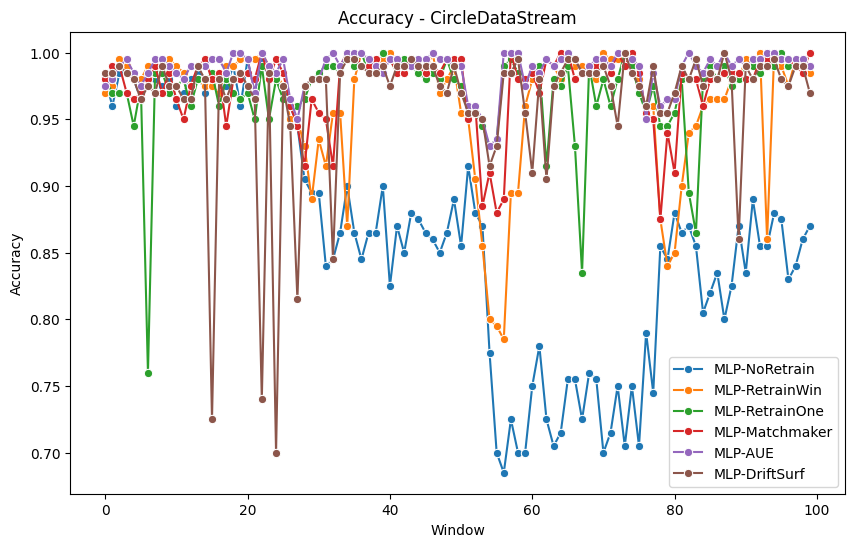

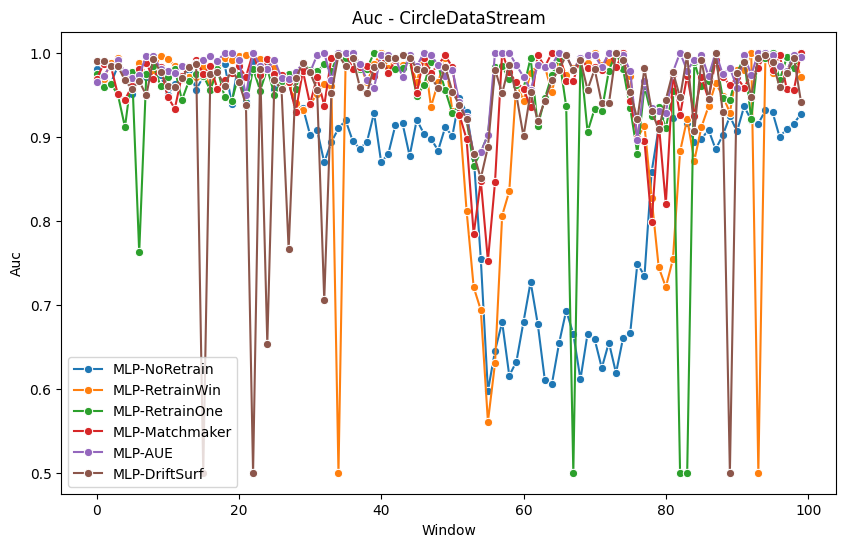

In [10]:
pipeline_circle = Pipeline(dataset_name="CircleDataStream", data_stream=circle_ds, algorithms=algorithms, drift_detector=AlwaysDriftDetector(), metric_evaluator=MetricEvaluator())
results_circle = pipeline_circle.run()
pipeline_circle.plot_results()

Running RF-RetrainOne on window 0
FITTING ALWAYS RETRAIN, Memory: 1 Total Train Length: 800
Running RF-RetrainOne on window 1
Accuracy: 0.978
FITTING ALWAYS RETRAIN, Memory: 1 Total Train Length: 800
Running RF-RetrainOne on window 2
Accuracy: 0.977
FITTING ALWAYS RETRAIN, Memory: 1 Total Train Length: 800
Running RF-RetrainOne on window 3
Accuracy: 0.972
FITTING ALWAYS RETRAIN, Memory: 1 Total Train Length: 800


<ipython-input-15-7ce0bc7c4c2f>:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.results[dataset_name] = self.results[dataset_name]._append({


Running RF-RetrainOne on window 4
Accuracy: 0.945
FITTING ALWAYS RETRAIN, Memory: 1 Total Train Length: 800
Running RF-RetrainOne on window 5
Accuracy: 0.971
FITTING ALWAYS RETRAIN, Memory: 1 Total Train Length: 800
Running RF-RetrainOne on window 6
Accuracy: 0.602
FITTING ALWAYS RETRAIN, Memory: 1 Total Train Length: 800
Running RF-RetrainOne on window 7
Accuracy: 0.987
FITTING ALWAYS RETRAIN, Memory: 1 Total Train Length: 800
Running RF-RetrainOne on window 8
Accuracy: 0.983
FITTING ALWAYS RETRAIN, Memory: 1 Total Train Length: 800
Running RF-RetrainOne on window 9
Accuracy: 0.963
FITTING ALWAYS RETRAIN, Memory: 1 Total Train Length: 800
Running RF-RetrainOne on window 10
Accuracy: 0.981
FITTING ALWAYS RETRAIN, Memory: 1 Total Train Length: 800
Running RF-RetrainOne on window 11
Accuracy: 0.945
FITTING ALWAYS RETRAIN, Memory: 1 Total Train Length: 800
Running RF-RetrainOne on window 12
Accuracy: 0.939
FITTING ALWAYS RETRAIN, Memory: 1 Total Train Length: 800
Running RF-RetrainOne on 

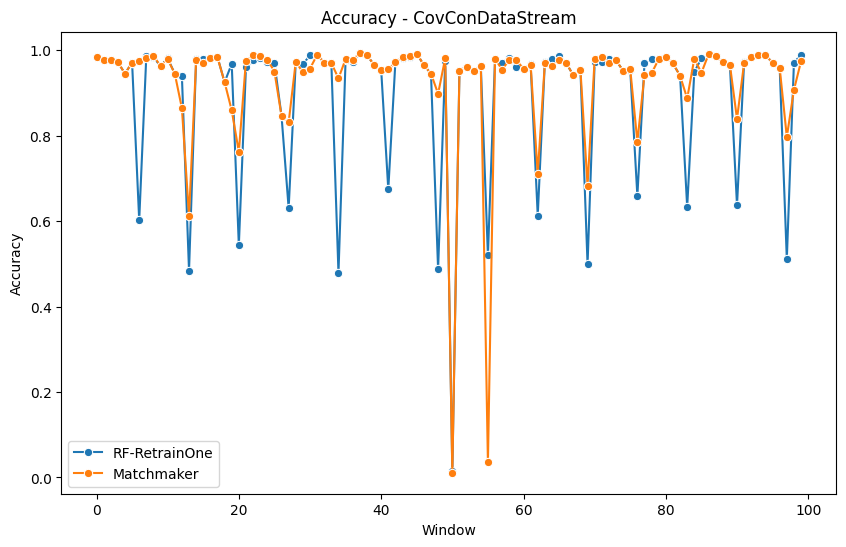

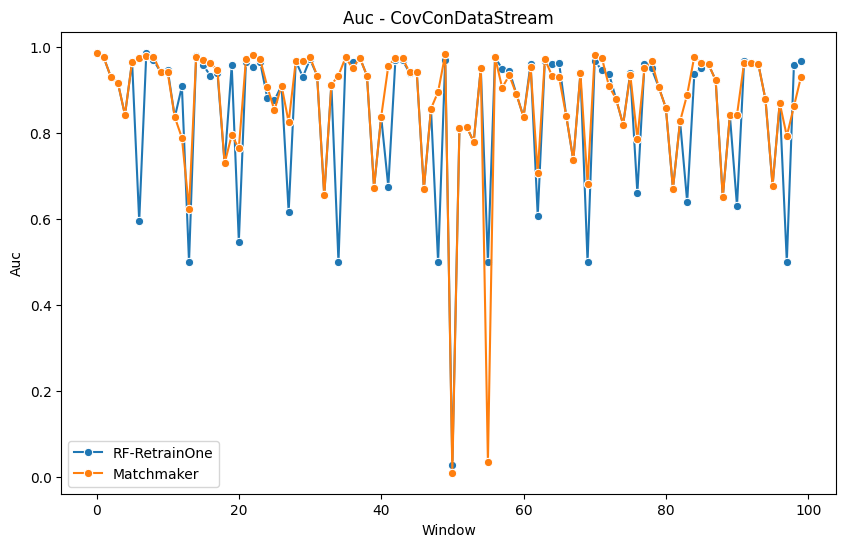

In [ ]:
pipeline_covcon = Pipeline(dataset_name="CovConDataStream", data_stream=covcon_ds, algorithms=algorithms, drift_detector=AlwaysDriftDetector(), metric_evaluator=MetricEvaluator())
results_covcon = pipeline_covcon.run()
pipeline_covcon.plot_results()

Running RF-RetrainOne on window 0
FITTING ALWAYS RETRAIN, Memory: 1 Total Train Length: 800
Running RF-RetrainOne on window 1
Accuracy: 0.958
FITTING ALWAYS RETRAIN, Memory: 1 Total Train Length: 800
Running RF-RetrainOne on window 2
Accuracy: 0.966
FITTING ALWAYS RETRAIN, Memory: 1 Total Train Length: 800
Running RF-RetrainOne on window 3
Accuracy: 0.962
FITTING ALWAYS RETRAIN, Memory: 1 Total Train Length: 800


<ipython-input-15-7ce0bc7c4c2f>:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.results[dataset_name] = self.results[dataset_name]._append({


Running RF-RetrainOne on window 4
Accuracy: 0.961
FITTING ALWAYS RETRAIN, Memory: 1 Total Train Length: 800
Running RF-RetrainOne on window 5
Accuracy: 0.962
FITTING ALWAYS RETRAIN, Memory: 1 Total Train Length: 800
Running RF-RetrainOne on window 6
Accuracy: 0.953
FITTING ALWAYS RETRAIN, Memory: 1 Total Train Length: 800
Running RF-RetrainOne on window 7
Accuracy: 0.963
FITTING ALWAYS RETRAIN, Memory: 1 Total Train Length: 800
Running RF-RetrainOne on window 8
Accuracy: 0.976
FITTING ALWAYS RETRAIN, Memory: 1 Total Train Length: 800
Running RF-RetrainOne on window 9
Accuracy: 0.976
FITTING ALWAYS RETRAIN, Memory: 1 Total Train Length: 800
Running RF-RetrainOne on window 10
Accuracy: 0.958
FITTING ALWAYS RETRAIN, Memory: 1 Total Train Length: 800
Running RF-RetrainOne on window 11
Accuracy: 0.969
FITTING ALWAYS RETRAIN, Memory: 1 Total Train Length: 800
Running RF-RetrainOne on window 12
Accuracy: 0.956
FITTING ALWAYS RETRAIN, Memory: 1 Total Train Length: 800
Running RF-RetrainOne on 

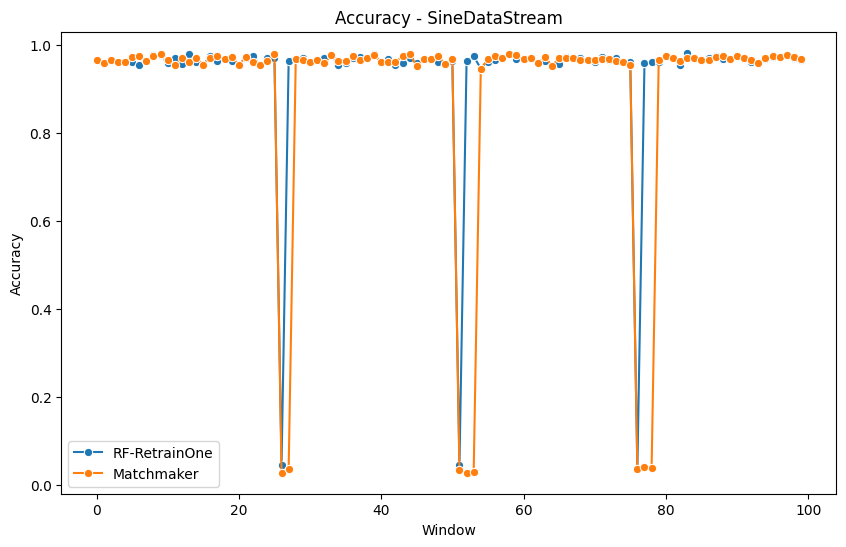

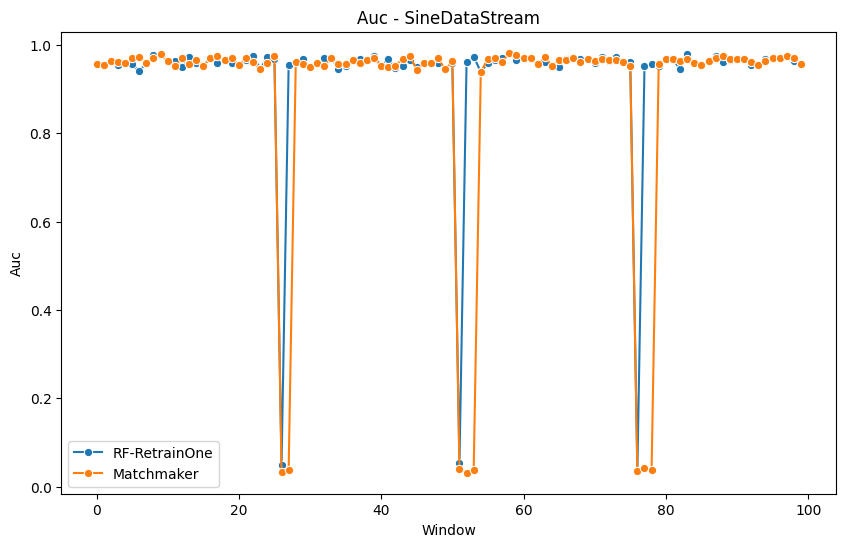

In [ ]:
pipeline_sine= Pipeline(dataset_name="SineDataStream", data_stream=sine_ds, algorithms=algorithms, drift_detector=AlwaysDriftDetector(), metric_evaluator=MetricEvaluator())
results_sine = pipeline_sine.run()
pipeline_sine.plot_results()


# Result Plotter Manual

In [ ]:
metric_eval = MetricEvaluator()
metric_eval.load_results("CircleDataStream", "CircleDataStream_results.csv")
metric_eval.load_results("CovConDataStream", "CovConDataStream_results.csv")
metric_eval.load_results("SineDataStream", "CovConDataStream_results.csv")
metric_eval.load_results("IOAdmissionStream", "IOAdmissionStream_results.csv")
metric_eval.plot_results()